In [24]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly, add_changepoints_to_plot
# from keras.models import Sequential
# from keras.layers import Dense

# from keras.optimizers import Adam

warnings.filterwarnings('ignore')

In [38]:
mat = np.empty((0, 5))
metrics = pd.DataFrame(mat)
metrics = pd.DataFrame(columns=['country', 'model', 'mae', 'mape', 'rsq'])

# Belgium

## train/test split

In [31]:
belgium = pd.read_csv('univariate_df_Belgium.csv')
belgium = belgium.set_index('date')
belgium.index = pd.to_datetime(belgium.index)
belgium
belgium = belgium.drop('Unnamed: 0', axis=1)

In [32]:
belgium.sort_index()
train_size = int(len(belgium) * 0.7)
belgium_train, belgium_test = belgium[0:train_size], belgium[train_size:]
print(belgium_train.shape, belgium_test.shape)

(141, 1) (61, 1)


In [33]:
belgium_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(belgium_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer')

,TEST SET,TRAINING SET
date,,
2020-03-01,NaN,0.0
2020-03-08,NaN,0.0
2020-03-15,NaN,9.0
2020-03-22,NaN,140.0
2020-03-29,NaN,602.0
...,...,...
2023-12-10,0.0,NaN
2023-12-17,0.0,NaN
2023-12-24,0.0,NaN


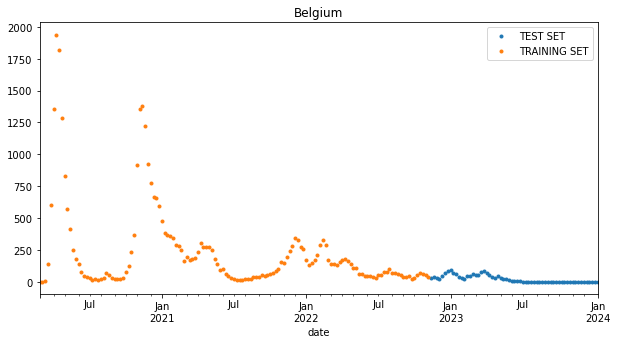

In [34]:
_ = belgium_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(belgium_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Belgium', style='.')

## basic ARIMA (1,1,1)

In [35]:
model=ARIMA(belgium_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -816.761
Date:                Tue, 20 Feb 2024   AIC                           1639.523
Time:                        19:23:23   BIC                           1648.348
Sample:                    03-01-2020   HQIC                          1643.109
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4999      0.040     12.637      0.000       0.422       0.577
ma.L1          0.6251      0.054     11.621      0.000       0.520       0.731
sigma2      6773.7973    320.856     21.112      0.000    6144.930    7402.664
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):              1034.31
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                             1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

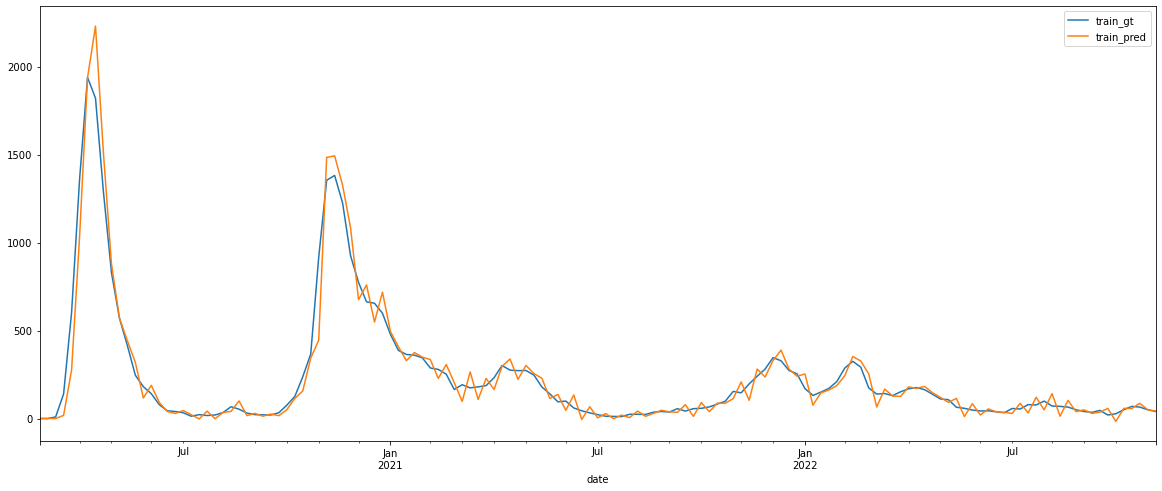

In [36]:
train_pred=model_fit.fittedvalues
pd.concat([belgium_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

<AxesSubplot:xlabel='date'>

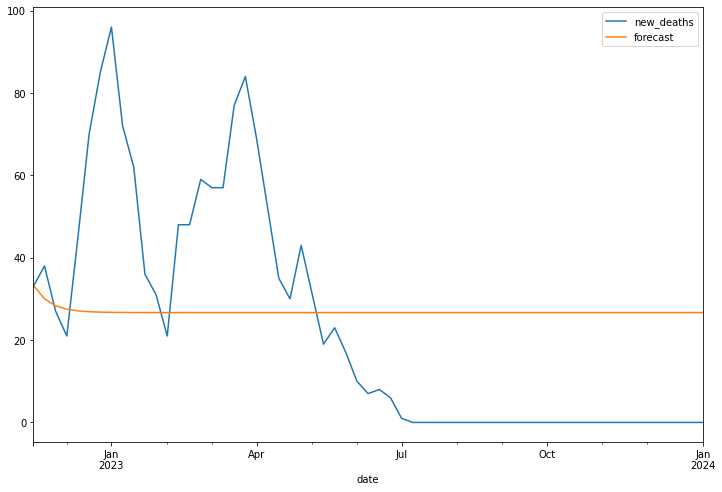

In [37]:
belgium_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
belgium_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [39]:
mae = mean_absolute_error(belgium_test['new_deaths'], belgium_test['forecast'])
mape = mean_absolute_percentage_error(belgium_test['new_deaths'], belgium_test['forecast'])
r2 = r2_score(belgium_test['new_deaths'], belgium_test['forecast'])
new_row = {'country': 'Belgium', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)


In [40]:
metrics

,country,model,mae,mape,rsq
0,Belgium,Basic ARIMA,24.434919,53180556358931816.0,-0.01208


## grid search ARIMA

In [41]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(belgium_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
3,1,4,1610.210208
7,2,4,1611.707061
11,3,4,1612.623391
15,4,4,1614.615250
13,4,2,1618.102403
10,3,3,1619.027561
6,2,3,1619.092098
14,4,3,1620.064888
8,3,1,1622.519450
4,2,1,1624.177540


In [42]:
model=ARIMA(belgium_train['new_deaths'],order=(1,1,4))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 4)   Log Likelihood                -799.105
Date:                Tue, 20 Feb 2024   AIC                           1610.210
Time:                        19:27:18   BIC                           1627.860
Sample:                    03-01-2020   HQIC                          1617.383
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7004      0.049     14.299      0.000       0.604       0.796
ma.L1          0.4256      4.733      0.090      0.928      -8.852       9.703
ma.L2         -0.2840      6.737     -0.042      0.966     -13.488      12.920
ma.L3         -0.6204      5.394     -0.115      0.908     -11.193       9.952
ma.L4         -0.5208      2.460     -0.212      0.832      -5.342       4.301
sigma2      5131.5563   2.42e+04      0.212      0.832   -4.24e+04    5.26e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              1596.92
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                             2.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

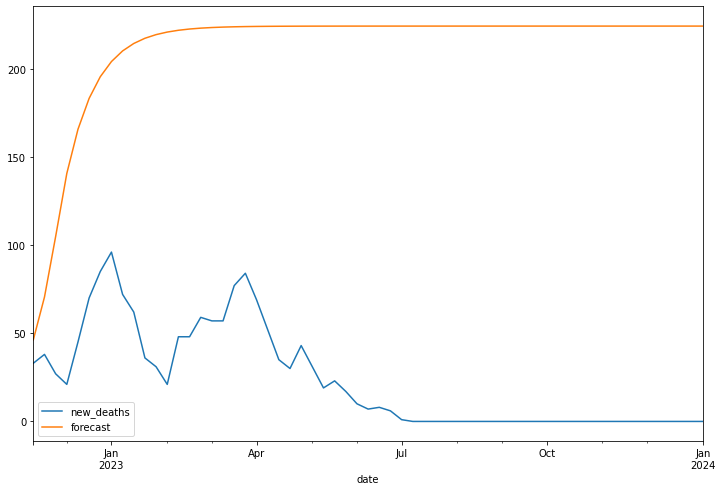

In [43]:
belgium_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
belgium_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [44]:
mae = mean_absolute_error(belgium_test['new_deaths'], belgium_test['forecast'])
mape = mean_absolute_percentage_error(belgium_test['new_deaths'], belgium_test['forecast'])
r2 = r2_score(belgium_test['new_deaths'], belgium_test['forecast'])
new_row = {'country': 'Belgium', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [46]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(belgium_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])



1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.48044D+00    |proj g|=  1.43696D-01

At iterate    5    f=  5.42439D+00    |proj g|=  6.34452D-03


 This problem is unconstrained.



At iterate   10    f=  5.42185D+00    |proj g|=  8.60252D-03

At iterate   15    f=  5.39526D+00    |proj g|=  7.34894D-03

At iterate   20    f=  5.39516D+00    |proj g|=  1.40325D-04

At iterate   25    f=  5.39456D+00    |proj g|=  1.27870D-02

At iterate   30    f=  5.39378D+00    |proj g|=  1.43616D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     47      1     0     0   9.114D-06   5.394D+00
  F =   5.3937579590426319     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =     

 This problem is unconstrained.



At iterate    5    f=  5.42453D+00    |proj g|=  5.99263D-03

At iterate   10    f=  5.40227D+00    |proj g|=  3.71631D-02

At iterate   15    f=  5.39422D+00    |proj g|=  2.24363D-03

At iterate   20    f=  5.39243D+00    |proj g|=  3.78420D-03

At iterate   25    f=  5.39215D+00    |proj g|=  1.26315D-03

At iterate   30    f=  5.39213D+00    |proj g|=  2.48088D-04

At iterate   35    f=  5.39208D+00    |proj g|=  2.96590D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     46      1     0     0   1.281D-04   5.392D+00
  F =   5.3920835115963817     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.42575D+00    |proj g|=  3.82301D-02

At iterate   10    f=  5.42127D+00    |proj g|=  2.65210D-03

At iterate   15    f=  5.41455D+00    |proj g|=  3.37734D-02

At iterate   20    f=  5.39426D+00    |proj g|=  6.03389D-03

At iterate   25    f=  5.39359D+00    |proj g|=  1.24839D-02

At iterate   30    f=  5.39097D+00    |proj g|=  6.82098D-03

At iterate   35    f=  5.39076D+00    |proj g|=  2.29000D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     45      1     0     0   4.412D-05   5.391D+00
  F =   5.3907554000799616     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.42126D+00    |proj g|=  7.60179D-03

At iterate   10    f=  5.41982D+00    |proj g|=  1.06492D-02

At iterate   15    f=  5.39307D+00    |proj g|=  1.44485D-02

At iterate   20    f=  5.39236D+00    |proj g|=  6.10978D-03

At iterate   25    f=  5.39225D+00    |proj g|=  1.01361D-03

At iterate   30    f=  5.39197D+00    |proj g|=  6.65152D-03

At iterate   35    f=  5.39186D+00    |proj g|=  1.69308D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     48      1     0     0   7.985D-06   5.392D+00
  F =   5.3918554848929636     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.37238D+00    |proj g|=  3.06102D-02

At iterate   10    f=  5.37012D+00    |proj g|=  2.08501D-03

At iterate   15    f=  5.36826D+00    |proj g|=  3.88865D-03

At iterate   20    f=  5.36572D+00    |proj g|=  3.85456D-04

At iterate   25    f=  5.36570D+00    |proj g|=  1.80243D-03

At iterate   30    f=  5.36538D+00    |proj g|=  1.63298D-03

At iterate   35    f=  5.36538D+00    |proj g|=  4.99864D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     48      1     0     0   9.674D-06   5.365D+00
  F =   5.3653815917675249     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.37047D+00    |proj g|=  4.44380D-03

At iterate   10    f=  5.37010D+00    |proj g|=  4.85901D-03

At iterate   15    f=  5.36794D+00    |proj g|=  5.88579D-03

At iterate   20    f=  5.36386D+00    |proj g|=  2.90947D-03

At iterate   25    f=  5.36314D+00    |proj g|=  1.36806D-03

At iterate   30    f=  5.36295D+00    |proj g|=  3.42695D-04

At iterate   35    f=  5.36295D+00    |proj g|=  1.37635D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     39      1     0     0   1.376D-05   5.363D+00
  F =   5.3629458313962184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.37941D+00    |proj g|=  4.78259D-02

At iterate   10    f=  5.36518D+00    |proj g|=  1.31552D-03

At iterate   15    f=  5.36489D+00    |proj g|=  4.13794D-03

At iterate   20    f=  5.36150D+00    |proj g|=  1.37633D-02

At iterate   25    f=  5.36033D+00    |proj g|=  3.36465D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     37      1     0     0   8.506D-06   5.360D+00
  F =   5.3603179296853964     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate    5    f=  5.36541D+00    |proj g|=  2.34962D-02

At iterate   10    f=  5.36455D+00    |proj g|=  7.02382D-03

At iterate   15    f=  5.36309D+00    |proj g|=  1.98830D-03

At iterate   20    f=  5.36277D+00    |proj g|=  3.61685D-03

At iterate   25    f=  5.36175D+00    |proj g|=  2.69315D-03

At iterate   30    f=  5.35954D+00    |proj g|=  1.13992D-02

At iterate   35    f=  5.35852D+00    |proj g|=  1.12297D-03

At iterate   40    f=  5.35850D+00    |proj g|=  1.53072D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40     49      1     0     0   1.531D-05   5.359D+00
  F =   5.35850454223

 This problem is unconstrained.



At iterate   10    f=  5.37388D+00    |proj g|=  7.65524D-03

At iterate   15    f=  5.34693D+00    |proj g|=  3.78536D-02

At iterate   20    f=  5.34378D+00    |proj g|=  1.01276D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     27      1     0     0   3.236D-05   5.344D+00
  F =   5.3437762905842918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.38175D+00    |proj g|=  7.95305D-02


 This problem is unconstrained.



At iterate    5    f=  5.37470D+00    |proj g|=  2.70120D-03

At iterate   10    f=  5.37044D+00    |proj g|=  3.15315D-02

At iterate   15    f=  5.34396D+00    |proj g|=  1.57814D-02

At iterate   20    f=  5.34316D+00    |proj g|=  6.12883D-03

At iterate   25    f=  5.34171D+00    |proj g|=  3.89077D-03

At iterate   30    f=  5.34170D+00    |proj g|=  1.13297D-04

At iterate   35    f=  5.34168D+00    |proj g|=  1.54121D-03

At iterate   40    f=  5.34163D+00    |proj g|=  5.90084D-04

At iterate   45    f=  5.34163D+00    |proj g|=  1.03629D-03

At iterate   50    f=  5.34162D+00    |proj g|=  2.24473D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.37191D+00    |proj g|=  3.13954D-02

At iterate   10    f=  5.36905D+00    |proj g|=  3.97596D-03

At iterate   15    f=  5.36403D+00    |proj g|=  1.91065D-02

At iterate   20    f=  5.33742D+00    |proj g|=  1.32936D-03

At iterate   25    f=  5.33737D+00    |proj g|=  2.86993D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     28      1     0     0   1.330D-05   5.337D+00
  F =   5.3373685560958810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate    5    f=  5.36925D+00    |proj g|=  3.07661D-03

At iterate   10    f=  5.36804D+00    |proj g|=  9.32517D-03

At iterate   15    f=  5.34086D+00    |proj g|=  1.39054D-02

At iterate   20    f=  5.33953D+00    |proj g|=  1.17776D-02

At iterate   25    f=  5.33835D+00    |proj g|=  4.78297D-03

At iterate   30    f=  5.33833D+00    |proj g|=  9.15939D-05

At iterate   35    f=  5.33832D+00    |proj g|=  2.94622D-03

At iterate   40    f=  5.33828D+00    |proj g|=  1.92256D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     54      1     0     0   7.495D-05   5.338D+00
  F =   5.33827742319

 This problem is unconstrained.



At iterate   10    f=  5.35068D+00    |proj g|=  5.68882D-03

At iterate   15    f=  5.34467D+00    |proj g|=  7.82516D-03

At iterate   20    f=  5.33361D+00    |proj g|=  1.16242D-02

At iterate   25    f=  5.32827D+00    |proj g|=  4.55283D-03

At iterate   30    f=  5.32121D+00    |proj g|=  9.91658D-04

At iterate   35    f=  5.32118D+00    |proj g|=  3.90498D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     44      1     0     0   3.905D-05   5.321D+00
  F =   5.3211792027724227     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.35174D+00    |proj g|=  6.37863D-03

At iterate   10    f=  5.35098D+00    |proj g|=  6.82384D-03

At iterate   15    f=  5.34935D+00    |proj g|=  5.08763D-03

At iterate   20    f=  5.34820D+00    |proj g|=  1.79518D-02

At iterate   25    f=  5.34582D+00    |proj g|=  2.57047D-03

At iterate   30    f=  5.34357D+00    |proj g|=  1.91365D-02

At iterate   35    f=  5.34256D+00    |proj g|=  4.38640D-04

At iterate   40    f=  5.34255D+00    |proj g|=  1.44198D-03

At iterate   45    f=  5.34240D+00    |proj g|=  3.55089D-03

At iterate   50    f=  5.34236D+00    |proj g|=  9.24744D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.36001D+00    |proj g|=  5.49885D-02

At iterate   10    f=  5.34461D+00    |proj g|=  2.73593D-03

At iterate   15    f=  5.34425D+00    |proj g|=  1.35972D-02

At iterate   20    f=  5.34160D+00    |proj g|=  3.38005D-03

At iterate   25    f=  5.34082D+00    |proj g|=  1.40866D-02

At iterate   30    f=  5.33924D+00    |proj g|=  1.90478D-02

At iterate   35    f=  5.33539D+00    |proj g|=  1.04139D-03

At iterate   40    f=  5.33539D+00    |proj g|=  8.92860D-05

At iterate   45    f=  5.33539D+00    |proj g|=  5.28284D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     50   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.41399D+00    |proj g|=  3.09140D-01

At iterate    5    f=  5.34462D+00    |proj g|=  1.49048D-02

At iterate   10    f=  5.34416D+00    |proj g|=  3.79481D-03

At iterate   15    f=  5.34316D+00    |proj g|=  1.00728D-02

At iterate   20    f=  5.34270D+00    |proj g|=  9.70056D-03

At iterate   25    f=  5.33916D+00    |proj g|=  5.50957D-03

At iterate   30    f=  5.33860D+00    |proj g|=  1.96986D-03

At iterate   35    f=  5.33791D+00    |proj g|=  8.00907D-03

At iterate   40    f=  5.33775D+00    |proj g|=  2.54472D-03

At iterate   45    f=  5.33747D+00    |proj g|=  2.94038D-03

At iterate   50    f=  5.33742D+00    |proj g|=  6.84115D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [47]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
12,2,2,1,1,1514.572535
8,2,1,1,1,1518.944914
10,2,1,2,1,1519.137933
9,2,1,1,2,1520.337751
14,2,2,2,1,1520.579364
11,2,1,2,2,1521.394233
13,2,2,1,2,1522.545584
15,2,2,2,2,1523.153018
4,1,2,1,1,1525.037609
6,1,2,2,1,1525.609656


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.48431D+00    |proj g|=  2.84494D-01



At iterate    5    f=  5.35573D+00    |proj g|=  5.85864D-02

At iterate   10    f=  5.35068D+00    |proj g|=  5.68882D-03

At iterate   15    f=  5.34467D+00    |proj g|=  7.82516D-03

At iterate   20    f=  5.33361D+00    |proj g|=  1.16242D-02

At iterate   25    f=  5.32827D+00    |proj g|=  4.55283D-03

At iterate   30    f=  5.32121D+00    |proj g|=  9.91658D-04

At iterate   35    f=  5.32118D+00    |proj g|=  3.90498D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     44      1     0     0   3.905D-05   5.321D+00
  F =   5.3211792027724227     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

<AxesSubplot:xlabel='date'>

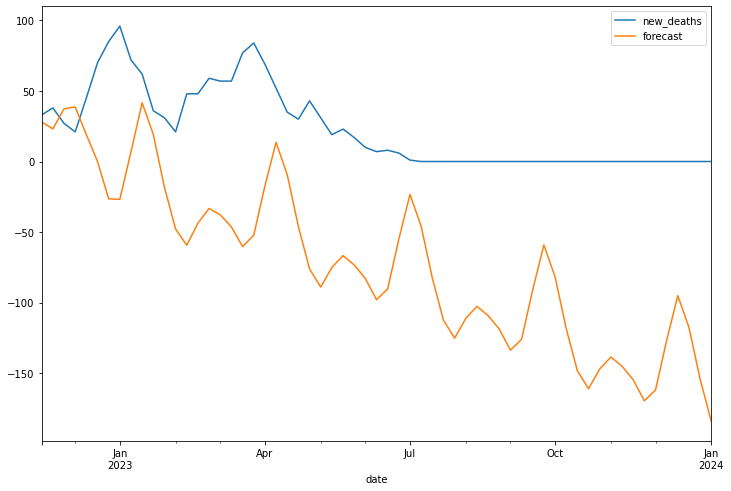

In [48]:
model=sm.tsa.statespace.SARIMAX(belgium_train['new_deaths'],order=(2, 1, 2),seasonal_order=(1,1,1,12))
results=model.fit()
belgium_test['forecast']=results.predict(start=141,end=202,dynamic=True)
belgium_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [49]:
mae = mean_absolute_error(belgium_test['new_deaths'], belgium_test['forecast'])
mape = mean_absolute_percentage_error(belgium_test['new_deaths'], belgium_test['forecast'])
r2 = r2_score(belgium_test['new_deaths'], belgium_test['forecast'])
new_row = {'country': 'Belgium', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [51]:
auto_model = auto_arima(belgium_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods = len(belgium_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(4, 1, 2)   Log Likelihood                -802.051
Date:                Tue, 20 Feb 2024   AIC                           1618.102
Time:                        19:32:00   BIC                           1638.694
Sample:                    03-01-2020   HQIC                          1626.470
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1034      0.109     10.144      0.000       0.890       1.317
ar.L2          0.1934      0.215      0.898      0.369      -0.229       0.616
ar.L3         -0.8121      0.230     -3.532      0.0

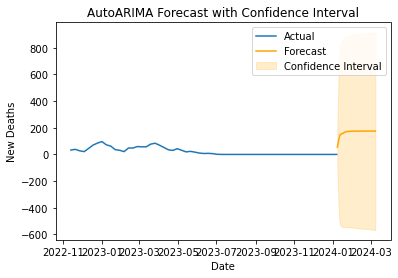

In [52]:
forecast_index = pd.date_range(belgium_test.index[-1], periods=n_periods + 1, freq=belgium_test.index.freq)[-n_periods:]

plt.plot(belgium_test.index, belgium_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [53]:
mae = mean_absolute_error(belgium_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(belgium_test['new_deaths'], forecast)
r2 = r2_score(belgium_test['new_deaths'], forecast)
new_row = {'country': 'Belgium', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Chile

## train/test split

In [55]:
chile = pd.read_csv('univariate_df_Chile.csv')
chile = chile.set_index('date')
chile.index = pd.to_datetime(chile.index)
chile = chile.drop('Unnamed: 0', axis=1)

In [56]:
chile.sort_index()
train_size = int(len(chile) * 0.7)
chile_train, chile_test = chile[0:train_size], belgium[train_size:]
print(chile_train.shape, chile_test.shape)

(141, 1) (61, 1)


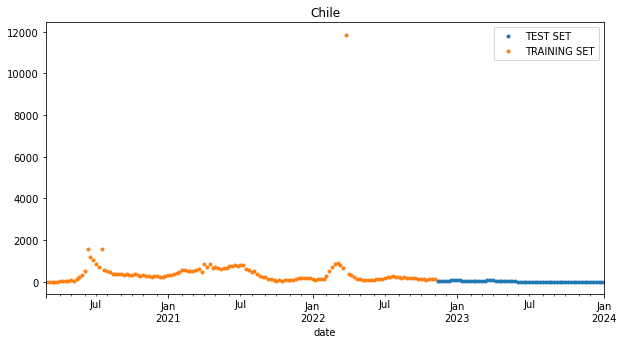

In [57]:
_ = chile_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(chile_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Chile', style='.')

## basic ARIMA (1,1,1)

In [62]:
model=ARIMA(chile_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1169.141
Date:                Tue, 20 Feb 2024   AIC                           2344.282
Time:                        19:34:53   BIC                           2353.107
Sample:                    03-01-2020   HQIC                          2347.868
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0966      0.072      1.335      0.182      -0.045       0.238
ma.L1         -1.0000      0.016    -62.153      0.000      -1.032      -0.968
sigma2      1.018e+06   1.58e-08   6.44e+13      0.000    1.02e+06    1.02e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             74257.07
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              25.95   Skew:                            10.14
Prob(H) (two-sided):                  0.00   Kurtosis:                       113.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.25e+29. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='date'>

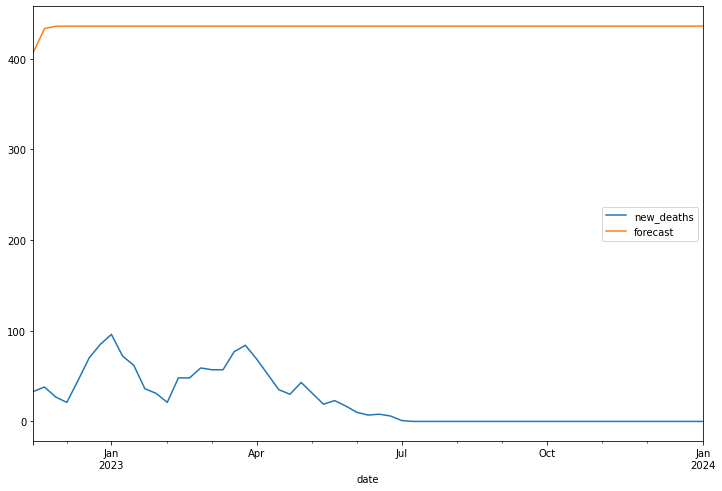

In [63]:
chile_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
chile_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [65]:
mae = mean_absolute_error(chile_test['new_deaths'], chile_test['forecast'])
mape = mean_absolute_percentage_error(chile_test['new_deaths'], chile_test['forecast'])
r2 = r2_score(chile_test['new_deaths'], chile_test['forecast'])
new_row = {'country': 'Chile', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [71]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(chile_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
0,1,1,2344.282061
1,1,2,2344.363894
4,2,1,2345.133080
2,1,3,2346.127384
5,2,2,2346.136333
8,3,1,2346.386257
9,3,2,2348.010441
12,4,1,2348.022862
3,1,4,2349.517875
7,2,4,2350.102737


In [69]:
model=ARIMA(chile_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1169.141
Date:                Tue, 20 Feb 2024   AIC                           2344.282
Time:                        22:19:23   BIC                           2353.107
Sample:                    03-01-2020   HQIC                          2347.868
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0966      0.072      1.335      0.182      -0.045       0.238
ma.L1         -1.0000      0.016    -62.153      0.000      -1.032      -0.968
sigma2      1.018e+06   1.58e-08   6.44e+13      0.000    1.02e+06    1.02e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             74257.07
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              25.95   Skew:                            10.14
Prob(H) (two-sided):                  0.00   Kurtosis:                       113.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.25e+29. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='date'>

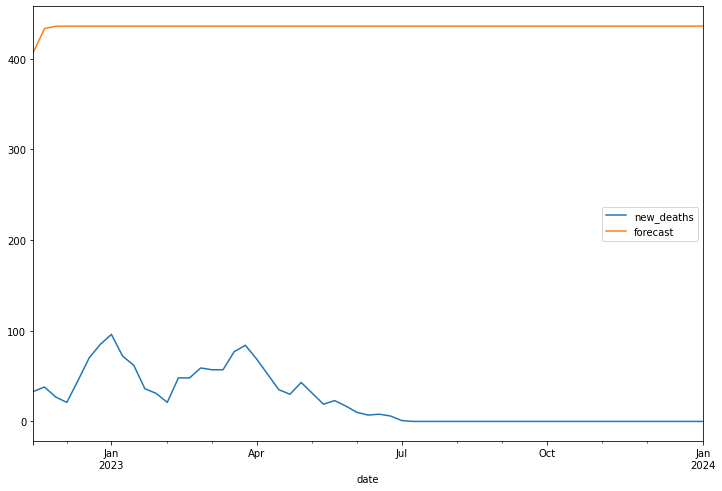

In [72]:
chile_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
chile_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [73]:
mae = mean_absolute_error(chile_test['new_deaths'], chile_test['forecast'])
mape = mean_absolute_percentage_error(chile_test['new_deaths'], chile_test['forecast'])
r2 = r2_score(chile_test['new_deaths'], chile_test['forecast'])
new_row = {'country': 'Chile', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [74]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(chile_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.80043D+00    |proj g|=  4.94371D-02

At iterate    5    f=  7.79252D+00    |proj g|=  1.14706D-02


 This problem is unconstrained.



At iterate   10    f=  7.79229D+00    |proj g|=  2.87249D-04

At iterate   15    f=  7.79150D+00    |proj g|=  5.41861D-03

At iterate   20    f=  7.72510D+00    |proj g|=  1.44864D-01

At iterate   25    f=  7.68696D+00    |proj g|=  6.67321D-04

At iterate   30    f=  7.68668D+00    |proj g|=  1.35415D-02

At iterate   35    f=  7.68649D+00    |proj g|=  6.87876D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     42      1     0     0   1.588D-05   7.686D+00
  F =   7.6864921022131076     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  7.79435D+00    |proj g|=  7.23357D-03

At iterate   10    f=  7.79213D+00    |proj g|=  2.32360D-02

At iterate   15    f=  7.78785D+00    |proj g|=  4.58366D-03

At iterate   20    f=  7.78757D+00    |proj g|=  2.63880D-03

At iterate   25    f=  7.78749D+00    |proj g|=  8.66186D-04

At iterate   30    f=  7.78616D+00    |proj g|=  1.28046D-02

At iterate   35    f=  7.68896D+00    |proj g|=  7.03444D-05

At iterate   40    f=  7.68893D+00    |proj g|=  1.19329D-05

At iterate   45    f=  7.68891D+00    |proj g|=  2.18581D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     60   

 This problem is unconstrained.



At iterate    5    f=  7.82721D+00    |proj g|=  4.66566D-02

At iterate   10    f=  7.78446D+00    |proj g|=  3.69795D-02

At iterate   15    f=  7.78334D+00    |proj g|=  2.67626D-03

At iterate   20    f=  7.78245D+00    |proj g|=  2.65448D-03

At iterate   25    f=  7.78243D+00    |proj g|=  6.40095D-04

At iterate   30    f=  7.78181D+00    |proj g|=  1.30377D-02

At iterate   35    f=  7.75453D+00    |proj g|=  5.05097D-02

At iterate   40    f=  7.68552D+00    |proj g|=  2.80283D-03

At iterate   45    f=  7.68550D+00    |proj g|=  3.06962D-03

At iterate   50    f=  7.68536D+00    |proj g|=  9.76172D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.79021D+00    |proj g|=  2.64079D-02

At iterate   10    f=  7.78384D+00    |proj g|=  5.69305D-03

At iterate   15    f=  7.78240D+00    |proj g|=  6.80517D-04

At iterate   20    f=  7.78233D+00    |proj g|=  1.70465D-03

At iterate   25    f=  7.78231D+00    |proj g|=  1.29997D-03

At iterate   30    f=  7.77857D+00    |proj g|=  1.89877D-02

At iterate   35    f=  7.69318D+00    |proj g|=  1.12275D-01

At iterate   40    f=  7.68578D+00    |proj g|=  6.82974D-04

At iterate   45    f=  7.68424D+00    |proj g|=  5.26423D-02

At iterate   50    f=  7.67118D+00    |proj g|=  5.25608D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.78943D+00    |proj g|=  2.16520D-03

At iterate   10    f=  7.78941D+00    |proj g|=  1.95355D-03

At iterate   15    f=  7.78851D+00    |proj g|=  1.31430D-02

At iterate   20    f=  7.74627D+00    |proj g|=  4.92422D-02

At iterate   25    f=  7.69279D+00    |proj g|=  7.60041D-03

At iterate   30    f=  7.68040D+00    |proj g|=  9.94926D-03

At iterate   35    f=  7.68010D+00    |proj g|=  3.70872D-03

At iterate   40    f=  7.67982D+00    |proj g|=  2.70544D-03

At iterate   45    f=  7.67980D+00    |proj g|=  5.62811D-04

At iterate   50    f=  7.67928D+00    |proj g|=  5.11413D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.79239D+00    |proj g|=  5.12945D-03

At iterate   10    f=  7.78728D+00    |proj g|=  1.84312D-02

At iterate   15    f=  7.78461D+00    |proj g|=  1.65284D-03

At iterate   20    f=  7.78457D+00    |proj g|=  5.78263D-04

At iterate   25    f=  7.78412D+00    |proj g|=  7.34546D-03

At iterate   30    f=  7.75763D+00    |proj g|=  2.52941D-02

At iterate   35    f=  7.69345D+00    |proj g|=  5.18040D-03

At iterate   40    f=  7.67567D+00    |proj g|=  5.64041D-03

At iterate   45    f=  7.67253D+00    |proj g|=  2.74631D-02

At iterate   50    f=  7.66973D+00    |proj g|=  1.36235D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.81459D+00    |proj g|=  4.30076D-02

At iterate   10    f=  7.78545D+00    |proj g|=  1.72698D-02

At iterate   15    f=  7.78468D+00    |proj g|=  3.88274D-03

At iterate   20    f=  7.77959D+00    |proj g|=  5.36282D-03

At iterate   25    f=  7.77945D+00    |proj g|=  3.00871D-04

At iterate   30    f=  7.77937D+00    |proj g|=  8.05336D-03

At iterate   35    f=  7.77119D+00    |proj g|=  7.18658D-02

At iterate   40    f=  7.71310D+00    |proj g|=  3.05564D-02

At iterate   45    f=  7.68504D+00    |proj g|=  1.80116D-02

At iterate   50    f=  7.67253D+00    |proj g|=  2.90053D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.78539D+00    |proj g|=  2.58565D-02

At iterate   10    f=  7.78018D+00    |proj g|=  4.63537D-03

At iterate   15    f=  7.77934D+00    |proj g|=  6.18658D-04

At iterate   20    f=  7.77932D+00    |proj g|=  1.14851D-03

At iterate   25    f=  7.77882D+00    |proj g|=  7.84890D-03

At iterate   30    f=  7.68096D+00    |proj g|=  3.14431D-02

At iterate   35    f=  7.66995D+00    |proj g|=  5.25028D-03

At iterate   40    f=  7.66745D+00    |proj g|=  4.12139D-03

At iterate   45    f=  7.66734D+00    |proj g|=  3.05659D-04

At iterate   50    f=  7.66722D+00    |proj g|=  2.12103D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.79227D+00    |proj g|=  9.19389D-03

At iterate   10    f=  7.79188D+00    |proj g|=  4.51593D-04

At iterate   15    f=  7.79186D+00    |proj g|=  1.87555D-03

At iterate   20    f=  7.79014D+00    |proj g|=  2.30661D-02

At iterate   25    f=  7.71001D+00    |proj g|=  8.41077D-02

At iterate   30    f=  7.68244D+00    |proj g|=  7.61199D-03

At iterate   35    f=  7.68199D+00    |proj g|=  9.41466D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     42      1     0     0   9.634D-06   7.682D+00
  F =   7.6819882826621519     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  7.79484D+00    |proj g|=  1.46318D-02

At iterate   10    f=  7.79184D+00    |proj g|=  1.68924D-02

At iterate   15    f=  7.78768D+00    |proj g|=  2.18976D-03

At iterate   20    f=  7.78745D+00    |proj g|=  4.80516D-03

At iterate   25    f=  7.78710D+00    |proj g|=  4.66084D-04

At iterate   30    f=  7.78705D+00    |proj g|=  3.70109D-03

At iterate   35    f=  7.75869D+00    |proj g|=  8.52882D-02

At iterate   40    f=  7.68483D+00    |proj g|=  1.22953D-02

At iterate   45    f=  7.68431D+00    |proj g|=  6.09781D-04

At iterate   50    f=  7.67836D+00    |proj g|=  4.86574D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.82146D+00    |proj g|=  2.95258D-02

At iterate   10    f=  7.78562D+00    |proj g|=  4.77262D-02

At iterate   15    f=  7.78206D+00    |proj g|=  3.05140D-04

At iterate   20    f=  7.78201D+00    |proj g|=  3.36322D-03

At iterate   25    f=  7.78182D+00    |proj g|=  7.16367D-04

At iterate   30    f=  7.78134D+00    |proj g|=  7.69547D-03

At iterate   35    f=  7.73786D+00    |proj g|=  7.92934D-02

At iterate   40    f=  7.67821D+00    |proj g|=  6.28763D-02

At iterate   45    f=  7.65807D+00    |proj g|=  7.61160D-03

At iterate   50    f=  7.65796D+00    |proj g|=  2.12804D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.79041D+00    |proj g|=  2.57355D-02

At iterate   10    f=  7.78397D+00    |proj g|=  4.94884D-03

At iterate   15    f=  7.78189D+00    |proj g|=  7.62833D-04

At iterate   20    f=  7.78185D+00    |proj g|=  2.44175D-03

At iterate   25    f=  7.77624D+00    |proj g|=  2.43227D-02

At iterate   30    f=  7.68007D+00    |proj g|=  7.56575D-02

At iterate   35    f=  7.67094D+00    |proj g|=  1.02623D-02

At iterate   40    f=  7.66405D+00    |proj g|=  9.82062D-03

At iterate   45    f=  7.65765D+00    |proj g|=  3.30321D-02

At iterate   50    f=  7.65694D+00    |proj g|=  5.61403D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.78919D+00    |proj g|=  2.87991D-03

At iterate   10    f=  7.78916D+00    |proj g|=  9.50743D-04

At iterate   15    f=  7.78876D+00    |proj g|=  9.60017D-03

At iterate   20    f=  7.78743D+00    |proj g|=  6.05977D-03

At iterate   25    f=  7.78332D+00    |proj g|=  3.99946D-02

At iterate   30    f=  7.72234D+00    |proj g|=  1.25754D-01

At iterate   35    f=  7.69595D+00    |proj g|=  8.14216D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     55      1     0     0   2.908D-03   7.688D+00
  F =   7.6881439267065517     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.81075D+00    |proj g|=  4.08102D-02

At iterate    5    f=  7.79149D+00    |proj g|=  1.21901D-02

At iterate   10    f=  7.79002D+00    |proj g|=  1.20745D-02

At iterate   15    f=  7.78474D+00    |proj g|=  3.85631D-03

At iterate   20    f=  7.78431D+00    |proj g|=  2.92620D-04

At iterate   25    f=  7.78423D+00    |proj g|=  2.34229D-03

At iterate   30    f=  7.78191D+00    |proj g|=  9.29063D-03

At iterate   35    f=  7.78027D+00    |proj g|=  1.00203D-02

At iterate   40    f=  7.75543D+00    |proj g|=  6.76901D-02

At iterate   45    f=  7.75024D+00    |proj g|=  3.92135D-03

At iterate   50    f=  7.74759D+00    |proj g|=  2.29204D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.85958D+00    |proj g|=  3.29606D-02

At iterate    5    f=  7.81603D+00    |proj g|=  3.85863D-02

At iterate   10    f=  7.78398D+00    |proj g|=  2.57823D-02

At iterate   15    f=  7.78203D+00    |proj g|=  5.79364D-03

At iterate   20    f=  7.77919D+00    |proj g|=  2.89890D-03

At iterate   25    f=  7.77914D+00    |proj g|=  3.01838D-04

At iterate   30    f=  7.77907D+00    |proj g|=  3.65437D-03

At iterate   35    f=  7.77688D+00    |proj g|=  6.24593D-03

At iterate   40    f=  7.77249D+00    |proj g|=  1.11780D-02

At iterate   45    f=  7.69911D+00    |proj g|=  6.40775D-02
  ys=-5.464E+09  -gs= 1.207E+00 BFGS update SKIPPED


LinAlgError: LU decomposition error.

In [75]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
10,2,1,2,1,2173.543385
11,2,1,2,2,2175.255966
5,1,2,1,2,2176.863469
3,1,1,2,2,2177.272452
4,1,2,1,1,2177.555640
0,1,1,1,1,2177.590773
6,1,2,2,1,2177.653421
7,1,2,2,2,2178.155369
8,2,1,1,1,2178.320696
2,1,1,2,1,2179.271861


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.80077D+00    |proj g|=  4.96884D-02

At iterate    5    f=  7.79227D+00    |proj g|=  9.19389D-03

At iterate   10    f=  7.79188D+00    |proj g|=  4.51593D-04

At iterate   15    f=  7.79186D+00    |proj g|=  1.87555D-03

At iterate   20    f=  7.79014D+00    |proj g|=  2.30661D-02

At iterate   25    f=  7.71001D+00    |proj g|=  8.41077D-02

At iterate   30    f=  7.68244D+00    |proj g|=  7.61199D-03

At iterate   35    f=  7.68199D+00    |proj g|=  9.41466D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

<AxesSubplot:xlabel='date'>

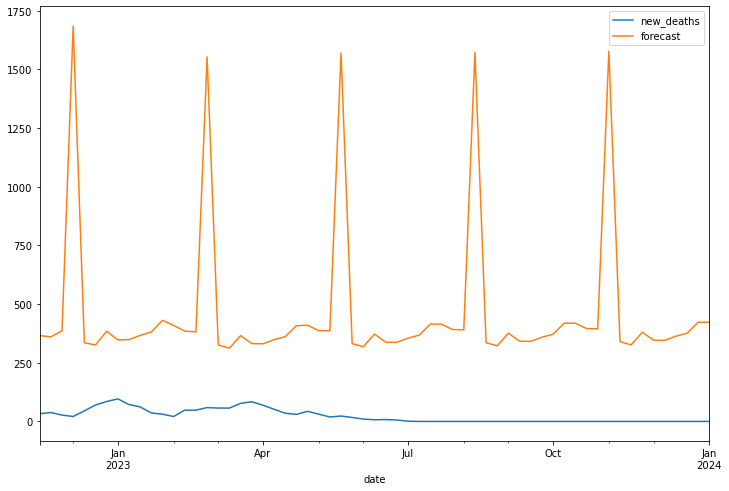

In [77]:
model=sm.tsa.statespace.SARIMAX(chile_train['new_deaths'],order=(2, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
chile_test['forecast']=results.predict(start=141,end=202,dynamic=True)
chile_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [79]:
mae = mean_absolute_error(chile_test['new_deaths'], chile_test['forecast'])
mape = mean_absolute_percentage_error(chile_test['new_deaths'], chile_test['forecast'])
r2 = r2_score(chile_test['new_deaths'], chile_test['forecast'])
new_row = {'country': 'Chile', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [80]:
auto_model = auto_arima(chile_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(chile_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:                        SARIMAX   Log Likelihood               -1175.312
Date:                Tue, 20 Feb 2024   AIC                           2354.623
Time:                        22:25:27   BIC                           2360.521
Sample:                    03-01-2020   HQIC                          2357.020
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    438.2199    298.221      1.469      0.142    -146.283    1022.723
sigma2      1.018e+06    5.6e+04     18.175      0.000    9.08e+05    1.13e+06
Ljung-Box (L1) (Q):                   1.19   Jarque-

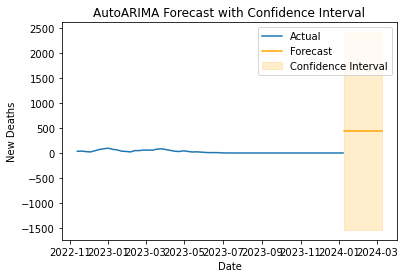

In [81]:
forecast_index = pd.date_range(chile_test.index[-1], periods=n_periods + 1, freq=chile_test.index.freq)[-n_periods:]

plt.plot(chile_test.index, chile_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [82]:
mae = mean_absolute_error(chile_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(chile_test['new_deaths'], forecast)
r2 = r2_score(chile_test['new_deaths'], forecast)
new_row = {'country': 'Chile', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Ireland

## train/test split

In [84]:
ireland = pd.read_csv('univariate_df_Ireland.csv')
ireland = ireland.set_index('date')
ireland.index = pd.to_datetime(ireland.index)
ireland = ireland.drop('Unnamed: 0', axis=1)

In [85]:
ireland.sort_index()
train_size = int(len(ireland) * 0.7)
ireland_train, ireland_test = ireland[0:train_size], ireland[train_size:]
print(ireland_train.shape, ireland_test.shape)

(141, 1) (61, 1)


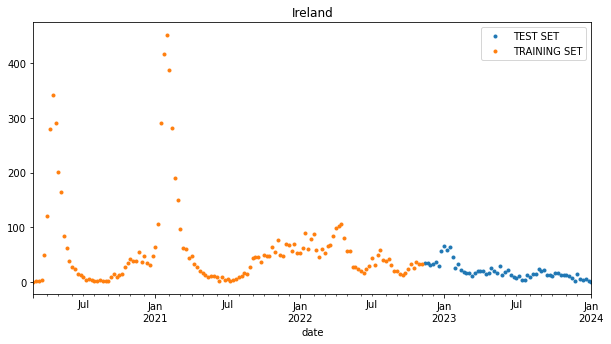

In [86]:
_ = ireland_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(ireland_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Ireland', style='.')

## basic ARIMA (1,1,1)

In [87]:
model=ARIMA(ireland_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -655.620
Date:                Tue, 20 Feb 2024   AIC                           1317.241
Time:                        22:26:50   BIC                           1326.066
Sample:                    03-01-2020   HQIC                          1320.827
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4492      0.079      5.680      0.000       0.294       0.604
ma.L1          0.2381      0.089      2.671      0.008       0.063       0.413
sigma2       681.7435     41.125     16.577      0.000     601.140     762.347
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               843.45
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                             1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

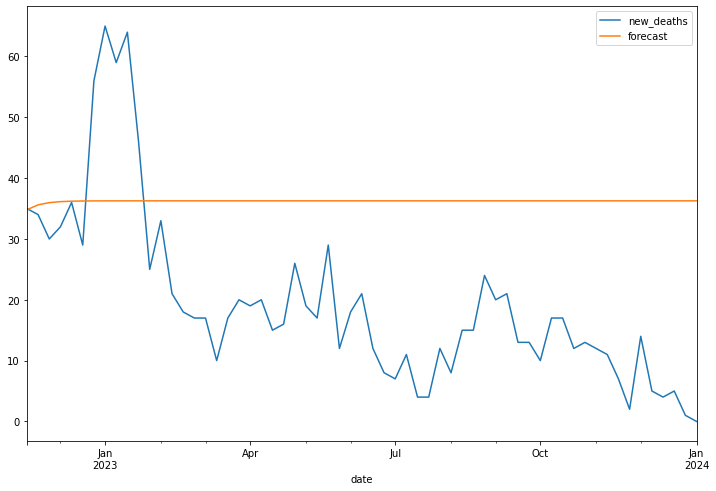

In [89]:
ireland_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
ireland_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [90]:
mae = mean_absolute_error(ireland_test['new_deaths'], ireland_test['forecast'])
mape = mean_absolute_percentage_error(ireland_test['new_deaths'], ireland_test['forecast'])
r2 = r2_score(ireland_test['new_deaths'], ireland_test['forecast'])
new_row = {'country': 'Ireland', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [92]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(ireland_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
14,4,3,1300.100800
4,2,1,1300.558468
13,4,2,1300.649867
9,3,2,1300.660977
10,3,3,1300.738630
8,3,1,1301.832457
5,2,2,1301.959090
15,4,4,1302.076228
11,3,4,1302.716639
12,4,1,1303.169609


In [93]:
model=ARIMA(ireland_train['new_deaths'],order=(4,1,5))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(4, 1, 5)   Log Likelihood                -641.423
Date:                Tue, 20 Feb 2024   AIC                           1302.845
Time:                        22:28:30   BIC                           1332.262
Sample:                    03-01-2020   HQIC                          1314.799
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2719      0.160     -1.704      0.088      -0.585       0.041
ar.L2          0.8692      0.176      4.936      0.000       0.524       1.214
ar.L3          0.2233      0.148      1.513      0.130      -0.066       0.512
ar.L4         -0.3988      0.158     -2.525      0.012      -0.708      -0.089
ma.L1          0.9024     69.270      0.013      0.990    -134.864     136.668
ma.L2         -0.5331    131.828     -0.004      0.997    -258.910     257.844
ma.L3         -0.8972     94.952     -0.009      0.992    -187.000     185.206
ma.L4         -0.2634     32.770     -0.008      0.994     -64.491      63.964
ma.L5         -0.2087     14.476     -0.014      0.988     -28.581      28.164
sigma2       529.9436   3.67e+04      0.014      0.988   -7.15e+04    7.25e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               942.20
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

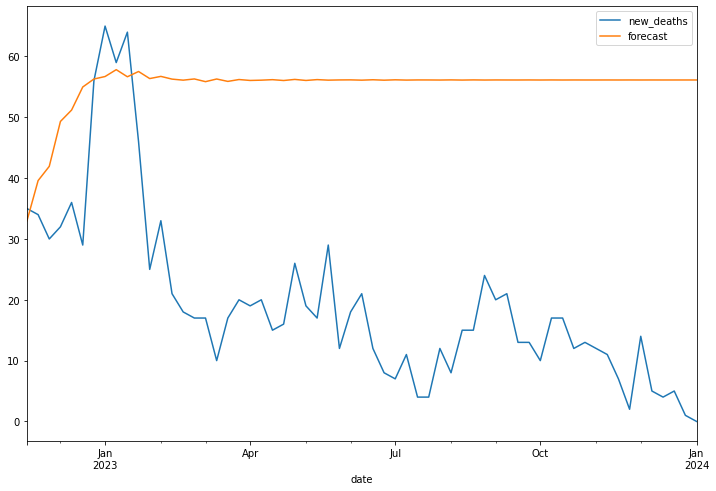

In [94]:
ireland_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
ireland_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [95]:
mae = mean_absolute_error(ireland_test['new_deaths'], ireland_test['forecast'])
mape = mean_absolute_percentage_error(ireland_test['new_deaths'], ireland_test['forecast'])
r2 = r2_score(ireland_test['new_deaths'], ireland_test['forecast'])
new_row = {'country': 'Ireland', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [97]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(ireland_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.41609D+00    |proj g|=  6.52439D-02

At iterate    5    f=  4.39639D+00    |proj g|=  1.03980D-02


 This problem is unconstrained.



At iterate   10    f=  4.33824D+00    |proj g|=  2.05704D-02

At iterate   15    f=  4.33732D+00    |proj g|=  9.14406D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     20      1     0     0   9.144D-06   4.337D+00
  F =   4.3373168475467434     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.41887D+00    |proj g|=  7.41156D-02


 This problem is unconstrained.



At iterate    5    f=  4.39856D+00    |proj g|=  1.02699D-02

At iterate   10    f=  4.34245D+00    |proj g|=  1.21827D-02

At iterate   15    f=  4.34043D+00    |proj g|=  3.69549D-04

At iterate   20    f=  4.34039D+00    |proj g|=  6.90503D-03

At iterate   25    f=  4.33968D+00    |proj g|=  4.08722D-02

At iterate   30    f=  4.33844D+00    |proj g|=  1.25521D-03

At iterate   35    f=  4.33779D+00    |proj g|=  8.12324D-03

At iterate   40    f=  4.33654D+00    |proj g|=  6.21103D-03

At iterate   45    f=  4.33606D+00    |proj g|=  3.73506D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     60   

 This problem is unconstrained.



At iterate    5    f=  4.39797D+00    |proj g|=  2.60263D-02

At iterate   10    f=  4.38349D+00    |proj g|=  3.59405D-02

At iterate   15    f=  4.33830D+00    |proj g|=  1.55317D-02

At iterate   20    f=  4.33698D+00    |proj g|=  4.90798D-03

At iterate   25    f=  4.33692D+00    |proj g|=  3.38543D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     32      1     0     0   9.088D-06   4.337D+00
  F =   4.3369202416310175     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  4.39764D+00    |proj g|=  1.25334D-02

At iterate   10    f=  4.33678D+00    |proj g|=  1.44043D-02

At iterate   15    f=  4.33656D+00    |proj g|=  9.33771D-04

At iterate   20    f=  4.33654D+00    |proj g|=  2.03755D-03

At iterate   25    f=  4.33633D+00    |proj g|=  1.91026D-03

At iterate   30    f=  4.33630D+00    |proj g|=  2.30694D-03

At iterate   35    f=  4.33624D+00    |proj g|=  1.56716D-03

At iterate   40    f=  4.33622D+00    |proj g|=  4.12781D-04

At iterate   45    f=  4.33622D+00    |proj g|=  8.19216D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     56   

 This problem is unconstrained.



At iterate    5    f=  4.37595D+00    |proj g|=  9.34189D-03

At iterate   10    f=  4.34789D+00    |proj g|=  3.81553D-02

At iterate   15    f=  4.33317D+00    |proj g|=  8.30628D-03

At iterate   20    f=  4.33309D+00    |proj g|=  1.01476D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     24      1     0     0   1.015D-05   4.333D+00
  F =   4.3330889033810820     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.40807D+00    |proj g|=  9.27909D-02

At iterate    5    f=  4.37764D+00    |proj g|=  9.26037D-03

At iterate   10    f=  4.35646D+00    |proj g|=  1.35249D-02

At iterate   15    f=  4.33571D+00    |proj g|=  5.38056D-03

At iterate   20    f=  4.33540D+00    |proj g|=  5.87314D-03

At iterate   25    f=  4.33444D+00    |proj g|=  1.40156D-02

At iterate   30    f=  4.33247D+00    |proj g|=  1.77692D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  4.37600D+00    |proj g|=  2.10533D-02

At iterate   10    f=  4.36897D+00    |proj g|=  2.96375D-02

At iterate   15    f=  4.33267D+00    |proj g|=  1.74858D-02

At iterate   20    f=  4.33232D+00    |proj g|=  1.01754D-04

At iterate   25    f=  4.33232D+00    |proj g|=  6.04306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     34      1     0     0   9.578D-06   4.332D+00
  F =   4.3323167967576861     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate    5    f=  4.37580D+00    |proj g|=  9.47114D-03

At iterate   10    f=  4.35716D+00    |proj g|=  5.95297D-02

At iterate   15    f=  4.33309D+00    |proj g|=  2.06677D-02

At iterate   20    f=  4.33242D+00    |proj g|=  4.80222D-03

At iterate   25    f=  4.33208D+00    |proj g|=  5.91695D-03

At iterate   30    f=  4.33170D+00    |proj g|=  1.09862D-03

At iterate   35    f=  4.33165D+00    |proj g|=  3.23150D-03

At iterate   40    f=  4.33152D+00    |proj g|=  8.14298D-04

At iterate   45    f=  4.33151D+00    |proj g|=  8.23702D-04

At iterate   50    f=  4.33150D+00    |proj g|=  5.56925D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


At iterate    5    f=  4.35762D+00    |proj g|=  1.19439D-02

At iterate   10    f=  4.29362D+00    |proj g|=  2.67503D-03

At iterate   15    f=  4.29345D+00    |proj g|=  2.68733D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     22      1     0     0   1.580D-05   4.293D+00
  F =   4.2934512945015619     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.38658D+00    |proj g|=  6.76798D-02


 This problem is unconstrained.



At iterate    5    f=  4.36050D+00    |proj g|=  1.70312D-02

At iterate   10    f=  4.30099D+00    |proj g|=  7.45815D-03

At iterate   15    f=  4.29942D+00    |proj g|=  9.39064D-04

At iterate   20    f=  4.29684D+00    |proj g|=  5.56757D-03

At iterate   25    f=  4.29464D+00    |proj g|=  1.48944D-03

At iterate   30    f=  4.29435D+00    |proj g|=  1.38731D-04

At iterate   35    f=  4.29432D+00    |proj g|=  1.73413D-04

At iterate   40    f=  4.29431D+00    |proj g|=  5.28514D-05

At iterate   45    f=  4.29431D+00    |proj g|=  6.52679D-05

At iterate   50    f=  4.29431D+00    |proj g|=  2.09324D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.36137D+00    |proj g|=  1.15639D-02

At iterate   10    f=  4.29435D+00    |proj g|=  2.52852D-02

At iterate   15    f=  4.28975D+00    |proj g|=  1.03309D-03

At iterate   20    f=  4.28950D+00    |proj g|=  5.72792D-03

At iterate   25    f=  4.28942D+00    |proj g|=  8.97767D-04

At iterate   30    f=  4.28777D+00    |proj g|=  2.03330D-02

At iterate   35    f=  4.28717D+00    |proj g|=  1.09734D-03

At iterate   40    f=  4.28715D+00    |proj g|=  1.75341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     52      1     0     0   4.954D-05   4.287D+00
  F =   4.28714853403

 This problem is unconstrained.



At iterate    5    f=  4.36017D+00    |proj g|=  1.36118D-02

At iterate   10    f=  4.32034D+00    |proj g|=  1.93128D-02

At iterate   15    f=  4.29333D+00    |proj g|=  3.38285D-02

At iterate   20    f=  4.28939D+00    |proj g|=  2.31345D-03

At iterate   25    f=  4.28704D+00    |proj g|=  8.57711D-04

At iterate   30    f=  4.28697D+00    |proj g|=  1.21564D-03

At iterate   35    f=  4.28650D+00    |proj g|=  4.50237D-04

At iterate   40    f=  4.28643D+00    |proj g|=  4.04706D-03

At iterate   45    f=  4.28635D+00    |proj g|=  2.69415D-04

At iterate   50    f=  4.28634D+00    |proj g|=  1.78728D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  4.30967D+00    |proj g|=  6.66686D-02

At iterate   15    f=  4.28586D+00    |proj g|=  3.34316D-02

At iterate   20    f=  4.28418D+00    |proj g|=  8.22832D-04

At iterate   25    f=  4.28391D+00    |proj g|=  9.44015D-03

At iterate   30    f=  4.28375D+00    |proj g|=  1.89276D-03

At iterate   35    f=  4.28371D+00    |proj g|=  3.07567D-04

At iterate   40    f=  4.28371D+00    |proj g|=  8.76150D-05

At iterate   45    f=  4.28371D+00    |proj g|=  8.22423D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     57      1     0     0   2.708D-05   4.284D+00
  F =   4.28370894922

 This problem is unconstrained.



At iterate    5    f=  4.34650D+00    |proj g|=  1.00733D-02

At iterate   10    f=  4.30905D+00    |proj g|=  2.07868D-02

At iterate   15    f=  4.29043D+00    |proj g|=  3.46365D-03

At iterate   20    f=  4.28891D+00    |proj g|=  1.59679D-03

At iterate   25    f=  4.28789D+00    |proj g|=  2.89405D-03

At iterate   30    f=  4.28779D+00    |proj g|=  1.28927D-03

At iterate   35    f=  4.28762D+00    |proj g|=  2.33243D-04

At iterate   40    f=  4.28759D+00    |proj g|=  1.75583D-04

At iterate   45    f=  4.28759D+00    |proj g|=  2.23664D-04

At iterate   50    f=  4.28759D+00    |proj g|=  1.12927D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.36874D+00    |proj g|=  7.64179D-02

At iterate    5    f=  4.34097D+00    |proj g|=  2.97440D-02

At iterate   10    f=  4.32310D+00    |proj g|=  8.42447D-02

At iterate   15    f=  4.28920D+00    |proj g|=  4.51819D-02

At iterate   20    f=  4.27910D+00    |proj g|=  1.30402D-03

At iterate   25    f=  4.27904D+00    |proj g|=  5.54855D-04

At iterate   30    f=  4.27902D+00    |proj g|=  1.18624D-03

At iterate   35    f=  4.27885D+00    |proj g|=  2.49828D-03

At iterate   40    f=  4.27879D+00    |proj g|=  1.86015D-03

At iterate   45    f=  4.27876D+00    |proj g|=  3.24843D-04

At iterate   50    f=  4.27876D+00    |proj g|=  1.62052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  4.34057D+00    |proj g|=  2.02452D-02

At iterate   10    f=  4.31830D+00    |proj g|=  4.89896D-02

At iterate   15    f=  4.28139D+00    |proj g|=  5.81882D-03

At iterate   20    f=  4.28003D+00    |proj g|=  5.12953D-03

At iterate   25    f=  4.27938D+00    |proj g|=  4.61764D-04

At iterate   30    f=  4.27920D+00    |proj g|=  4.01948D-04

At iterate   35    f=  4.27917D+00    |proj g|=  2.16948D-04

At iterate   40    f=  4.27916D+00    |proj g|=  1.75675D-04

At iterate   45    f=  4.27916D+00    |proj g|=  4.54930D-05

At iterate   50    f=  4.27916D+00    |proj g|=  1.09969D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [98]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
12,2,2,1,1,1222.005924
14,2,2,2,1,1222.610035
8,2,1,1,1,1222.753265
10,2,1,2,1,1222.975887
15,2,2,2,2,1224.724154
11,2,1,2,2,1224.747386
9,2,1,1,2,1224.994741
13,2,2,1,2,1225.099618
0,1,1,1,1,1233.123351
4,1,2,1,1,1233.931071


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.36878D+00    |proj g|=  6.18701D-02

At iterate    5    f=  4.34118D+00    |proj g|=  1.52465D-02

At iterate   10    f=  4.30967D+00    |proj g|=  6.66686D-02

At iterate   15    f=  4.28586D+00    |proj g|=  3.34316D-02

At iterate   20    f=  4.28418D+00    |proj g|=  8.22832D-04

At iterate   25    f=  4.28391D+00    |proj g|=  9.44015D-03

At iterate   30    f=  4.28375D+00    |proj g|=  1.89276D-03

At iterate   35    f=  4.28371D+00    |proj g|=  3.07567D-04

At iterate   40    f=  4.28371D+00    |proj g|=  8.76150D-05

At iterate   45    f=  4.28371D+00    |proj g|=  8.22423D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

<AxesSubplot:xlabel='date'>

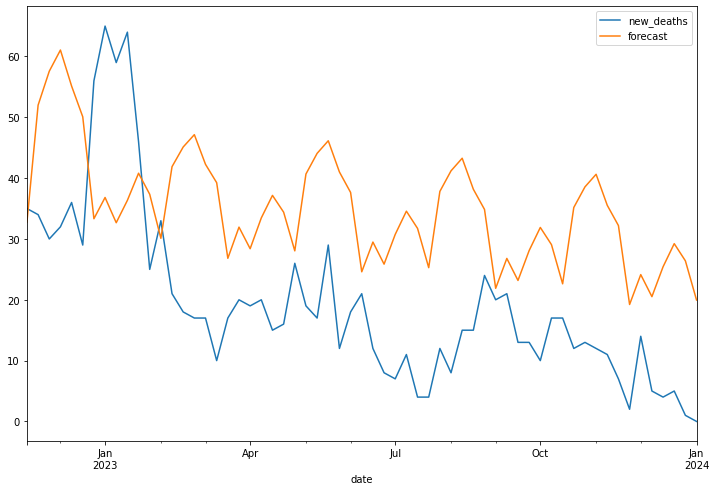

In [99]:
model=sm.tsa.statespace.SARIMAX(ireland_train['new_deaths'],order=(2, 1, 2),seasonal_order=(1,1,1,12))
results=model.fit()
ireland_test['forecast']=results.predict(start=141,end=202,dynamic=True)
ireland_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [100]:
mae = mean_absolute_error(ireland_test['new_deaths'], ireland_test['forecast'])
mape = mean_absolute_percentage_error(ireland_test['new_deaths'], ireland_test['forecast'])
r2 = r2_score(ireland_test['new_deaths'], ireland_test['forecast'])
new_row = {'country': 'Ireland', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [102]:
auto_model = auto_arima(ireland_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(ireland_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -649.850
Date:                Tue, 20 Feb 2024   AIC                           1307.700
Time:                        22:31:22   BIC                           1319.495
Sample:                    03-01-2020   HQIC                          1312.493
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.2423      4.251      1.939      0.052      -0.089      16.573
ar.L1          1.5153      0.050     30.475      0.000       1.418       1.613
ar.L2         -0.6593      0.050    -13.281      0.0

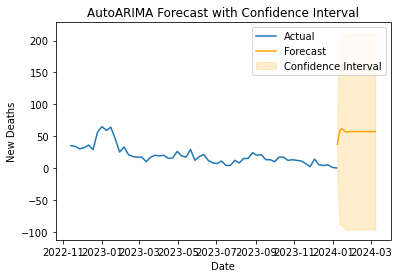

In [103]:
forecast_index = pd.date_range(ireland_test.index[-1], periods=n_periods + 1, freq=ireland_test.index.freq)[-n_periods:]

plt.plot(ireland_test.index, ireland_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [104]:
mae = mean_absolute_error(ireland_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(ireland_test['new_deaths'], forecast)
r2 = r2_score(ireland_test['new_deaths'], forecast)
new_row = {'country': 'Ireland', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Israel

## train/test split

In [106]:
israel = pd.read_csv('univariate_df_Israel.csv')
israel = israel.set_index('date')
israel.index = pd.to_datetime(israel.index)
israel = israel.drop('Unnamed: 0', axis=1)
israel.sort_index()
train_size = int(len(israel) * 0.7)
israel_train, israel_test = israel[0:train_size], israel[train_size:]
print(israel_train.shape, israel_test.shape)

(141, 1) (61, 1)


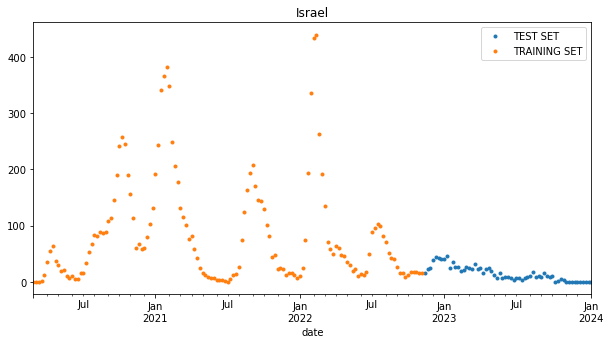

In [107]:
_ = israel_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(israel_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Israel', style='.')

## basic ARIMA (1,1,1)

In [108]:
model=ARIMA(israel_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -653.329
Date:                Tue, 20 Feb 2024   AIC                           1312.659
Time:                        22:32:36   BIC                           1321.483
Sample:                    03-01-2020   HQIC                          1316.245
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5460      0.085      6.419      0.000       0.379       0.713
ma.L1          0.1849      0.103      1.799      0.072      -0.016       0.386
sigma2       659.3501     41.918     15.729      0.000     577.191     741.509
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              1164.88
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               2.69   Skew:                            -1.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

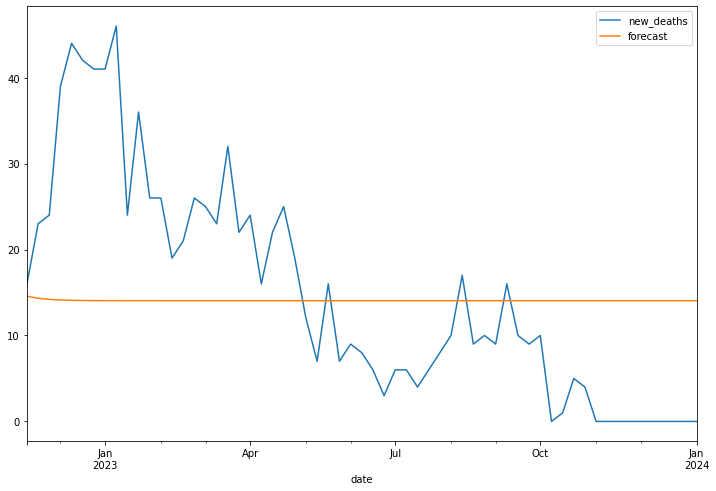

In [109]:
israel_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
israel_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [110]:
mae = mean_absolute_error(israel_test['new_deaths'], israel_test['forecast'])
mape = mean_absolute_percentage_error(israel_test['new_deaths'], israel_test['forecast'])
r2 = r2_score(israel_test['new_deaths'], israel_test['forecast'])
new_row = {'country': 'Israel', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [111]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(israel_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
4,2,1,1297.070913
7,2,4,1297.142502
3,1,4,1297.339035
9,3,2,1298.332196
11,3,4,1298.698057
8,3,1,1298.945634
5,2,2,1298.971234
15,4,4,1299.476828
6,2,3,1299.545116
10,3,3,1300.332371


In [115]:
model=ARIMA(israel_train['new_deaths'],order=(2,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -644.535
Date:                Tue, 20 Feb 2024   AIC                           1297.071
Time:                        22:34:14   BIC                           1308.837
Sample:                    03-01-2020   HQIC                          1301.852
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5909      0.053     29.807      0.000       1.486       1.696
ar.L2         -0.6995      0.035    -19.950      0.000      -0.768      -0.631
ma.L1         -0.9998      5.252     -0.190      0.849     -11.294       9.294
sigma2       567.7204   2949.659      0.192      0.847   -5213.504    6348.945
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               604.84
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               2.30   Skew:                            -0.65
Prob(H) (two-sided):                  0.01   Kurtosis:                        13.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

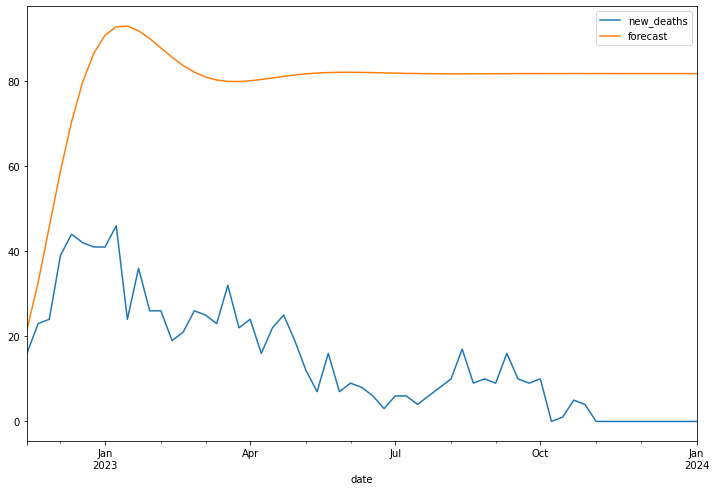

In [116]:
israel_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
israel_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [117]:
mae = mean_absolute_error(israel_test['new_deaths'], israel_test['forecast'])
mape = mean_absolute_percentage_error(israel_test['new_deaths'], israel_test['forecast'])
r2 = r2_score(israel_test['new_deaths'], israel_test['forecast'])
new_row = {'country': 'Israel', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [118]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(israel_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.48030D+00    |proj g|=  7.08639D-02

At iterate    5    f=  4.44835D+00    |proj g|=  1.32156D-02


 This problem is unconstrained.



At iterate   10    f=  4.39204D+00    |proj g|=  1.35588D-01

At iterate   15    f=  4.35769D+00    |proj g|=  7.41387D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   1.897D-05   4.358D+00
  F =   4.3576897574017091     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.52025D+00    |proj g|=  1.37855D-01


 This problem is unconstrained.



At iterate    5    f=  4.44732D+00    |proj g|=  1.11833D-02

At iterate   10    f=  4.38150D+00    |proj g|=  1.08550D-01

At iterate   15    f=  4.35687D+00    |proj g|=  2.05369D-03

At iterate   20    f=  4.35642D+00    |proj g|=  4.81854D-04

At iterate   25    f=  4.35638D+00    |proj g|=  1.86391D-04

At iterate   30    f=  4.35637D+00    |proj g|=  2.31599D-04

At iterate   35    f=  4.35631D+00    |proj g|=  1.34488D-03

At iterate   40    f=  4.35569D+00    |proj g|=  7.13594D-03

At iterate   45    f=  4.35522D+00    |proj g|=  9.37748D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     69   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.47715D+00    |proj g|=  5.20884D-02

At iterate    5    f=  4.45996D+00    |proj g|=  6.10100D-02

At iterate   10    f=  4.43674D+00    |proj g|=  1.24204D-02

At iterate   15    f=  4.37107D+00    |proj g|=  6.58145D-02

At iterate   20    f=  4.35515D+00    |proj g|=  9.81550D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     26      1     0     0   5.645D-06   4.355D+00
  F =   4.3550437875116783     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.58582D+00    |proj g|=  2.66845D-01

At iterate    5    f=  4.45744D+00    |proj g|=  1.51477D-02

At iterate   10    f=  4.39217D+00    |proj g|=  7.31612D-02

At iterate   15    f=  4.35647D+00    |proj g|=  6.37002D-03

At iterate   20    f=  4.35642D+00    |proj g|=  1.79100D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     26      1     0     0   1.867D-05   4.356D+00
  F =   4.3564212262491555     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  4.44640D+00    |proj g|=  1.11434D-02

At iterate   10    f=  4.37512D+00    |proj g|=  1.43704D-01

At iterate   15    f=  4.34987D+00    |proj g|=  4.54888D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     24      1     0     0   5.209D-06   4.350D+00
  F =   4.3498205664657634     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.51486D+00    |proj g|=  1.31106D-01

At iterate    5    f=  4.44419D+00    |proj g|=  1.11744D-02

At iterate   10    f=  4.38943D+00    |proj g|=  5.29131D-02

At iterate   15    f=  4.36013D+00    |proj g|=  3.90896D-02

At iterate   20    f=  4.34911D+00    |proj g|=  4.71507D-03

At iterate   25    f=  4.34903D+00    |proj g|=  1.73682D-04

At iterate   30    f=  4.34901D+00    |proj g|=  1.85519D-03

At iterate   35    f=  4.34897D+00    |proj g|=  1.19506D-03

At iterate   40    f=  4.34862D+00    |proj g|=  6.32462D-03

At iterate   45    f=  4.34810D+00    |proj g|=  1.58166D-03

At iterate   50    f=  4.34809D+00    |proj g|=  2.70042D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  4.45645D+00    |proj g|=  7.41412D-02

At iterate   10    f=  4.43680D+00    |proj g|=  2.35117D-02

At iterate   15    f=  4.40603D+00    |proj g|=  4.67149D-02

At iterate   20    f=  4.35829D+00    |proj g|=  6.41290D-02

At iterate   25    f=  4.34851D+00    |proj g|=  1.84072D-03

At iterate   30    f=  4.34848D+00    |proj g|=  1.85857D-03

At iterate   35    f=  4.34831D+00    |proj g|=  8.97525D-04

At iterate   40    f=  4.34829D+00    |proj g|=  4.24356D-04

At iterate   45    f=  4.34828D+00    |proj g|=  2.45414D-04

At iterate   50    f=  4.34828D+00    |proj g|=  2.81652D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.45465D+00    |proj g|=  3.32503D-02

At iterate   10    f=  4.35002D+00    |proj g|=  2.12721D-02

At iterate   15    f=  4.34918D+00    |proj g|=  2.81542D-03

At iterate   20    f=  4.34911D+00    |proj g|=  9.97290D-05

At iterate   25    f=  4.34910D+00    |proj g|=  2.04056D-03

At iterate   30    f=  4.34908D+00    |proj g|=  2.16231D-04

At iterate   35    f=  4.34908D+00    |proj g|=  2.88167D-04

At iterate   40    f=  4.34908D+00    |proj g|=  3.37079D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     51      1     0     0   3.193D-05   4.349D+00
  F =   4.34907717081

 This problem is unconstrained.



At iterate   10    f=  4.43033D+00    |proj g|=  2.56209D-02

At iterate   15    f=  4.36067D+00    |proj g|=  2.72390D-02

At iterate   20    f=  4.35984D+00    |proj g|=  5.03219D-03

At iterate   25    f=  4.35917D+00    |proj g|=  1.01235D-01

At iterate   30    f=  4.31714D+00    |proj g|=  2.41216D-02

At iterate   35    f=  4.31029D+00    |proj g|=  9.95746D-03

At iterate   40    f=  4.30969D+00    |proj g|=  4.07717D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     50      1     0     0   7.801D-06   4.310D+00
  F =   4.3096937750233009     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  4.44150D+00    |proj g|=  1.06000D-02

At iterate   10    f=  4.37698D+00    |proj g|=  8.76634D-02

At iterate   15    f=  4.32146D+00    |proj g|=  2.40209D-02

At iterate   20    f=  4.30981D+00    |proj g|=  1.01334D-02

At iterate   25    f=  4.30853D+00    |proj g|=  3.21891D-04

At iterate   30    f=  4.30838D+00    |proj g|=  2.86619D-03

At iterate   35    f=  4.30704D+00    |proj g|=  4.55014D-03

At iterate   40    f=  4.30692D+00    |proj g|=  3.66988D-04

At iterate   45    f=  4.30692D+00    |proj g|=  3.11232D-05

At iterate   50    f=  4.30691D+00    |proj g|=  8.12779D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.46104D+00    |proj g|=  3.29251D-02

At iterate   10    f=  4.43719D+00    |proj g|=  1.10407D-02

At iterate   15    f=  4.42558D+00    |proj g|=  4.94924D-02

At iterate   20    f=  4.36354D+00    |proj g|=  4.85006D-02

At iterate   25    f=  4.35772D+00    |proj g|=  1.12750D-02

At iterate   30    f=  4.35704D+00    |proj g|=  1.62459D-03

At iterate   35    f=  4.35687D+00    |proj g|=  9.04171D-04

At iterate   40    f=  4.35686D+00    |proj g|=  3.55540D-05

At iterate   45    f=  4.35686D+00    |proj g|=  5.51844D-04

At iterate   50    f=  4.35685D+00    |proj g|=  1.21059D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.45953D+00    |proj g|=  3.66492D-02

At iterate   10    f=  4.33553D+00    |proj g|=  5.33119D-02

At iterate   15    f=  4.30880D+00    |proj g|=  1.16445D-02

At iterate   20    f=  4.30841D+00    |proj g|=  4.67614D-04

At iterate   25    f=  4.30840D+00    |proj g|=  1.48946D-04

At iterate   30    f=  4.30837D+00    |proj g|=  8.03006D-04

At iterate   35    f=  4.30834D+00    |proj g|=  3.54362D-04

At iterate   40    f=  4.30834D+00    |proj g|=  1.44866D-04

At iterate   45    f=  4.30833D+00    |proj g|=  7.55632D-05

At iterate   50    f=  4.30833D+00    |proj g|=  3.60197D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.46590D+00    |proj g|=  7.56469D-02

At iterate    5    f=  4.42921D+00    |proj g|=  1.15381D-02

At iterate   10    f=  4.40660D+00    |proj g|=  7.11742D-02

At iterate   15    f=  4.35338D+00    |proj g|=  4.32803D-02

At iterate   20    f=  4.31301D+00    |proj g|=  1.21856D-02

At iterate   25    f=  4.31161D+00    |proj g|=  3.60872D-03

At iterate   30    f=  4.30988D+00    |proj g|=  3.09830D-02

At iterate   35    f=  4.30917D+00    |proj g|=  6.40185D-04

At iterate   40    f=  4.30917D+00    |proj g|=  8.58511D-05

At iterate   45    f=  4.30916D+00    |proj g|=  1.02434D-03

At iterate   50    f=  4.30913D+00    |proj g|=  1.37717D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  4.43106D+00    |proj g|=  1.17772D-02

At iterate   10    f=  4.40178D+00    |proj g|=  3.94839D-02

At iterate   15    f=  4.31930D+00    |proj g|=  2.57581D-02

At iterate   20    f=  4.31478D+00    |proj g|=  9.00199D-03

At iterate   25    f=  4.31078D+00    |proj g|=  1.28483D-02

At iterate   30    f=  4.30937D+00    |proj g|=  8.61492D-03

At iterate   35    f=  4.30859D+00    |proj g|=  1.17271D-04

At iterate   40    f=  4.30859D+00    |proj g|=  2.09771D-04

At iterate   45    f=  4.30855D+00    |proj g|=  1.58712D-03

At iterate   50    f=  4.30850D+00    |proj g|=  5.94572D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.46186D+00    |proj g|=  6.18494D-02

At iterate    5    f=  4.44492D+00    |proj g|=  9.56069D-02

At iterate   10    f=  4.42115D+00    |proj g|=  1.31695D-02

At iterate   15    f=  4.39856D+00    |proj g|=  1.63880D-02

At iterate   20    f=  4.34663D+00    |proj g|=  3.07298D-02

At iterate   25    f=  4.34158D+00    |proj g|=  3.75285D-02

At iterate   30    f=  4.31510D+00    |proj g|=  2.43261D-02

At iterate   35    f=  4.31233D+00    |proj g|=  6.64096D-04

At iterate   40    f=  4.31232D+00    |proj g|=  1.33184D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44    108      2     0     0   5.649D+03  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.56228D+00    |proj g|=  2.50320D-01


 This problem is unconstrained.



At iterate    5    f=  4.44353D+00    |proj g|=  2.60712D-02

At iterate   10    f=  4.39882D+00    |proj g|=  4.71744D-02

At iterate   15    f=  4.34654D+00    |proj g|=  5.02276D-02

At iterate   20    f=  4.30893D+00    |proj g|=  2.51837D-03

At iterate   25    f=  4.30876D+00    |proj g|=  3.94817D-03

At iterate   30    f=  4.30834D+00    |proj g|=  4.47930D-03

At iterate   35    f=  4.30796D+00    |proj g|=  1.10318D-03

At iterate   40    f=  4.30779D+00    |proj g|=  3.88176D-03

At iterate   45    f=  4.30762D+00    |proj g|=  1.48274D-03

At iterate   50    f=  4.30758D+00    |proj g|=  1.90617D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [119]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
14,2,2,2,1,16.000000
8,2,1,1,1,1227.333645
9,2,1,1,2,1228.548614
12,2,2,1,1,1229.173758
11,2,1,2,2,1230.950219
13,2,2,1,2,1230.997262
15,2,2,2,2,1232.738758
4,1,2,1,1,1238.649400
0,1,1,1,1,1238.868512
2,1,1,2,1,1240.122348


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.46186D+00    |proj g|=  6.18494D-02


 This problem is unconstrained.



At iterate    5    f=  4.44492D+00    |proj g|=  9.56069D-02

At iterate   10    f=  4.42115D+00    |proj g|=  1.31695D-02

At iterate   15    f=  4.39856D+00    |proj g|=  1.63880D-02

At iterate   20    f=  4.34663D+00    |proj g|=  3.07298D-02

At iterate   25    f=  4.34158D+00    |proj g|=  3.75285D-02

At iterate   30    f=  4.31510D+00    |proj g|=  2.43261D-02

At iterate   35    f=  4.31233D+00    |proj g|=  6.64096D-04

At iterate   40    f=  4.31232D+00    |proj g|=  1.33184D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44    108      2     0     0   5.649D+03  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


<AxesSubplot:xlabel='date'>

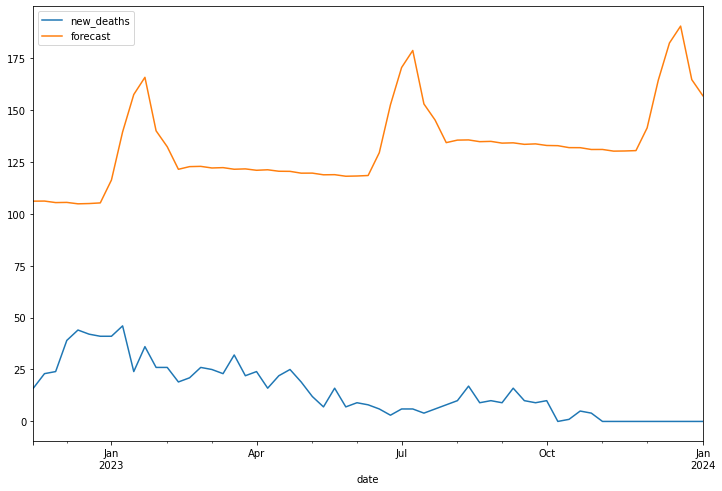

In [121]:
model=sm.tsa.statespace.SARIMAX(israel_train['new_deaths'],order=(2, 1, 2),seasonal_order=(2,1,1,12))
results=model.fit()
israel_test['forecast']=results.predict(start=141,end=202,dynamic=True)
israel_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [122]:
mae = mean_absolute_error(israel_test['new_deaths'], israel_test['forecast'])
mape = mean_absolute_percentage_error(israel_test['new_deaths'], israel_test['forecast'])
r2 = r2_score(israel_test['new_deaths'], israel_test['forecast'])
new_row = {'country': 'Israel', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [123]:
auto_model = auto_arima(israel_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(israel_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -648.339
Date:                Tue, 20 Feb 2024   AIC                           1304.677
Time:                        22:37:22   BIC                           1316.472
Sample:                    03-01-2020   HQIC                          1309.470
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.2294      4.450      2.074      0.038       0.508      17.951
ar.L1          1.5888      0.037     43.221      0.000       1.517       1.661
ar.L2         -0.7015      0.030    -23.265      0.0

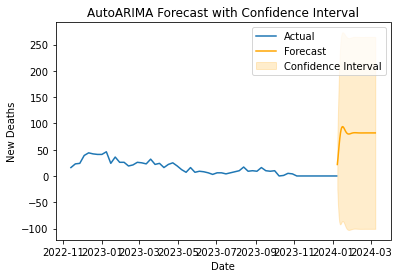

In [124]:
forecast_index = pd.date_range(israel_test.index[-1], periods=n_periods + 1, freq=israel_test.index.freq)[-n_periods:]

plt.plot(israel_test.index, israel_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [125]:
mae = mean_absolute_error(israel_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(israel_test['new_deaths'], forecast)
r2 = r2_score(israel_test['new_deaths'], forecast)
new_row = {'country': 'Israel', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Italy

## train/test split

In [127]:
italy = pd.read_csv('univariate_df_Italy.csv')
italy = italy.set_index('date')
italy.index = pd.to_datetime(italy.index)
italy = italy.drop('Unnamed: 0', axis=1)
italy.sort_index()
train_size = int(len(italy) * 0.7)
italy_train, italy_test = italy[0:train_size], italy[train_size:]
print(italy_train.shape, italy_test.shape)

(141, 1) (61, 1)


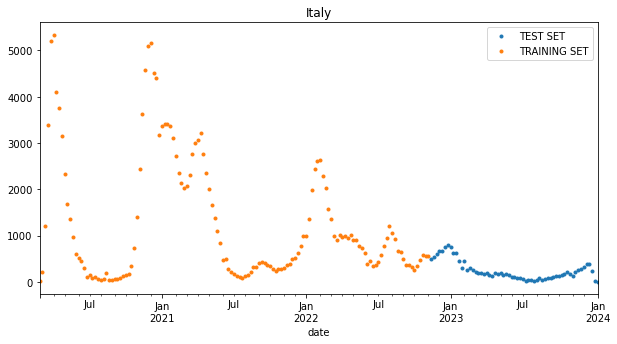

In [128]:
_ = italy_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(italy_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Italy', style='.')

## basic ARIMA (1,1,1)

In [129]:
model=ARIMA(italy_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -996.865
Date:                Tue, 20 Feb 2024   AIC                           1999.730
Time:                        22:38:35   BIC                           2008.555
Sample:                    03-01-2020   HQIC                          2003.316
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5657      0.050     11.270      0.000       0.467       0.664
ma.L1          0.1736      0.055      3.129      0.002       0.065       0.282
sigma2      8.929e+04   4917.554     18.157      0.000    7.96e+04    9.89e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               361.25
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

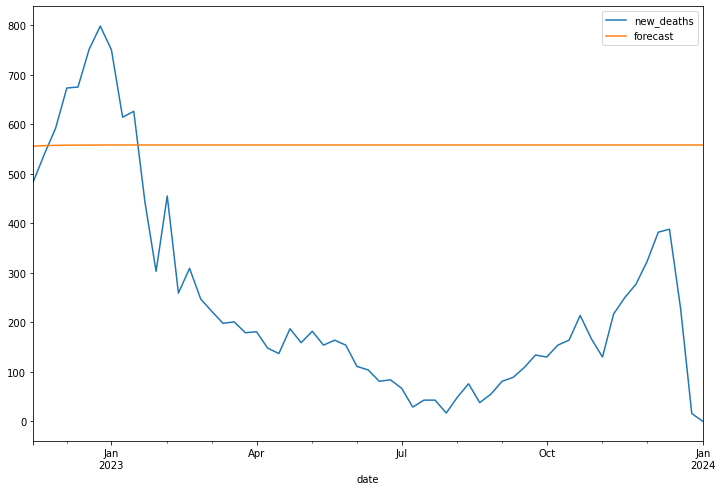

In [130]:
italy_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
italy_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [131]:
mae = mean_absolute_error(italy_test['new_deaths'], italy_test['forecast'])
mape = mean_absolute_percentage_error(italy_test['new_deaths'], italy_test['forecast'])
r2 = r2_score(italy_test['new_deaths'], italy_test['forecast'])
new_row = {'country': 'Italy', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [132]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(italy_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
12,4,1,1992.184762
8,3,1,1992.225577
6,2,3,1992.323028
9,3,2,1993.182796
4,2,1,1993.254258
13,4,2,1993.785595
10,3,3,1994.560279
11,3,4,1996.235335
1,1,2,1997.008670
5,2,2,1998.895276


In [133]:
model=ARIMA(italy_train['new_deaths'],order=(4,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -990.092
Date:                Tue, 20 Feb 2024   AIC                           1992.185
Time:                        22:39:29   BIC                           2009.835
Sample:                    03-01-2020   HQIC                          1999.357
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6774      0.057     29.474      0.000       1.566       1.789
ar.L2         -0.7428      0.091     -8.170      0.000      -0.921      -0.565
ar.L3         -0.1291      0.090     -1.433      0.152      -0.306       0.048
ar.L4          0.1372      0.046      2.997      0.003       0.047       0.227
ma.L1         -0.9983      0.579     -1.723      0.085      -2.134       0.137
sigma2      7.972e+04   4.44e+04      1.794      0.073   -7397.554    1.67e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               308.17
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                             1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

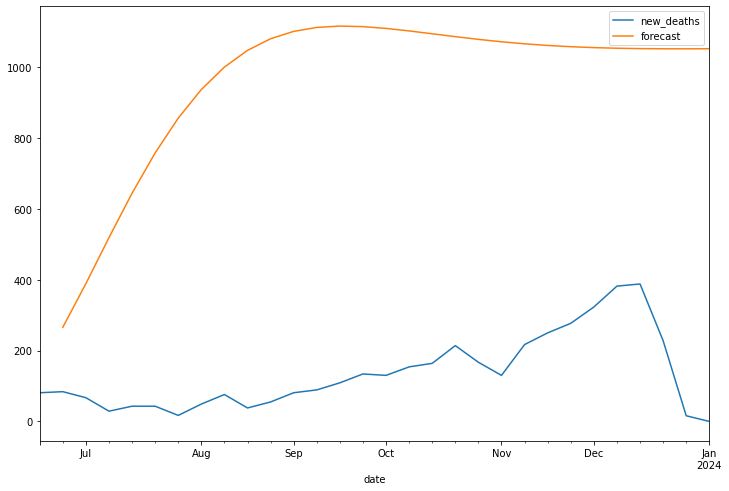

In [117]:
italy_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
italy_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [134]:
mae = mean_absolute_error(italy_test['new_deaths'], italy_test['forecast'])
mape = mean_absolute_percentage_error(italy_test['new_deaths'], italy_test['forecast'])
r2 = r2_score(italy_test['new_deaths'], italy_test['forecast'])
new_row = {'country': 'Italy', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [135]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(italy_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62533D+00    |proj g|=  9.97475D-02

At iterate    5    f=  6.56905D+00    |proj g|=  4.89655D-02

At iterate   10    f=  6.56609D+00    |proj g|=  5.62131D-04


 This problem is unconstrained.



At iterate   15    f=  6.56594D+00    |proj g|=  6.45763D-03

At iterate   20    f=  6.54937D+00    |proj g|=  9.09755D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   7.895D-06   6.549D+00
  F =   6.5492328955305119     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.57794D+00    |proj g|=  8.14614D-02

At iterate    5    f=  6.56611D+00    |proj g|=  1.02374D-03

At iterate   10    f=  6.56607D+00    |proj g|=  1.85155D-03

At iterate   15    f=  6.56296D+00    |proj g|=  2.21539D-02

At iterate   20    f=  6.55004D+00    |proj g|=  3.80265D-03

At iterate   25    f=  6.54929D+00    |proj g|=  1.29906D-03

At iterate   30    f=  6.54924D+00    |proj g|=  4.32354D-04

At iterate   35    f=  6.54907D+00    |proj g|=  5.06187D-03

At iterate   40    f=  6.54892D+00    |proj g|=  3.53084D-03

At iterate   45    f=  6.54880D+00    |proj g|=  2.04873D-03

At iterate   50    f=  6.54877D+00    |proj g|=  5.25304D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.59896D+00    |proj g|=  2.75585D-02

At iterate   10    f=  6.56745D+00    |proj g|=  1.93035D-02

At iterate   15    f=  6.56592D+00    |proj g|=  5.68043D-04

At iterate   20    f=  6.56441D+00    |proj g|=  9.92585D-03

At iterate   25    f=  6.54904D+00    |proj g|=  5.25165D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     37      1     0     0   9.281D-06   6.549D+00
  F =   6.5489269636987233     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.57995D+00    |proj g|=  9.70640D-02

At iterate    5    f=  6.56606D+00    |proj g|=  1.98674D-03

At iterate   10    f=  6.56602D+00    |proj g|=  1.49158D-03

At iterate   15    f=  6.56238D+00    |proj g|=  2.55008D-02

At iterate   20    f=  6.54864D+00    |proj g|=  2.26303D-02

At iterate   25    f=  6.54596D+00    |proj g|=  3.50089D-03

At iterate   30    f=  6.54321D+00    |proj g|=  4.70390D-03

At iterate   35    f=  6.54298D+00    |proj g|=  4.50112D-03

At iterate   40    f=  6.54265D+00    |proj g|=  3.60623D-04

At iterate   45    f=  6.54265D+00    |proj g|=  6.71421D-04

At iterate   50    f=  6.54262D+00    |proj g|=  1.40713D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.54820D+00    |proj g|=  6.64976D-02

At iterate   10    f=  6.53887D+00    |proj g|=  3.66473D-03

At iterate   15    f=  6.53819D+00    |proj g|=  3.76657D-04

At iterate   20    f=  6.53818D+00    |proj g|=  5.40644D-04

At iterate   25    f=  6.53805D+00    |proj g|=  9.78482D-03

At iterate   30    f=  6.53711D+00    |proj g|=  1.87382D-03

At iterate   35    f=  6.53704D+00    |proj g|=  5.46825D-03

At iterate   40    f=  6.53694D+00    |proj g|=  1.52634D-03

At iterate   45    f=  6.53693D+00    |proj g|=  1.35405D-03

At iterate   50    f=  6.53692D+00    |proj g|=  1.28491D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.53873D+00    |proj g|=  1.78839D-02

At iterate   10    f=  6.53823D+00    |proj g|=  7.55180D-04

At iterate   15    f=  6.53821D+00    |proj g|=  1.51467D-04

At iterate   20    f=  6.53820D+00    |proj g|=  3.98793D-03

At iterate   25    f=  6.53768D+00    |proj g|=  1.15381D-02

At iterate   30    f=  6.53686D+00    |proj g|=  2.01766D-03

At iterate   35    f=  6.53670D+00    |proj g|=  1.78715D-03

At iterate   40    f=  6.53650D+00    |proj g|=  1.66662D-03

At iterate   45    f=  6.53649D+00    |proj g|=  1.20923D-03

At iterate   50    f=  6.53645D+00    |proj g|=  1.66174D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.59760D+00    |proj g|=  7.85020D-02

At iterate   10    f=  6.57815D+00    |proj g|=  7.77174D-02

At iterate   15    f=  6.53891D+00    |proj g|=  1.06850D-02

At iterate   20    f=  6.53780D+00    |proj g|=  2.02102D-03

At iterate   25    f=  6.53773D+00    |proj g|=  1.92159D-04

At iterate   30    f=  6.53764D+00    |proj g|=  4.60117D-03

At iterate   35    f=  6.53644D+00    |proj g|=  1.96310D-03

At iterate   40    f=  6.53640D+00    |proj g|=  9.52446D-05

At iterate   45    f=  6.53640D+00    |proj g|=  4.07297D-04

At iterate   50    f=  6.53639D+00    |proj g|=  8.97786D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.54016D+00    |proj g|=  2.19338D-02

At iterate   10    f=  6.53840D+00    |proj g|=  5.76086D-03

At iterate   15    f=  6.53817D+00    |proj g|=  2.87052D-04

At iterate   20    f=  6.53817D+00    |proj g|=  1.31479D-03

At iterate   25    f=  6.53796D+00    |proj g|=  9.39716D-03

At iterate   30    f=  6.53339D+00    |proj g|=  7.57799D-03

At iterate   35    f=  6.53097D+00    |proj g|=  2.31598D-03

At iterate   40    f=  6.53015D+00    |proj g|=  5.31343D-03

At iterate   45    f=  6.52979D+00    |proj g|=  3.21689D-03

At iterate   50    f=  6.52978D+00    |proj g|=  9.40762D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.59282D+00    |proj g|=  9.44851D-02

At iterate   10    f=  6.56350D+00    |proj g|=  6.29261D-03

At iterate   15    f=  6.56170D+00    |proj g|=  4.96711D-02

At iterate   20    f=  6.55078D+00    |proj g|=  1.69414D-02

At iterate   25    f=  6.54573D+00    |proj g|=  8.26478D-03

At iterate   30    f=  6.54416D+00    |proj g|=  1.25532D-02

At iterate   35    f=  6.54189D+00    |proj g|=  7.09341D-03

At iterate   40    f=  6.53680D+00    |proj g|=  2.74305D-02

At iterate   45    f=  6.52500D+00    |proj g|=  4.14997D-03

At iterate   50    f=  6.52463D+00    |proj g|=  8.45567D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.56479D+00    |proj g|=  3.61684D-02

At iterate   10    f=  6.56316D+00    |proj g|=  6.31517D-03

At iterate   15    f=  6.55398D+00    |proj g|=  5.33793D-03

At iterate   20    f=  6.54657D+00    |proj g|=  2.16345D-02

At iterate   25    f=  6.54341D+00    |proj g|=  8.23833D-03

At iterate   30    f=  6.54179D+00    |proj g|=  1.24413D-03

At iterate   35    f=  6.53354D+00    |proj g|=  3.27074D-02

At iterate   40    f=  6.52494D+00    |proj g|=  1.84685D-03

At iterate   45    f=  6.52297D+00    |proj g|=  5.85086D-03

At iterate   50    f=  6.52218D+00    |proj g|=  4.03356D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.60026D+00    |proj g|=  2.88471D-02

At iterate   10    f=  6.59263D+00    |proj g|=  7.61291D-02

At iterate   15    f=  6.56408D+00    |proj g|=  6.02322D-03

At iterate   20    f=  6.56371D+00    |proj g|=  1.99118D-03

At iterate   25    f=  6.55437D+00    |proj g|=  4.44095D-02

At iterate   30    f=  6.54694D+00    |proj g|=  1.77051D-02

At iterate   35    f=  6.54438D+00    |proj g|=  3.15279D-03

At iterate   40    f=  6.54387D+00    |proj g|=  1.37827D-02

At iterate   45    f=  6.54148D+00    |proj g|=  6.35261D-03

At iterate   50    f=  6.53993D+00    |proj g|=  4.60868D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.56458D+00    |proj g|=  2.01561D-02

At iterate   10    f=  6.56303D+00    |proj g|=  4.26729D-03

At iterate   15    f=  6.55718D+00    |proj g|=  4.30459D-02

At iterate   20    f=  6.54854D+00    |proj g|=  3.06009D-02

At iterate   25    f=  6.54537D+00    |proj g|=  3.89956D-03

At iterate   30    f=  6.54450D+00    |proj g|=  1.00774D-02

At iterate   35    f=  6.54200D+00    |proj g|=  4.18582D-03

At iterate   40    f=  6.54090D+00    |proj g|=  2.02425D-02

At iterate   45    f=  6.52164D+00    |proj g|=  8.61168D-03

At iterate   50    f=  6.52070D+00    |proj g|=  7.04417D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.74328D+00    |proj g|=  4.80277D-01

At iterate    5    f=  6.53804D+00    |proj g|=  4.28729D-02

At iterate   10    f=  6.52950D+00    |proj g|=  3.11374D-03

At iterate   15    f=  6.52802D+00    |proj g|=  9.64151D-03

At iterate   20    f=  6.52659D+00    |proj g|=  1.63759D-03

At iterate   25    f=  6.52645D+00    |proj g|=  5.12309D-04

At iterate   30    f=  6.52463D+00    |proj g|=  3.07289D-02

At iterate   35    f=  6.52379D+00    |proj g|=  1.23798D-03

At iterate   40    f=  6.52375D+00    |proj g|=  6.66792D-04

At iterate   45    f=  6.52373D+00    |proj g|=  6.63906D-04

At iterate   50    f=  6.52373D+00    |proj g|=  1.60264D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.67417D+00    |proj g|=  4.43902D-01

At iterate    5    f=  6.53029D+00    |proj g|=  8.29592D-03

At iterate   10    f=  6.52936D+00    |proj g|=  1.28940D-03

At iterate   15    f=  6.52924D+00    |proj g|=  2.25627D-03

At iterate   20    f=  6.52913D+00    |proj g|=  2.15766D-04

At iterate   25    f=  6.52913D+00    |proj g|=  3.00075D-04

At iterate   30    f=  6.52910D+00    |proj g|=  2.25193D-03

At iterate   35    f=  6.52893D+00    |proj g|=  3.06891D-03

At iterate   40    f=  6.52888D+00    |proj g|=  7.79151D-04

At iterate   45    f=  6.52873D+00    |proj g|=  1.10358D-03

At iterate   50    f=  6.52851D+00    |proj g|=  2.00536D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.59128D+00    |proj g|=  4.34789D-02

At iterate   10    f=  6.54159D+00    |proj g|=  3.87065D-02

At iterate   15    f=  6.52845D+00    |proj g|=  3.33415D-03

At iterate   20    f=  6.52817D+00    |proj g|=  1.52722D-03

At iterate   25    f=  6.52796D+00    |proj g|=  1.78696D-03

At iterate   30    f=  6.52776D+00    |proj g|=  1.96552D-04

At iterate   35    f=  6.52776D+00    |proj g|=  7.10986D-05

At iterate   40    f=  6.52774D+00    |proj g|=  2.12517D-03

At iterate   45    f=  6.52751D+00    |proj g|=  9.37837D-04

At iterate   50    f=  6.52748D+00    |proj g|=  1.17388D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.53095D+00    |proj g|=  1.50532D-02

At iterate   10    f=  6.52944D+00    |proj g|=  3.15712D-03

At iterate   15    f=  6.52932D+00    |proj g|=  1.27803D-03

At iterate   20    f=  6.52904D+00    |proj g|=  4.71661D-03

At iterate   25    f=  6.52897D+00    |proj g|=  5.46234D-04

At iterate   30    f=  6.52891D+00    |proj g|=  3.28273D-03

At iterate   35    f=  6.52726D+00    |proj g|=  3.93137D-02

At iterate   40    f=  6.52380D+00    |proj g|=  7.64768D-03

At iterate   45    f=  6.52270D+00    |proj g|=  1.56645D-02

At iterate   50    f=  6.51987D+00    |proj g|=  2.10411D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [136]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
8,2,1,1,1,1851.944286
9,2,1,1,2,1853.255287
12,2,2,1,1,1853.691810
11,2,1,2,2,1854.837802
4,1,2,1,1,1855.411600
15,2,2,2,2,1856.604360
14,2,2,2,1,1856.749478
0,1,1,1,1,1856.883677
13,2,2,1,2,1857.039852
6,1,2,2,1,1857.261925


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03408D+00    |proj g|=  1.21148D+00

At iterate    5    f=  6.59282D+00    |proj g|=  9.44851D-02


 This problem is unconstrained.



At iterate   10    f=  6.56350D+00    |proj g|=  6.29261D-03

At iterate   15    f=  6.56170D+00    |proj g|=  4.96711D-02

At iterate   20    f=  6.55078D+00    |proj g|=  1.69414D-02

At iterate   25    f=  6.54573D+00    |proj g|=  8.26478D-03

At iterate   30    f=  6.54416D+00    |proj g|=  1.25532D-02

At iterate   35    f=  6.54189D+00    |proj g|=  7.09341D-03

At iterate   40    f=  6.53680D+00    |proj g|=  2.74305D-02

At iterate   45    f=  6.52500D+00    |proj g|=  4.14997D-03

At iterate   50    f=  6.52463D+00    |proj g|=  8.45567D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     65   

<AxesSubplot:xlabel='date'>

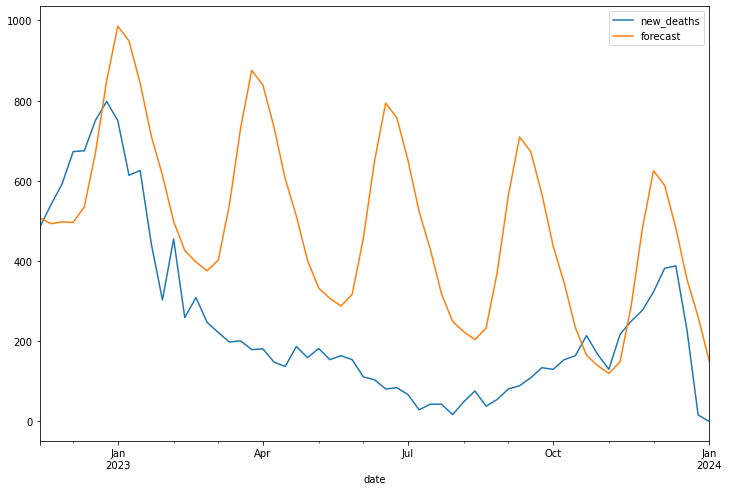

In [137]:
model=sm.tsa.statespace.SARIMAX(italy_train['new_deaths'],order=(2, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
italy_test['forecast']=results.predict(start=141,end=202,dynamic=True)
italy_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [138]:
mae = mean_absolute_error(italy_test['new_deaths'], italy_test['forecast'])
mape = mean_absolute_percentage_error(italy_test['new_deaths'], italy_test['forecast'])
r2 = r2_score(italy_test['new_deaths'], italy_test['forecast'])
new_row = {'country': 'Italy', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [139]:
auto_model = auto_arima(italy_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(italy_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  141
Model:             SARIMAX(3, 0, 0)x(2, 0, [1, 2], 12)   Log Likelihood                -993.435
Date:                                 Tue, 20 Feb 2024   AIC                           2004.871
Time:                                         22:42:53   BIC                           2031.410
Sample:                                     03-01-2020   HQIC                          2015.655
                                          - 11-06-2022                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.7998     26.332      1.322      0.186     -16.809      86

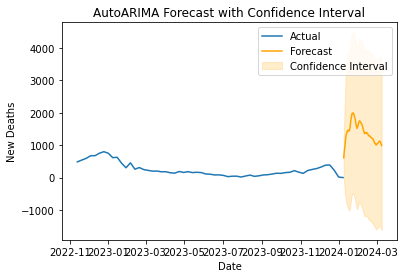

In [140]:
forecast_index = pd.date_range(italy_test.index[-1], periods=n_periods + 1, freq=italy_test.index.freq)[-n_periods:]

plt.plot(italy_test.index, italy_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [141]:
mae = mean_absolute_error(italy_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(italy_test['new_deaths'], forecast)
r2 = r2_score(italy_test['new_deaths'], forecast)
new_row = {'country': 'Italy', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# United States

## train/test split

In [143]:
us = pd.read_csv('us_diff.csv')
us = us.set_index('date')
us.index = pd.to_datetime(us.index)
us = us.drop('Unnamed: 0', axis=1)
us.sort_index()
train_size = int(len(us) * 0.7)
us_train, us_test = us[0:train_size], us[train_size:]
print(us_train.shape, us_test.shape)

(141, 1) (61, 1)


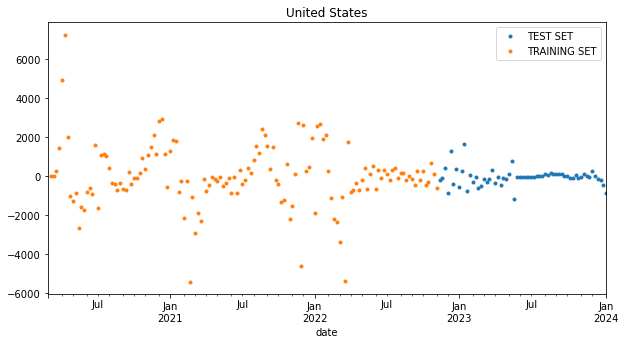

In [144]:
_ = us_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(us_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='United States', style='.')

## basic ARIMA (1,1,1)

In [145]:
model=ARIMA(us_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1224.766
Date:                Tue, 20 Feb 2024   AIC                           2455.532
Time:                        22:43:41   BIC                           2464.357
Sample:                    03-01-2020   HQIC                          2459.118
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3069      0.095     -3.230      0.001      -0.493      -0.121
ma.L1         -0.2966      0.101     -2.934      0.003      -0.495      -0.098
sigma2      2.254e+06   1.68e+05     13.422      0.000    1.92e+06    2.58e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                59.06
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.34
Prob(H) (two-sided):                  0.10   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

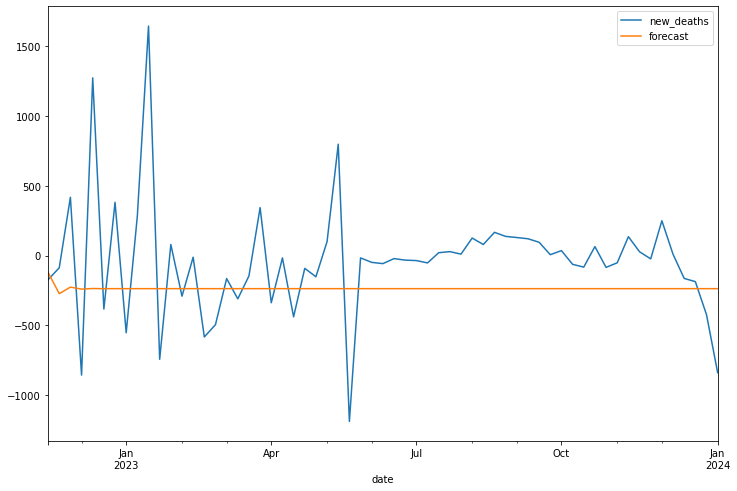

In [146]:
us_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
us_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [147]:
mae = mean_absolute_error(us_test['new_deaths'], us_test['forecast'])
mape = mean_absolute_percentage_error(us_test['new_deaths'], us_test['forecast'])
r2 = r2_score(us_test['new_deaths'], us_test['forecast'])
new_row = {'country': 'US', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [149]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(us_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
13,4,2,2441.818293
4,2,1,2441.886909
6,2,3,2442.678960
2,1,3,2442.958045
8,3,1,2443.865719
5,2,2,2443.872615
3,1,4,2444.764439
11,3,4,2445.006710
14,4,3,2445.126697
12,4,1,2445.152507


In [150]:
model=ARIMA(us_train['new_deaths'],order=(4,1,2))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -1213.909
Date:                Tue, 20 Feb 2024   AIC                           2441.818
Time:                        23:00:28   BIC                           2462.410
Sample:                    03-01-2020   HQIC                          2450.186
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1423      0.143      7.981      0.000       0.862       1.423
ar.L2          0.0908      0.097      0.940      0.347      -0.099       0.280
ar.L3         -0.2416      0.157     -1.539      0.124      -0.549       0.066
ar.L4         -0.0980      0.100     -0.977      0.329      -0.294       0.099
ma.L1         -1.9064      0.134    -14.257      0.000      -2.168      -1.644
ma.L2          0.9064      0.134      6.779      0.000       0.644       1.168
sigma2      1.924e+06   1.32e-07   1.46e+13      0.000    1.92e+06    1.92e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                56.94
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.30
Prob(H) (two-sided):                  0.11   Kurtosis:                         6.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.64e+29. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='date'>

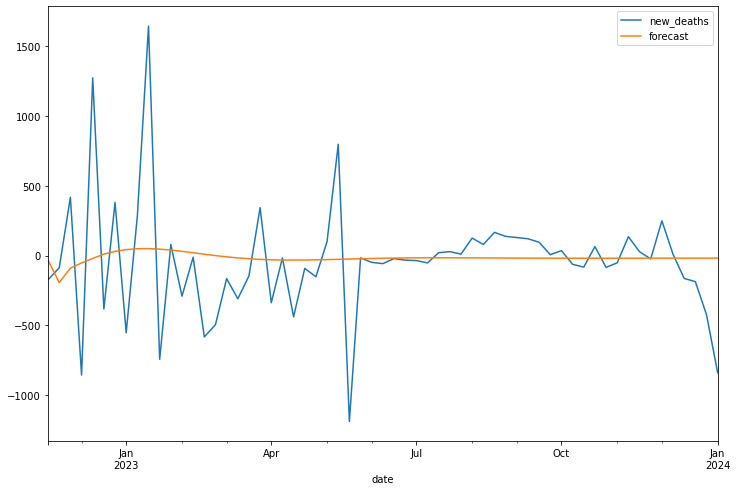

In [151]:
us_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
us_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [152]:
mae = mean_absolute_error(us_test['new_deaths'], us_test['forecast'])
mape = mean_absolute_percentage_error(us_test['new_deaths'], us_test['forecast'])
r2 = r2_score(us_test['new_deaths'], us_test['forecast'])
new_row = {'country': 'US', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [153]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(us_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.06224D+00    |proj g|=  5.26807D-02

At iterate    5    f=  8.05280D+00    |proj g|=  1.46474D-03


 This problem is unconstrained.



At iterate   10    f=  8.05279D+00    |proj g|=  5.53617D-04

At iterate   15    f=  8.05193D+00    |proj g|=  8.46969D-03

At iterate   20    f=  8.00103D+00    |proj g|=  8.53174D-02

At iterate   25    f=  7.98851D+00    |proj g|=  3.52969D-03

At iterate   30    f=  7.98215D+00    |proj g|=  5.96759D-03

At iterate   35    f=  7.98144D+00    |proj g|=  1.94867D-04

At iterate   40    f=  7.98137D+00    |proj g|=  6.42893D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     53      1     0     0   7.909D-05   7.981D+00
  F =   7.9813544898151338     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  8.05658D+00    |proj g|=  4.97547D-03

At iterate   10    f=  8.05595D+00    |proj g|=  1.44637D-02

At iterate   15    f=  8.05194D+00    |proj g|=  6.50273D-03

At iterate   20    f=  8.05165D+00    |proj g|=  2.12360D-04

At iterate   25    f=  8.05157D+00    |proj g|=  3.65479D-03

At iterate   30    f=  8.04448D+00    |proj g|=  8.07073D-02

At iterate   35    f=  7.96497D+00    |proj g|=  1.45226D-02

At iterate   40    f=  7.96028D+00    |proj g|=  1.30031D-02

At iterate   45    f=  7.95840D+00    |proj g|=  6.19123D-03

At iterate   50    f=  7.95832D+00    |proj g|=  1.72694D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.05340D+00    |proj g|=  3.86474D-02

At iterate   10    f=  8.05134D+00    |proj g|=  6.02746D-04

At iterate   15    f=  8.05133D+00    |proj g|=  1.41388D-03

At iterate   20    f=  8.05058D+00    |proj g|=  2.11899D-02

At iterate   25    f=  8.00014D+00    |proj g|=  1.53185D-01

At iterate   30    f=  7.95399D+00    |proj g|=  1.29612D-02

At iterate   35    f=  7.95007D+00    |proj g|=  4.15939D-03

At iterate   40    f=  7.94962D+00    |proj g|=  5.10190D-04

At iterate   45    f=  7.94956D+00    |proj g|=  1.31012D-03

At iterate   50    f=  7.94954D+00    |proj g|=  1.28570D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07044D+00    |proj g|=  7.88094D-02

At iterate    5    f=  8.05064D+00    |proj g|=  1.03530D-02

At iterate   10    f=  8.05029D+00    |proj g|=  6.81743D-04

At iterate   15    f=  8.05021D+00    |proj g|=  7.62800D-04

At iterate   20    f=  8.05020D+00    |proj g|=  3.58371D-04

At iterate   25    f=  8.04998D+00    |proj g|=  5.64105D-03

At iterate   30    f=  7.98195D+00    |proj g|=  1.57747D-01

At iterate   35    f=  7.95204D+00    |proj g|=  1.59837D-03

At iterate   40    f=  7.95203D+00    |proj g|=  1.18725D-03

At iterate   45    f=  7.95198D+00    |proj g|=  1.62889D-03

At iterate   50    f=  7.95197D+00    |proj g|=  1.12313D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.00699D+00    |proj g|=  1.65255D-03

At iterate   10    f=  8.00686D+00    |proj g|=  2.65308D-04

At iterate   15    f=  8.00684D+00    |proj g|=  1.82936D-03

At iterate   20    f=  8.00482D+00    |proj g|=  2.63352D-02

At iterate   25    f=  7.95845D+00    |proj g|=  2.19854D-02

At iterate   30    f=  7.95437D+00    |proj g|=  1.02125D-02

At iterate   35    f=  7.95217D+00    |proj g|=  5.30097D-03

At iterate   40    f=  7.95190D+00    |proj g|=  1.15183D-03

At iterate   45    f=  7.95186D+00    |proj g|=  4.06908D-04

At iterate   50    f=  7.95186D+00    |proj g|=  3.01191D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.01134D+00    |proj g|=  2.65591D-03

At iterate   10    f=  8.01066D+00    |proj g|=  6.07400D-03

At iterate   15    f=  8.00648D+00    |proj g|=  9.95758D-03

At iterate   20    f=  8.00522D+00    |proj g|=  1.40306D-03

At iterate   25    f=  8.00521D+00    |proj g|=  3.12444D-04

At iterate   30    f=  8.00518D+00    |proj g|=  3.63390D-03

At iterate   35    f=  8.00043D+00    |proj g|=  3.70703D-02

At iterate   40    f=  7.96867D+00    |proj g|=  3.46711D-02

At iterate   45    f=  7.95849D+00    |proj g|=  5.66236D-02

At iterate   50    f=  7.95176D+00    |proj g|=  1.62295D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.00792D+00    |proj g|=  3.51455D-02

At iterate   10    f=  8.00507D+00    |proj g|=  9.09302D-04

At iterate   15    f=  8.00505D+00    |proj g|=  1.84523D-04

At iterate   20    f=  8.00501D+00    |proj g|=  3.71843D-03

At iterate   25    f=  8.00089D+00    |proj g|=  4.36145D-02

At iterate   30    f=  7.95570D+00    |proj g|=  1.64871D-02

At iterate   35    f=  7.95020D+00    |proj g|=  1.68732D-03

At iterate   40    f=  7.94975D+00    |proj g|=  8.51253D-03

At iterate   45    f=  7.94947D+00    |proj g|=  6.40148D-03

At iterate   50    f=  7.94941D+00    |proj g|=  3.40390D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.00450D+00    |proj g|=  1.39848D-02

At iterate   10    f=  8.00379D+00    |proj g|=  1.37277D-03

At iterate   15    f=  8.00376D+00    |proj g|=  1.02673D-03

At iterate   20    f=  8.00369D+00    |proj g|=  1.86268D-04

At iterate   25    f=  8.00368D+00    |proj g|=  1.50301D-03

At iterate   30    f=  8.00285D+00    |proj g|=  5.27986D-03

At iterate   35    f=  7.99313D+00    |proj g|=  4.36271D-02

At iterate   40    f=  7.95272D+00    |proj g|=  2.97265D-02

At iterate   45    f=  7.95029D+00    |proj g|=  1.44431D-02

At iterate   50    f=  7.94650D+00    |proj g|=  5.45292D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.04726D+00    |proj g|=  2.86456D-03

At iterate   10    f=  8.04722D+00    |proj g|=  1.17059D-03

At iterate   15    f=  8.04714D+00    |proj g|=  3.13127D-04

At iterate   20    f=  8.04712D+00    |proj g|=  3.01804D-03

At iterate   25    f=  8.04442D+00    |proj g|=  3.63952D-02

At iterate   30    f=  8.01568D+00    |proj g|=  6.84019D-02

At iterate   35    f=  7.95709D+00    |proj g|=  5.68609D-02

At iterate   40    f=  7.95168D+00    |proj g|=  1.00340D-02

At iterate   45    f=  7.95107D+00    |proj g|=  4.88588D-03

At iterate   50    f=  7.95032D+00    |proj g|=  4.92215D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.05061D+00    |proj g|=  3.06553D-03

At iterate   10    f=  8.05031D+00    |proj g|=  1.09875D-02

At iterate   15    f=  8.04617D+00    |proj g|=  2.65222D-03

At iterate   20    f=  8.04603D+00    |proj g|=  2.94233D-03

At iterate   25    f=  8.04573D+00    |proj g|=  3.31129D-04

At iterate   30    f=  8.04572D+00    |proj g|=  9.74189D-04

At iterate   35    f=  8.04519D+00    |proj g|=  1.02720D-02

At iterate   40    f=  7.97780D+00    |proj g|=  3.89271D-02

At iterate   45    f=  7.96406D+00    |proj g|=  1.45810D-03

At iterate   50    f=  7.96368D+00    |proj g|=  1.07205D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.04779D+00    |proj g|=  3.63580D-02

At iterate   10    f=  8.04561D+00    |proj g|=  2.37737D-04

At iterate   15    f=  8.04556D+00    |proj g|=  3.06210D-03

At iterate   20    f=  8.04555D+00    |proj g|=  5.30381D-04

At iterate   25    f=  8.04543D+00    |proj g|=  5.51497D-03

At iterate   30    f=  8.01729D+00    |proj g|=  5.17552D-02

At iterate   35    f=  7.94983D+00    |proj g|=  1.09926D-02

At iterate   40    f=  7.94696D+00    |proj g|=  4.85658D-02

At iterate   45    f=  7.92526D+00    |proj g|=  3.95088D-02

At iterate   50    f=  7.91106D+00    |proj g|=  7.62689D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.04502D+00    |proj g|=  1.00524D-02

At iterate   10    f=  8.04478D+00    |proj g|=  1.43225D-03

At iterate   15    f=  8.04464D+00    |proj g|=  2.26438D-03

At iterate   20    f=  8.04463D+00    |proj g|=  5.41059D-04

At iterate   25    f=  8.04457D+00    |proj g|=  3.52300D-04

At iterate   30    f=  8.04450D+00    |proj g|=  1.40498D-03

At iterate   35    f=  8.03300D+00    |proj g|=  5.35709D-02

At iterate   40    f=  7.95286D+00    |proj g|=  1.68857D-02

At iterate   45    f=  7.95202D+00    |proj g|=  8.46473D-03

At iterate   50    f=  7.95049D+00    |proj g|=  1.27556D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.00124D+00    |proj g|=  6.14636D-03

At iterate   10    f=  8.00100D+00    |proj g|=  4.66414D-04

At iterate   15    f=  8.00088D+00    |proj g|=  2.57315D-03

At iterate   20    f=  8.00083D+00    |proj g|=  1.90521D-03

At iterate   25    f=  8.00081D+00    |proj g|=  2.54087D-04

At iterate   30    f=  8.00080D+00    |proj g|=  1.09300D-03

At iterate   35    f=  8.00025D+00    |proj g|=  1.14839D-02

At iterate   40    f=  7.97804D+00    |proj g|=  4.86535D-02

At iterate   45    f=  7.95277D+00    |proj g|=  9.55647D-03

At iterate   50    f=  7.95186D+00    |proj g|=  1.69014D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.00501D+00    |proj g|=  1.57903D-03

At iterate   10    f=  8.00439D+00    |proj g|=  1.23340D-02

At iterate   15    f=  7.99904D+00    |proj g|=  5.43300D-03

At iterate   20    f=  7.99888D+00    |proj g|=  1.19741D-03

At iterate   25    f=  7.99887D+00    |proj g|=  1.23062D-03

At iterate   30    f=  7.99878D+00    |proj g|=  4.15440D-04

At iterate   35    f=  7.99878D+00    |proj g|=  5.01872D-04

At iterate   40    f=  7.99873D+00    |proj g|=  2.60688D-03

At iterate   45    f=  7.99775D+00    |proj g|=  1.72948D-02

At iterate   50    f=  7.98145D+00    |proj g|=  4.67777D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.00620D+00    |proj g|=  4.29053D-02

At iterate   10    f=  7.99899D+00    |proj g|=  3.74792D-03

At iterate   15    f=  7.99893D+00    |proj g|=  5.98869D-04

At iterate   20    f=  7.99877D+00    |proj g|=  1.31750D-03

At iterate   25    f=  7.99873D+00    |proj g|=  8.48829D-04

At iterate   30    f=  7.99872D+00    |proj g|=  5.20427D-04

At iterate   35    f=  7.99780D+00    |proj g|=  1.71587D-02

At iterate   40    f=  7.95106D+00    |proj g|=  2.15922D-02

At iterate   45    f=  7.94966D+00    |proj g|=  1.55641D-04

At iterate   50    f=  7.94964D+00    |proj g|=  2.87831D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.99834D+00    |proj g|=  1.57812D-02

At iterate   10    f=  7.99780D+00    |proj g|=  1.14729D-03

At iterate   15    f=  7.99763D+00    |proj g|=  1.95882D-03

At iterate   20    f=  7.99755D+00    |proj g|=  2.09663D-04

At iterate   25    f=  7.99754D+00    |proj g|=  1.46352D-03

At iterate   30    f=  7.99744D+00    |proj g|=  5.82525D-04

At iterate   35    f=  7.99742D+00    |proj g|=  6.31958D-04

At iterate   40    f=  7.99735D+00    |proj g|=  8.51489D-03

At iterate   45    f=  7.99675D+00    |proj g|=  2.38632D-03

At iterate   50    f=  7.97991D+00    |proj g|=  5.78385D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [154]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
10,2,1,2,1,2244.917564
2,1,1,2,1,2253.771452
8,2,1,1,1,2253.990732
4,1,2,1,1,2254.424103
6,1,2,2,1,2255.733736
1,1,1,1,2,2256.247104
5,1,2,1,2,2256.397635
12,2,2,1,1,2256.425740
3,1,1,2,2,2256.455661
7,1,2,2,2,2256.912222


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.06655D+00    |proj g|=  6.59416D-02

At iterate    5    f=  8.04779D+00    |proj g|=  3.63580D-02

At iterate   10    f=  8.04561D+00    |proj g|=  2.37737D-04

At iterate   15    f=  8.04556D+00    |proj g|=  3.06210D-03

At iterate   20    f=  8.04555D+00    |proj g|=  5.30381D-04

At iterate   25    f=  8.04543D+00    |proj g|=  5.51497D-03

At iterate   30    f=  8.01729D+00    |proj g|=  5.17552D-02

At iterate   35    f=  7.94983D+00    |proj g|=  1.09926D-02

At iterate   40    f=  7.94696D+00    |proj g|=  4.85658D-02

At iterate   45    f=  7.92526D+00    |proj g|=  3.95088D-02

At iterate   50    f=  7.91106D+00    |proj g|=  7.62689D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<AxesSubplot:xlabel='date'>

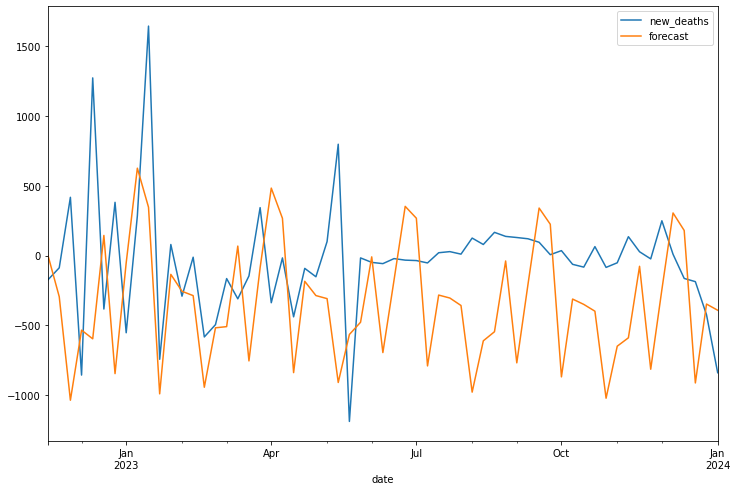

In [155]:
model=sm.tsa.statespace.SARIMAX(us_train['new_deaths'],order=(2, 1, 1),seasonal_order=(2,1,1,12))
results=model.fit()
us_test['forecast']=results.predict(start=141,end=202,dynamic=True)
us_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [156]:
mae = mean_absolute_error(us_test['new_deaths'], us_test['forecast'])
mape = mean_absolute_percentage_error(us_test['new_deaths'], us_test['forecast'])
r2 = r2_score(us_test['new_deaths'], us_test['forecast'])
new_row = {'country': 'US', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [157]:
# need un-differenced data
us = pd.read_csv('univariate_df_United_states.csv')
us = us.set_index('date')
us.index = pd.to_datetime(us.index)
us = us.drop('Unnamed: 0', axis=1)
us = us.drop('diff1', axis=1)
us.sort_index()
train_size = int(len(us) * 0.7)
us_train, us_test = us[0:train_size], us[train_size:]
print(us_train.shape, us_test.shape)

(141, 1) (61, 1)


In [158]:
auto_model = auto_arima(us_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(us_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1218.307
Date:                Tue, 20 Feb 2024   AIC                           2448.615
Time:                        23:02:27   BIC                           2466.308
Sample:                    03-01-2020   HQIC                          2455.805
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    512.5092    157.772      3.248      0.001     203.282     821.737
ar.L1          1.6825      0.092     18.379      0.000       1.503       1.862
ar.L2         -0.7485      0.086     -8.746      0.0

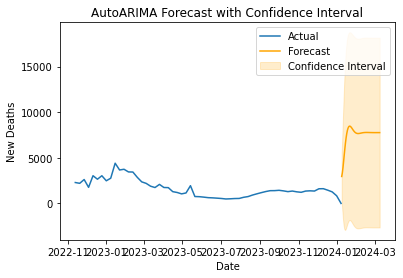

In [159]:
forecast_index = pd.date_range(us_test.index[-1], periods=n_periods + 1, freq=us_test.index.freq)[-n_periods:]

plt.plot(us_test.index, us_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [160]:
mae = mean_absolute_error(us_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(us_test['new_deaths'], forecast)
r2 = r2_score(us_test['new_deaths'], forecast)
new_row = {'country': 'US', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Czechia

## train/test split

In [162]:
czechia = pd.read_csv('czechia_diff.csv')
czechia = czechia.set_index('date')
czechia.index = pd.to_datetime(czechia.index)
czechia = czechia.drop('Unnamed: 0', axis=1)
czechia.sort_index()
train_size = int(len(czechia) * 0.7)
czechia_train, czechia_test = czechia[0:train_size], czechia[train_size:]
print(czechia_train.shape, czechia_test.shape)

(141, 1) (61, 1)


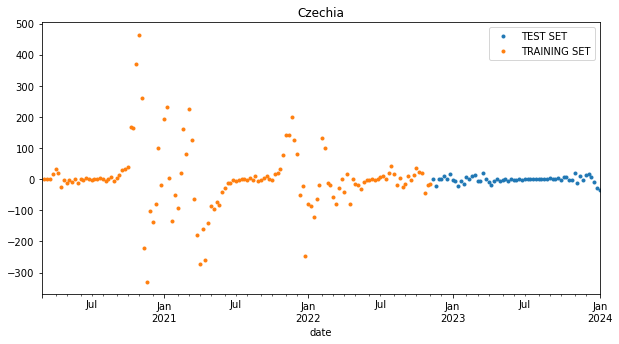

In [163]:
_ = czechia_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(czechia_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Czechia', style='.')

## basic ARIMA (1,1,1)

In [164]:
model=ARIMA(czechia_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -818.270
Date:                Tue, 20 Feb 2024   AIC                           1642.541
Time:                        23:03:33   BIC                           1651.366
Sample:                    03-01-2020   HQIC                          1646.127
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6602      0.306     -2.161      0.031      -1.259      -0.061
ma.L1          0.7426      0.281      2.640      0.008       0.191       1.294
sigma2      6786.2015    443.226     15.311      0.000    5917.495    7654.908
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               417.18
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

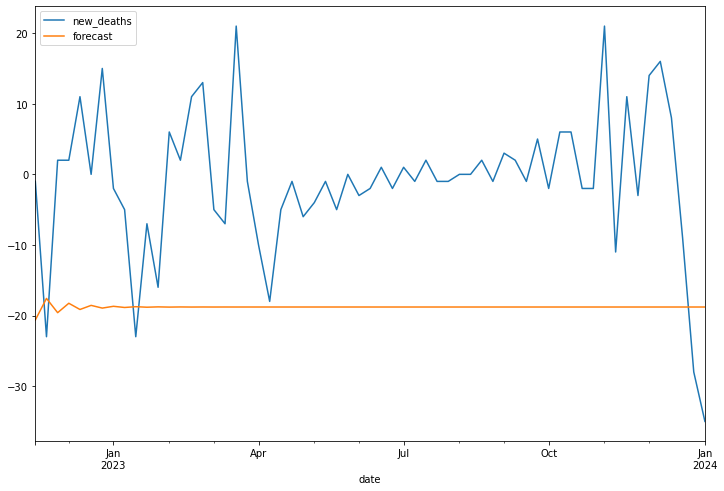

In [166]:
czechia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
czechia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [167]:
mae = mean_absolute_error(czechia_test['new_deaths'], czechia_test['forecast'])
mape = mean_absolute_percentage_error(czechia_test['new_deaths'], czechia_test['forecast'])
r2 = r2_score(czechia_test['new_deaths'], czechia_test['forecast'])
new_row = {'country': 'Czechia', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [168]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(czechia_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
12,4,1,1612.744618
5,2,2,1613.325784
13,4,2,1614.661138
8,3,1,1615.538389
4,2,1,1615.647746
14,4,3,1616.057205
3,1,4,1616.806478
10,3,3,1616.889974
1,1,2,1617.576418
7,2,4,1617.977472


In [169]:
model=ARIMA(czechia_train['new_deaths'],order=(4,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -800.372
Date:                Tue, 20 Feb 2024   AIC                           1612.745
Time:                        23:04:31   BIC                           1630.394
Sample:                    03-01-2020   HQIC                          1619.917
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7750      0.064     12.084      0.000       0.649       0.901
ar.L2         -0.1672      0.070     -2.401      0.016      -0.304      -0.031
ar.L3          0.0242      0.089      0.271      0.786      -0.151       0.199
ar.L4         -0.1825      0.075     -2.438      0.015      -0.329      -0.036
ma.L1         -0.9999      7.788     -0.128      0.898     -16.265      14.265
sigma2      5076.5091   3.94e+04      0.129      0.898   -7.22e+04    8.23e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               166.02
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

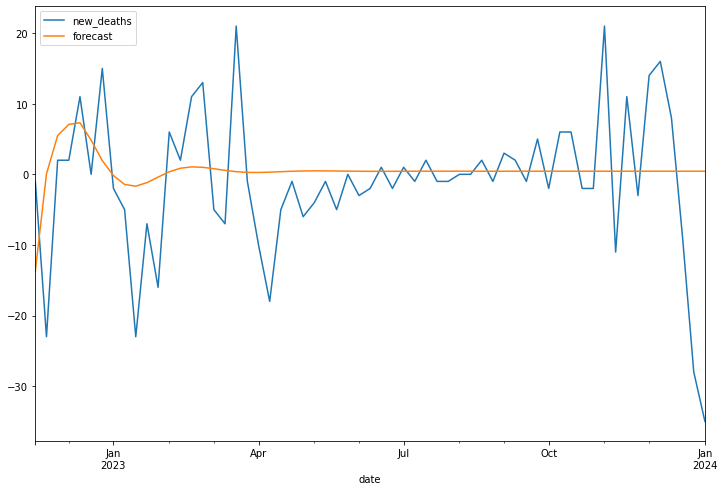

In [170]:
czechia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
czechia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [171]:
mae = mean_absolute_error(czechia_test['new_deaths'], czechia_test['forecast'])
mape = mean_absolute_percentage_error(czechia_test['new_deaths'], czechia_test['forecast'])
r2 = r2_score(czechia_test['new_deaths'], czechia_test['forecast'])
new_row = {'country': 'Czechia', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [172]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(czechia_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.52624D+00    |proj g|=  9.41226D-02

At iterate    5    f=  5.49788D+00    |proj g|=  5.04077D-03


 This problem is unconstrained.



At iterate   10    f=  5.49143D+00    |proj g|=  1.20867D-02

At iterate   15    f=  5.41063D+00    |proj g|=  1.00849D-01

At iterate   20    f=  5.40205D+00    |proj g|=  2.61374D-03

At iterate   25    f=  5.40155D+00    |proj g|=  4.81355D-04
  ys=-2.207E-02  -gs= 1.065E-03 BFGS update SKIPPED

At iterate   30    f=  5.38559D+00    |proj g|=  4.68776D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     55      1     1     0   1.104D-06   5.386D+00
  F =   5.3855415066930004     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50800D+00    |proj g|=  7.17583D-02

At iterate    5    f=  5.49873D+00    |proj g|=  6.79180D-03

At iterate   10    f=  5.48582D+00    |proj g|=  8.13161D-03

At iterate   15    f=  5.40856D+00    |proj g|=  8.41973D-03

At iterate   20    f=  5.40379D+00    |proj g|=  4.48504D-04

At iterate   25    f=  5.40371D+00    |proj g|=  1.31418D-04

At iterate   30    f=  5.40370D+00    |proj g|=  3.80870D-05

At iterate   35    f=  5.40370D+00    |proj g|=  3.17698D-04
  ys=-1.125E-01  -gs= 1.253E-04 BFGS update SKIPPED

At iterate   40    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of ac

 This problem is unconstrained.



At iterate    5    f=  5.49509D+00    |proj g|=  1.85434D-02

At iterate   10    f=  5.49277D+00    |proj g|=  8.95392D-03

At iterate   15    f=  5.47866D+00    |proj g|=  4.49179D-02

At iterate   20    f=  5.40016D+00    |proj g|=  3.38156D-02

At iterate   25    f=  5.39689D+00    |proj g|=  9.11210D-03

At iterate   30    f=  5.39658D+00    |proj g|=  2.17097D-03

At iterate   35    f=  5.39653D+00    |proj g|=  5.03309D-04

At iterate   40    f=  5.39652D+00    |proj g|=  3.21012D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     49      1     0     0   5.565D-06   5.397D+00
  F =   5.39651916670

 This problem is unconstrained.



At iterate    5    f=  5.49722D+00    |proj g|=  1.69027D-02

At iterate   10    f=  5.49500D+00    |proj g|=  2.12784D-02

At iterate   15    f=  5.48272D+00    |proj g|=  4.31348D-02

At iterate   20    f=  4.94555D+00    |proj g|=  4.34783D+05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     71      2     0     0   4.348D+05   4.946D+00
  F =   4.9455519203597103     

ABNORMAL_TERMINATION_IN_LNSRCH                              
1 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.64163D+00    |proj g|=  3.09540D-01


 This problem is unconstrained.



At iterate    5    f=  5.44495D+00    |proj g|=  1.28416D-02

At iterate   10    f=  5.43872D+00    |proj g|=  1.28913D-02

At iterate   15    f=  5.34024D+00    |proj g|=  4.23003D-02

At iterate   20    f=  5.31574D+00    |proj g|=  9.16228D-03

At iterate   25    f=  5.31454D+00    |proj g|=  4.26627D-04

At iterate   30    f=  5.31443D+00    |proj g|=  3.61148D-04

At iterate   35    f=  5.31442D+00    |proj g|=  7.24880D-05

At iterate   40    f=  5.31442D+00    |proj g|=  8.17336D-05

At iterate   45    f=  5.31442D+00    |proj g|=  5.36629D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     56   

 This problem is unconstrained.



At iterate    5    f=  5.44536D+00    |proj g|=  1.68125D-02

At iterate   10    f=  5.43845D+00    |proj g|=  1.03682D-02

At iterate   15    f=  5.31625D+00    |proj g|=  2.54673D-02

At iterate   20    f=  5.31473D+00    |proj g|=  1.87315D-03

At iterate   25    f=  5.31430D+00    |proj g|=  8.12160D-04

At iterate   30    f=  5.31424D+00    |proj g|=  5.59699D-04

At iterate   35    f=  5.31423D+00    |proj g|=  4.59633D-04

At iterate   40    f=  5.31423D+00    |proj g|=  6.70628D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     49      1     0     0   6.801D-06   5.314D+00
  F =   5.31422481577

 This problem is unconstrained.



At iterate    5    f=  5.44141D+00    |proj g|=  1.88783D-02

At iterate   10    f=  5.43671D+00    |proj g|=  9.74652D-03

At iterate   15    f=  5.39072D+00    |proj g|=  8.54581D-02

At iterate   20    f=  5.32082D+00    |proj g|=  2.36651D-02

At iterate   25    f=  5.30738D+00    |proj g|=  1.35526D-03

At iterate   30    f=  5.30709D+00    |proj g|=  1.91057D-03

At iterate   35    f=  5.30703D+00    |proj g|=  1.33740D-03

At iterate   40    f=  5.30702D+00    |proj g|=  2.71743D-04

At iterate   45    f=  5.30701D+00    |proj g|=  1.57441D-04

At iterate   50    f=  5.30701D+00    |proj g|=  7.72477D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.44379D+00    |proj g|=  6.85114D-03

At iterate   10    f=  5.43567D+00    |proj g|=  7.31033D-03

At iterate   15    f=  5.40705D+00    |proj g|=  6.12503D-02

At iterate   20    f=  5.33221D+00    |proj g|=  8.06087D-02

At iterate   25    f=  5.31355D+00    |proj g|=  5.06265D-03

At iterate   30    f=  5.31098D+00    |proj g|=  5.00988D-03

At iterate   35    f=  5.31093D+00    |proj g|=  2.50695D-04

At iterate   40    f=  5.31085D+00    |proj g|=  2.27375D-03

At iterate   45    f=  5.31077D+00    |proj g|=  6.30424D-04

At iterate   50    f=  5.31076D+00    |proj g|=  5.39919D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.45694D+00    |proj g|=  1.73232D-02

At iterate   10    f=  5.44715D+00    |proj g|=  7.48676D-03

At iterate   15    f=  5.32326D+00    |proj g|=  9.61317D-02

At iterate   20    f=  5.31064D+00    |proj g|=  1.30873D-02

At iterate   25    f=  5.30861D+00    |proj g|=  2.25148D-03

At iterate   30    f=  5.30845D+00    |proj g|=  6.83726D-04

At iterate   35    f=  5.30844D+00    |proj g|=  8.10712D-04

At iterate   40    f=  5.30844D+00    |proj g|=  1.05802D-04

At iterate   45    f=  5.30844D+00    |proj g|=  5.60028D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     55   

 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.47987D+00    |proj g|=  5.83410D-02

At iterate    5    f=  5.45531D+00    |proj g|=  3.00945D-02

At iterate   10    f=  5.44678D+00    |proj g|=  4.10619D-03

At iterate   15    f=  5.31561D+00    |proj g|=  5.16466D-02

At iterate   20    f=  5.30905D+00    |proj g|=  1.87785D-04

At iterate   25    f=  5.30900D+00    |proj g|=  5.11197D-03

At iterate   30    f=  5.30884D+00    |proj g|=  1.31119D-03

At iterate   35    f=  5.30775D+00    |proj g|=  1.48386D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

 

 This problem is unconstrained.



At iterate    5    f=  5.45841D+00    |proj g|=  8.16118D-02

At iterate   10    f=  5.44800D+00    |proj g|=  9.12396D-03

At iterate   15    f=  5.43018D+00    |proj g|=  4.05606D-02

At iterate   20    f=  5.31731D+00    |proj g|=  8.33464D-02

At iterate   25    f=  5.30222D+00    |proj g|=  2.35020D-02

At iterate   30    f=  5.30107D+00    |proj g|=  2.80306D-03

At iterate   35    f=  5.30097D+00    |proj g|=  9.74240D-04

At iterate   40    f=  5.30095D+00    |proj g|=  5.98330D-04

At iterate   45    f=  5.30094D+00    |proj g|=  1.63754D-04

At iterate   50    f=  5.30094D+00    |proj g|=  5.71942D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.45916D+00    |proj g|=  2.57252D-02

At iterate   10    f=  5.44803D+00    |proj g|=  9.17070D-03

At iterate   15    f=  5.42490D+00    |proj g|=  1.07847D-01

At iterate   20    f=  5.32717D+00    |proj g|=  3.85271D-02

At iterate   25    f=  5.31165D+00    |proj g|=  2.64363D-02

At iterate   30    f=  5.30880D+00    |proj g|=  1.34567D-02

At iterate   35    f=  5.30489D+00    |proj g|=  1.09224D-02

At iterate   40    f=  5.30460D+00    |proj g|=  1.49917D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     52      1     0     0   6.062D-06   5.305D+00
  F =   5.30460483323

 This problem is unconstrained.



At iterate    5    f=  5.45069D+00    |proj g|=  2.36713D-02

At iterate   10    f=  5.43882D+00    |proj g|=  1.01057D-02

At iterate   15    f=  5.43557D+00    |proj g|=  6.52107D-03

At iterate   20    f=  5.39790D+00    |proj g|=  1.87609D-02

At iterate   25    f=  5.33934D+00    |proj g|=  7.31338D-02

At iterate   30    f=  5.30071D+00    |proj g|=  6.18431D-03

At iterate   35    f=  5.29779D+00    |proj g|=  9.33383D-04

At iterate   40    f=  5.29743D+00    |proj g|=  5.69732D-03

At iterate   45    f=  5.29734D+00    |proj g|=  1.19166D-03

At iterate   50    f=  5.29732D+00    |proj g|=  1.52438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.48871D+00    |proj g|=  8.68493D-02

At iterate    5    f=  5.45709D+00    |proj g|=  2.22825D-02

At iterate   10    f=  5.43836D+00    |proj g|=  1.06426D-02

At iterate   15    f=  5.43446D+00    |proj g|=  1.67273D-02

At iterate   20    f=  5.40678D+00    |proj g|=  2.70116D-02

At iterate   25    f=  5.39586D+00    |proj g|=  1.17758D-02

At iterate   30    f=  5.34927D+00    |proj g|=  6.18415D-03

At iterate   35    f=  5.33511D+00    |proj g|=  4.71471D-03

At iterate   40    f=  5.32149D+00    |proj g|=  1.26467D-01

At iterate   45    f=  5.29821D+00    |proj g|=  3.75572D-04

At iterate   50    f=  5.29820D+00    |proj g|=  1.72040D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.45336D+00    |proj g|=  7.37140D-02

At iterate   10    f=  5.43554D+00    |proj g|=  1.25177D-02

At iterate   15    f=  5.43155D+00    |proj g|=  9.41385D-03

At iterate   20    f=  5.31998D+00    |proj g|=  7.16790D-02

At iterate   25    f=  5.31489D+00    |proj g|=  1.68354D-02

At iterate   30    f=  5.31427D+00    |proj g|=  2.70792D-03

At iterate   35    f=  5.31408D+00    |proj g|=  2.22367D-03

At iterate   40    f=  5.31388D+00    |proj g|=  1.83567D-03

At iterate   45    f=  5.31379D+00    |proj g|=  1.06109D-03

At iterate   50    f=  5.31377D+00    |proj g|=  4.21341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.45969D+00    |proj g|=  2.95380D-02

At iterate   10    f=  5.44051D+00    |proj g|=  1.70318D-02

At iterate   15    f=  5.43523D+00    |proj g|=  4.01004D-03

At iterate   20    f=  5.41782D+00    |proj g|=  1.75037D-02

At iterate   25    f=  5.32039D+00    |proj g|=  4.86044D-03

At iterate   30    f=  5.31627D+00    |proj g|=  2.13106D-02

At iterate   35    f=  5.30221D+00    |proj g|=  3.16289D-02

At iterate   40    f=  5.29800D+00    |proj g|=  3.81610D-03

At iterate   45    f=  5.29786D+00    |proj g|=  3.07254D-03

At iterate   50    f=  5.29624D+00    |proj g|=  1.23399D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [173]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
1,1,1,1,2,12.000000
3,1,1,2,2,1408.645642
12,2,2,1,1,1507.844498
10,2,1,2,1,1508.865833
8,2,1,1,1,1508.978990
13,2,2,1,2,1510.092765
6,1,2,2,1,1510.578006
4,1,2,1,1,1510.665356
9,2,1,1,2,1510.785660
15,2,2,2,2,1511.538328


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50800D+00    |proj g|=  7.17583D-02

At iterate    5    f=  5.49873D+00    |proj g|=  6.79180D-03

At iterate   10    f=  5.48582D+00    |proj g|=  8.13161D-03

At iterate   15    f=  5.40856D+00    |proj g|=  8.41973D-03

At iterate   20    f=  5.40379D+00    |proj g|=  4.48504D-04

At iterate   25    f=  5.40371D+00    |proj g|=  1.31418D-04

At iterate   30    f=  5.40370D+00    |proj g|=  3.80870D-05

At iterate   35    f=  5.40370D+00    |proj g|=  3.17698D-04
  ys=-1.125E-01  -gs= 1.253E-04 BFGS update SKIPPED

At iterate   40    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of ac

<AxesSubplot:xlabel='date'>

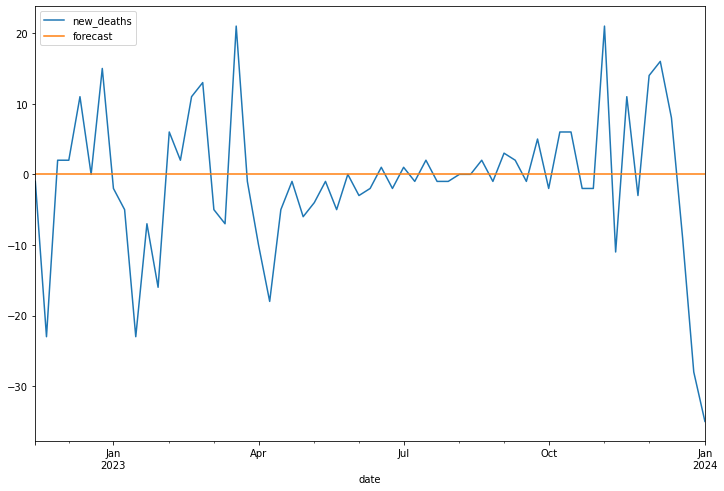

In [174]:
model=sm.tsa.statespace.SARIMAX(czechia_train['new_deaths'],order=(1, 1, 1),seasonal_order=(1,1,2,12))
results=model.fit()
czechia_test['forecast']=results.predict(start=141,end=202,dynamic=True)
czechia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [175]:
mae = mean_absolute_error(czechia_test['new_deaths'], czechia_test['forecast'])
mape = mean_absolute_percentage_error(czechia_test['new_deaths'], czechia_test['forecast'])
r2 = r2_score(czechia_test['new_deaths'], czechia_test['forecast'])
new_row = {'country': 'Czechia', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [176]:
# need un-differenced data
czechia = pd.read_csv('univariate_df_Czechia.csv')
czechia = czechia.set_index('date')
czechia.index = pd.to_datetime(czechia.index)
czechia = czechia.drop('Unnamed: 0', axis=1)
czechia = czechia.drop('diff1', axis=1)
czechia.sort_index()
train_size = int(len(czechia) * 0.7)
czechia_train, czechia_test = czechia[0:train_size], czechia[train_size:]
print(czechia_train.shape, czechia_test.shape)

(141, 1) (61, 1)


In [179]:
auto_model = auto_arima(czechia_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(czechia_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -802.996
Date:                Tue, 20 Feb 2024   AIC                           1615.993
Time:                        23:07:31   BIC                           1630.736
Sample:                    03-01-2020   HQIC                          1621.984
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2741      0.139     16.311      0.000       2.001       2.547
ar.L2         -1.8294      0.224     -8.160      0.000      -2.269      -1.390
ar.L3          0.5444      0.093      5.879      0.0

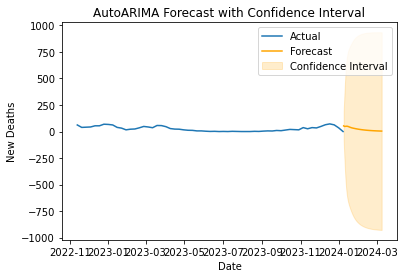

In [181]:
forecast_index = pd.date_range(czechia_test.index[-1], periods=n_periods + 1, freq=czechia_test.index.freq)[-n_periods:]

plt.plot(czechia_test.index, czechia_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [182]:
mae = mean_absolute_error(czechia_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(czechia_test['new_deaths'], forecast)
r2 = r2_score(czechia_test['new_deaths'], forecast)
new_row = {'country': 'Czechia', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Estonia

## train/test split

In [184]:
estonia = pd.read_csv('estonia_diff.csv')
estonia = estonia.set_index('date')
estonia.index = pd.to_datetime(estonia.index)
estonia = estonia.drop('Unnamed: 0', axis=1)
estonia.sort_index()
train_size = int(len(estonia) * 0.7)
estonia_train, estonia_test = estonia[0:train_size], estonia[train_size:]
print(estonia_train.shape, estonia_test.shape)

(141, 1) (61, 1)


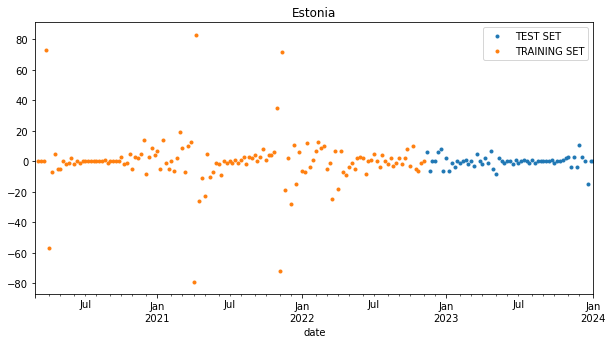

In [185]:
_ = estonia_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(estonia_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Estonia', style='.')

## basic ARIMA (1,1,1)

In [186]:
model=ARIMA(estonia_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -576.535
Date:                Tue, 20 Feb 2024   AIC                           1159.069
Time:                        23:08:21   BIC                           1167.894
Sample:                    03-01-2020   HQIC                          1162.655
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5532      0.033    -16.526      0.000      -0.619      -0.488
ma.L1         -0.9999     14.505     -0.069      0.945     -29.430      27.430
sigma2       200.4493   2910.910      0.069      0.945   -5504.830    5905.729
===================================================================================
Ljung-Box (L1) (Q):                   1.84   Jarque-Bera (JB):               454.84
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

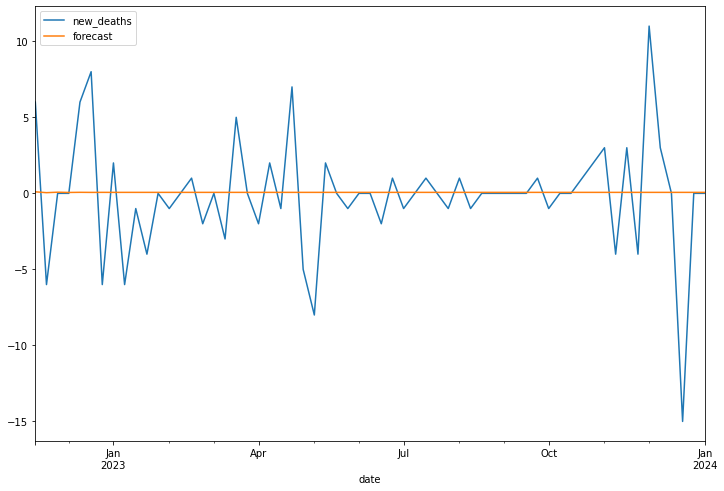

In [187]:
estonia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
estonia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [188]:
mae = mean_absolute_error(estonia_test['new_deaths'], estonia_test['forecast'])
mape = mean_absolute_percentage_error(estonia_test['new_deaths'], estonia_test['forecast'])
r2 = r2_score(estonia_test['new_deaths'], estonia_test['forecast'])
new_row = {'country': 'Estonia', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [189]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(estonia_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
2,1,3,1154.872516
4,2,1,1155.449619
1,1,2,1155.861791
12,4,1,1155.915362
3,1,4,1156.921740
8,3,1,1157.040314
5,2,2,1157.278064
9,3,2,1158.049755
7,2,4,1158.481934
10,3,3,1158.672265


In [190]:
model=ARIMA(estonia_train['new_deaths'],order=(1,1,3))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -572.436
Date:                Tue, 20 Feb 2024   AIC                           1154.873
Time:                        23:09:15   BIC                           1169.581
Sample:                    03-01-2020   HQIC                          1160.849
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3034      0.215      1.411      0.158      -0.118       0.725
ma.L1         -1.9810     11.821     -0.168      0.867     -25.150      21.188
ma.L2          1.4246     11.672      0.122      0.903     -21.451      24.300
ma.L3         -0.4435      5.284     -0.084      0.933     -10.800       9.913
sigma2       188.7827   2213.897      0.085      0.932   -4150.376    4527.941
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               452.10
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.93
Prob(H) (two-sided):                  0.02   Kurtosis:                        11.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

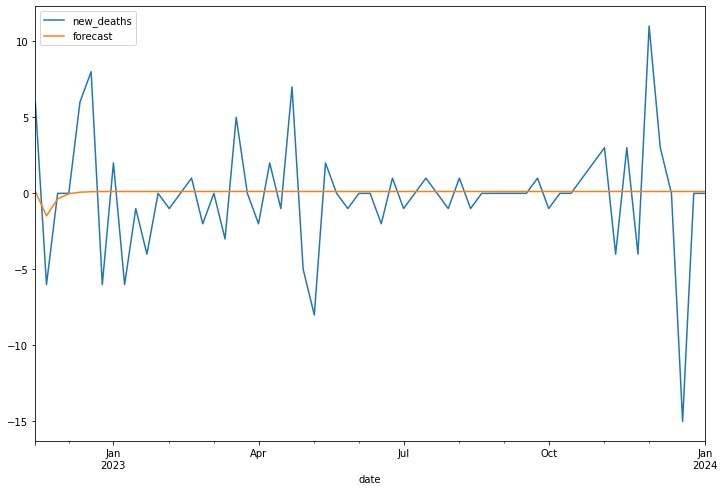

In [191]:
estonia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
estonia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [192]:
mae = mean_absolute_error(estonia_test['new_deaths'], estonia_test['forecast'])
mape = mean_absolute_percentage_error(estonia_test['new_deaths'], estonia_test['forecast'])
r2 = r2_score(estonia_test['new_deaths'], estonia_test['forecast'])
new_row = {'country': 'Estonia', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [193]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(estonia_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94641D+00    |proj g|=  8.19762D-02

At iterate    5    f=  3.89882D+00    |proj g|=  1.39038D-02


 This problem is unconstrained.



At iterate   10    f=  3.86646D+00    |proj g|=  1.36488D-02

At iterate   15    f=  3.86448D+00    |proj g|=  6.90468D-03

At iterate   20    f=  3.86323D+00    |proj g|=  9.96913D-04

At iterate   25    f=  3.86304D+00    |proj g|=  2.04006D-03

At iterate   30    f=  3.86298D+00    |proj g|=  4.01789D-04

At iterate   35    f=  3.86297D+00    |proj g|=  7.82949D-05

At iterate   40    f=  3.86297D+00    |proj g|=  4.32472D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     47      1     0     0   3.891D-05   3.863D+00
  F =   3.8629728626688187     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.89548D+00    |proj g|=  2.69385D-02

At iterate   10    f=  3.86566D+00    |proj g|=  3.96060D-03

At iterate   15    f=  3.86406D+00    |proj g|=  1.03219D-02

At iterate   20    f=  3.86109D+00    |proj g|=  4.48767D-03

At iterate   25    f=  3.86051D+00    |proj g|=  1.01093D-03

At iterate   30    f=  3.86029D+00    |proj g|=  1.02450D-03

At iterate   35    f=  3.86025D+00    |proj g|=  1.79254D-04

At iterate   40    f=  3.86023D+00    |proj g|=  1.73697D-04

At iterate   45    f=  3.86023D+00    |proj g|=  1.96794D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     52   

 This problem is unconstrained.



At iterate    5    f=  3.90285D+00    |proj g|=  6.68621D-02

At iterate   10    f=  3.88192D+00    |proj g|=  5.16287D-02

At iterate   15    f=  3.86523D+00    |proj g|=  1.92176D-03

At iterate   20    f=  3.86349D+00    |proj g|=  5.50688D-04

At iterate   25    f=  3.86320D+00    |proj g|=  4.01430D-03

At iterate   30    f=  3.86286D+00    |proj g|=  4.21086D-03

At iterate   35    f=  3.86284D+00    |proj g|=  1.48844D-04

At iterate   40    f=  3.86283D+00    |proj g|=  4.09280D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     54      1     0     0   5.480D-05   3.863D+00
  F =   3.86282904952

 This problem is unconstrained.



At iterate    5    f=  3.89689D+00    |proj g|=  2.41247D-02

At iterate   10    f=  3.86191D+00    |proj g|=  1.70477D-02

At iterate   15    f=  3.85907D+00    |proj g|=  4.67281D-03

At iterate   20    f=  3.85702D+00    |proj g|=  1.62870D-03

At iterate   25    f=  3.85669D+00    |proj g|=  8.91764D-04

At iterate   30    f=  3.85663D+00    |proj g|=  7.36870D-04

At iterate   35    f=  3.85662D+00    |proj g|=  3.03654D-04

At iterate   40    f=  3.85661D+00    |proj g|=  1.21589D-04

At iterate   45    f=  3.85661D+00    |proj g|=  8.20562D-05

At iterate   50    f=  3.85661D+00    |proj g|=  4.69393D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93926D+00    |proj g|=  6.92546D-02

At iterate    5    f=  3.89055D+00    |proj g|=  1.43379D-02

At iterate   10    f=  3.85299D+00    |proj g|=  3.02232D-02

At iterate   15    f=  3.85092D+00    |proj g|=  2.68002D-03

At iterate   20    f=  3.84919D+00    |proj g|=  1.03856D-02

At iterate   25    f=  3.84864D+00    |proj g|=  2.28593D-03

At iterate   30    f=  3.84858D+00    |proj g|=  5.88235D-04

At iterate   35    f=  3.84858D+00    |proj g|=  2.73415D-04

At iterate   40    f=  3.84858D+00    |proj g|=  1.06948D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92699D+00    |proj g|=  1.32780D-01

At iterate    5    f=  3.89290D+00    |proj g|=  1.78538D-02

At iterate   10    f=  3.85254D+00    |proj g|=  9.04108D-03

At iterate   15    f=  3.85153D+00    |proj g|=  1.58598D-03

At iterate   20    f=  3.84998D+00    |proj g|=  1.10267D-02

At iterate   25    f=  3.84916D+00    |proj g|=  1.80676D-03

At iterate   30    f=  3.84877D+00    |proj g|=  1.31212D-03

At iterate   35    f=  3.84869D+00    |proj g|=  1.26700D-03

At iterate   40    f=  3.84828D+00    |proj g|=  2.57459D-03

At iterate   45    f=  3.84741D+00    |proj g|=  8.94651D-04

At iterate   50    f=  3.84737D+00    |proj g|=  3.10616D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.89552D+00    |proj g|=  4.72672D-02

At iterate   10    f=  3.87392D+00    |proj g|=  3.63934D-02

At iterate   15    f=  3.85106D+00    |proj g|=  2.48857D-03

At iterate   20    f=  3.85086D+00    |proj g|=  9.05900D-03

At iterate   25    f=  3.84882D+00    |proj g|=  2.92582D-03

At iterate   30    f=  3.84865D+00    |proj g|=  9.92444D-04

At iterate   35    f=  3.84858D+00    |proj g|=  2.24257D-03

At iterate   40    f=  3.84857D+00    |proj g|=  5.69284D-04

At iterate   45    f=  3.84857D+00    |proj g|=  1.19539D-04

At iterate   50    f=  3.84857D+00    |proj g|=  1.32660D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.89322D+00    |proj g|=  3.61932D-02

At iterate   10    f=  3.84827D+00    |proj g|=  9.81196D-03

At iterate   15    f=  3.84720D+00    |proj g|=  3.28645D-03

At iterate   20    f=  3.84533D+00    |proj g|=  9.56864D-03

At iterate   25    f=  3.84450D+00    |proj g|=  1.74882D-03

At iterate   30    f=  3.84420D+00    |proj g|=  1.52101D-03

At iterate   35    f=  3.84416D+00    |proj g|=  6.33262D-04

At iterate   40    f=  3.84415D+00    |proj g|=  4.17475D-04

At iterate   45    f=  3.84415D+00    |proj g|=  2.08962D-04

At iterate   50    f=  3.84415D+00    |proj g|=  3.41670D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94643D+00    |proj g|=  8.33803D-02

At iterate    5    f=  3.88734D+00    |proj g|=  1.54775D-02

At iterate   10    f=  3.84980D+00    |proj g|=  1.13393D-02

At iterate   15    f=  3.84796D+00    |proj g|=  7.92521D-03

At iterate   20    f=  3.84705D+00    |proj g|=  1.48376D-03

At iterate   25    f=  3.84695D+00    |proj g|=  5.78606D-04

At iterate   30    f=  3.84695D+00    |proj g|=  4.77169D-04

At iterate   35    f=  3.84694D+00    |proj g|=  3.71204D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94097D+00    |proj g|=  1.49262D-01

At iterate    5    f=  3.88723D+00    |proj g|=  1.92743D-02

At iterate   10    f=  3.85110D+00    |proj g|=  4.94794D-03

At iterate   15    f=  3.84965D+00    |proj g|=  1.51919D-03

At iterate   20    f=  3.84803D+00    |proj g|=  5.01607D-03

At iterate   25    f=  3.84765D+00    |proj g|=  2.42093D-03

At iterate   30    f=  3.84743D+00    |proj g|=  8.39813D-04

At iterate   35    f=  3.84738D+00    |proj g|=  9.60686D-05

At iterate   40    f=  3.84737D+00    |proj g|=  6.22223D-04

At iterate   45    f=  3.84736D+00    |proj g|=  1.43761D-04

At iterate   50    f=  3.84736D+00    |proj g|=  1.77832D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.89523D+00    |proj g|=  4.93124D-02

At iterate   10    f=  3.87173D+00    |proj g|=  1.42425D-02

At iterate   15    f=  3.84920D+00    |proj g|=  3.56618D-03

At iterate   20    f=  3.84852D+00    |proj g|=  9.11793D-03

At iterate   25    f=  3.84707D+00    |proj g|=  2.17730D-03

At iterate   30    f=  3.84692D+00    |proj g|=  9.56423D-04

At iterate   35    f=  3.84692D+00    |proj g|=  1.88977D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     44      1     0     0   1.834D-05   3.847D+00
  F =   3.8469160149609807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.88698D+00    |proj g|=  2.89708D-02

At iterate   10    f=  3.84842D+00    |proj g|=  1.72691D-02

At iterate   15    f=  3.84622D+00    |proj g|=  2.28694D-03

At iterate   20    f=  3.84371D+00    |proj g|=  3.65912D-03

At iterate   25    f=  3.84314D+00    |proj g|=  9.23249D-04

At iterate   30    f=  3.84302D+00    |proj g|=  6.87359D-04

At iterate   35    f=  3.84298D+00    |proj g|=  5.65528D-04

At iterate   40    f=  3.84297D+00    |proj g|=  3.98056D-04

At iterate   45    f=  3.84297D+00    |proj g|=  1.54357D-04

At iterate   50    f=  3.84297D+00    |proj g|=  1.32894D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.89178D+00    |proj g|=  1.95854D-02

At iterate   10    f=  3.85312D+00    |proj g|=  3.71068D-02

At iterate   15    f=  3.84811D+00    |proj g|=  1.03024D-02

At iterate   20    f=  3.84791D+00    |proj g|=  2.75246D-03

At iterate   25    f=  3.84686D+00    |proj g|=  3.98503D-03

At iterate   30    f=  3.84657D+00    |proj g|=  8.60017D-04

At iterate   35    f=  3.84654D+00    |proj g|=  3.58387D-04

At iterate   40    f=  3.84653D+00    |proj g|=  2.17447D-04

At iterate   45    f=  3.84653D+00    |proj g|=  6.06396D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     55   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92523D+00    |proj g|=  1.36544D-01

At iterate    5    f=  3.88975D+00    |proj g|=  2.37616D-02

At iterate   10    f=  3.84908D+00    |proj g|=  5.82838D-03

At iterate   15    f=  3.84833D+00    |proj g|=  7.70667D-04

At iterate   20    f=  3.84822D+00    |proj g|=  1.46534D-03

At iterate   25    f=  3.84771D+00    |proj g|=  1.76387D-02

At iterate   30    f=  3.84655D+00    |proj g|=  3.55300D-03

At iterate   35    f=  3.84604D+00    |proj g|=  1.23699D-03

At iterate   40    f=  3.84585D+00    |proj g|=  2.10138D-03

At iterate   45    f=  3.84578D+00    |proj g|=  1.30277D-03

At iterate   50    f=  3.84574D+00    |proj g|=  1.38876D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.88944D+00    |proj g|=  4.30005D-02

At iterate   10    f=  3.86300D+00    |proj g|=  4.41479D-02

At iterate   15    f=  3.84710D+00    |proj g|=  4.72163D-03

At iterate   20    f=  3.84705D+00    |proj g|=  1.44517D-03

At iterate   25    f=  3.84679D+00    |proj g|=  8.19814D-03

At iterate   30    f=  3.84653D+00    |proj g|=  1.71118D-03

At iterate   35    f=  3.84650D+00    |proj g|=  4.96720D-04

At iterate   40    f=  3.84648D+00    |proj g|=  7.87189D-04

At iterate   45    f=  3.84647D+00    |proj g|=  1.38653D-04

At iterate   50    f=  3.84647D+00    |proj g|=  9.56601D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.89031D+00    |proj g|=  3.21932D-02

At iterate   10    f=  3.84563D+00    |proj g|=  6.89352D-03

At iterate   15    f=  3.84456D+00    |proj g|=  3.47773D-03

At iterate   20    f=  3.84385D+00    |proj g|=  1.77832D-02

At iterate   25    f=  3.84300D+00    |proj g|=  4.00128D-03

At iterate   30    f=  3.84280D+00    |proj g|=  1.83812D-03

At iterate   35    f=  3.84271D+00    |proj g|=  2.30475D-04

At iterate   40    f=  3.84269D+00    |proj g|=  1.18825D-03

At iterate   45    f=  3.84269D+00    |proj g|=  3.84241D-04

At iterate   50    f=  3.84268D+00    |proj g|=  1.54176D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [194]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
8,2,1,1,1,1096.838465
4,1,2,1,1,1097.298480
12,2,2,1,1,1098.720874
10,2,1,2,1,1098.830316
9,2,1,1,2,1098.955939
5,1,2,1,2,1098.958487
6,1,2,2,1,1099.297037
0,1,1,1,1,1099.358347
11,2,1,2,2,1099.717526
7,1,2,2,2,1100.049052


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94643D+00    |proj g|=  8.33803D-02

At iterate    5    f=  3.88734D+00    |proj g|=  1.54775D-02

At iterate   10    f=  3.84980D+00    |proj g|=  1.13393D-02

At iterate   15    f=  3.84796D+00    |proj g|=  7.92521D-03

At iterate   20    f=  3.84705D+00    |proj g|=  1.48376D-03

At iterate   25    f=  3.84695D+00    |proj g|=  5.78606D-04

At iterate   30    f=  3.84695D+00    |proj g|=  4.77169D-04

At iterate   35    f=  3.84694D+00    |proj g|=  3.71204D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

<AxesSubplot:xlabel='date'>

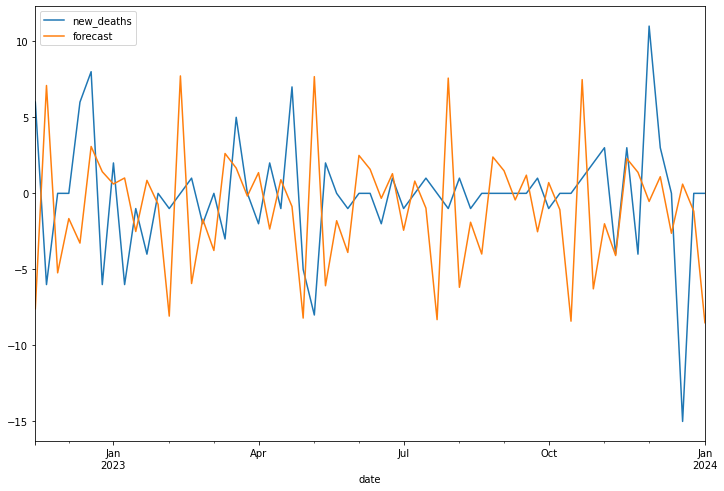

In [195]:
model=sm.tsa.statespace.SARIMAX(estonia_train['new_deaths'],order=(2, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
estonia_test['forecast']=results.predict(start=141,end=202,dynamic=True)
estonia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [196]:
mae = mean_absolute_error(estonia_test['new_deaths'], estonia_test['forecast'])
mape = mean_absolute_percentage_error(estonia_test['new_deaths'], estonia_test['forecast'])
r2 = r2_score(estonia_test['new_deaths'], estonia_test['forecast'])
new_row = {'country': 'Estonia', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [197]:
# need un-differenced data
estonia = pd.read_csv('univariate_df_Estonia.csv')
estonia = estonia.set_index('date')
estonia.index = pd.to_datetime(estonia.index)
estonia = estonia.drop('Unnamed: 0', axis=1)
estonia = estonia.drop('diff1', axis=1)
estonia.sort_index()
train_size = int(len(estonia) * 0.7)
estonia_train, estonia_test = estonia[0:train_size], estonia[train_size:]
print(estonia_train.shape, estonia_test.shape)

(141, 1) (61, 1)


In [198]:
auto_model = auto_arima(estonia_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(estonia_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -565.368
Date:                Tue, 20 Feb 2024   AIC                           1142.736
Time:                        23:11:31   BIC                           1160.429
Sample:                    03-01-2020   HQIC                          1149.926
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1387      1.400      0.813      0.416      -1.606       3.883
ar.L1          1.5261      0.216      7.071      0.000       1.103       1.949
ar.L2         -0.5945      0.201     -2.956      0.0

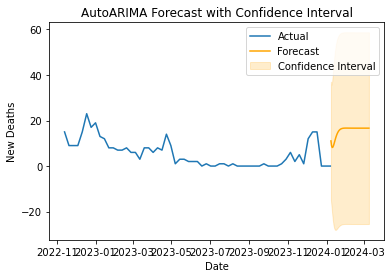

In [199]:
forecast_index = pd.date_range(estonia_test.index[-1], periods=n_periods + 1, freq=estonia_test.index.freq)[-n_periods:]

plt.plot(estonia_test.index, estonia_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [200]:
mae = mean_absolute_error(estonia_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(estonia_test['new_deaths'], forecast)
r2 = r2_score(estonia_test['new_deaths'], forecast)
new_row = {'country': 'Estonia', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# France

## train/test split

In [202]:
france = pd.read_csv('france_diff.csv')
france = france.set_index('date')
france.index = pd.to_datetime(france.index)
france = france.drop('Unnamed: 0', axis=1)
france.sort_index()
train_size = int(len(france) * 0.7)
france_train, france_test = france[0:train_size], france[train_size:]
print(france_train.shape, france_test.shape)

(141, 1) (61, 1)


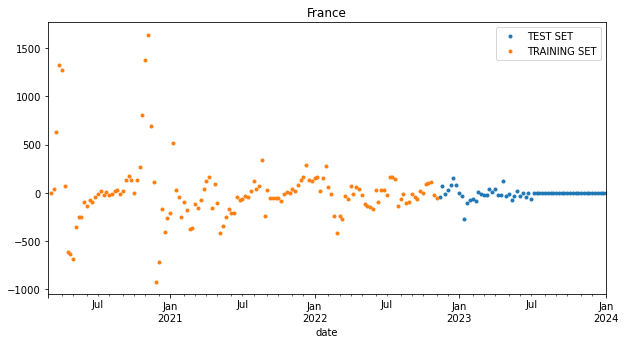

In [203]:
_ = france_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(france_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='France', style='.')

## basic ARIMA (1,1,1)

In [204]:
model=ARIMA(france_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -971.407
Date:                Tue, 20 Feb 2024   AIC                           1948.814
Time:                        23:12:14   BIC                           1957.639
Sample:                    03-01-2020   HQIC                          1952.400
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0391      0.229      0.171      0.864      -0.409       0.488
ma.L1          0.1598      0.237      0.674      0.500      -0.305       0.625
sigma2      6.135e+04   3722.212     16.483      0.000    5.41e+04    6.86e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               280.88
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                            -1.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

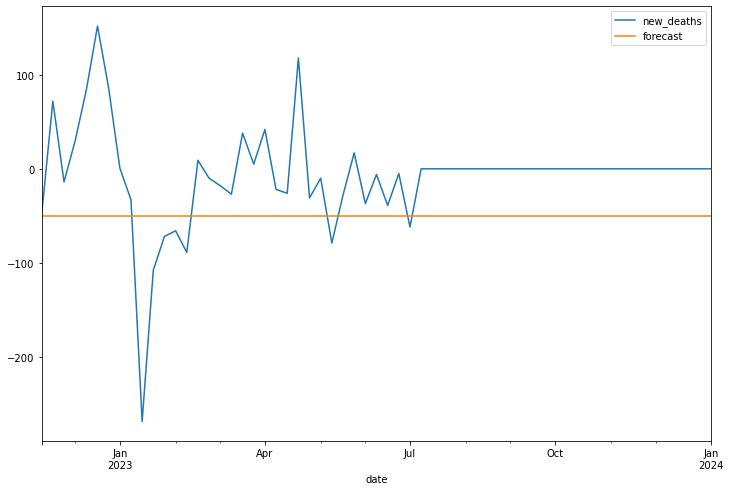

In [205]:
france_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
france_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [206]:
mae = mean_absolute_error(france_test['new_deaths'], france_test['forecast'])
mape = mean_absolute_percentage_error(france_test['new_deaths'], france_test['forecast'])
r2 = r2_score(france_test['new_deaths'], france_test['forecast'])
new_row = {'country': 'France', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [207]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(france_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
8,3,1,1914.050772
5,2,2,1914.927877
2,1,3,1915.410874
9,3,2,1915.462256
12,4,1,1915.539102
6,2,3,1915.715018
4,2,1,1915.890570
3,1,4,1916.075197
14,4,3,1916.129543
7,2,4,1916.829169


In [208]:
model=ARIMA(france_train['new_deaths'],order=(3,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -952.025
Date:                Tue, 20 Feb 2024   AIC                           1914.051
Time:                        23:13:09   BIC                           1928.759
Sample:                    03-01-2020   HQIC                          1920.028
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9177      0.062     14.834      0.000       0.796       1.039
ar.L2         -0.2129      0.087     -2.460      0.014      -0.383      -0.043
ar.L3         -0.1682      0.059     -2.870      0.004      -0.283      -0.053
ma.L1         -0.9999     11.151     -0.090      0.929     -22.855      20.855
sigma2      4.499e+04   5.01e+05      0.090      0.928   -9.37e+05    1.03e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                94.28
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

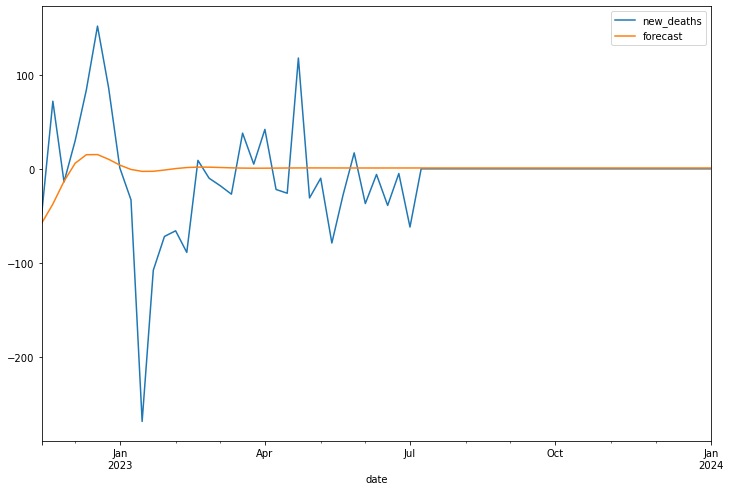

In [209]:
france_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
france_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [210]:
mae = mean_absolute_error(france_test['new_deaths'], france_test['forecast'])
mape = mean_absolute_percentage_error(france_test['new_deaths'], france_test['forecast'])
r2 = r2_score(france_test['new_deaths'], france_test['forecast'])
new_row = {'country': 'France', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [211]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(france_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.45565D+00    |proj g|=  6.32223D-02

At iterate    5    f=  6.42989D+00    |proj g|=  1.98837D-02


 This problem is unconstrained.



At iterate   10    f=  6.42797D+00    |proj g|=  1.58225D-03

At iterate   15    f=  6.42753D+00    |proj g|=  1.71535D-02

At iterate   20    f=  6.40573D+00    |proj g|=  1.35303D-01

At iterate   25    f=  6.37391D+00    |proj g|=  1.69169D-02

At iterate   30    f=  6.37254D+00    |proj g|=  1.85911D-03

At iterate   35    f=  6.37238D+00    |proj g|=  1.49774D-03

At iterate   40    f=  6.37236D+00    |proj g|=  1.50859D-04

At iterate   45    f=  6.37236D+00    |proj g|=  8.99264D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     56      1     0     0   1.277D-04   6.372D+00
  F =   6.37235742137

 This problem is unconstrained.



At iterate    5    f=  6.43147D+00    |proj g|=  1.00448D-02

At iterate   10    f=  6.42830D+00    |proj g|=  1.03702D-03

At iterate   15    f=  6.42782D+00    |proj g|=  1.49386D-02

At iterate   20    f=  6.42295D+00    |proj g|=  1.25265D-02

At iterate   25    f=  6.38460D+00    |proj g|=  8.35208D-02

At iterate   30    f=  6.37384D+00    |proj g|=  4.76963D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     42      1     0     0   2.681D-05   6.374D+00
  F =   6.3738356166009744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.44607D+00    |proj g|=  7.35961D-02

At iterate   10    f=  6.42846D+00    |proj g|=  3.84780D-03

At iterate   15    f=  6.42795D+00    |proj g|=  1.04015D-03

At iterate   20    f=  6.42663D+00    |proj g|=  1.77655D-02

At iterate   25    f=  6.38048D+00    |proj g|=  4.67961D-02

At iterate   30    f=  6.37374D+00    |proj g|=  6.97489D-03

At iterate   35    f=  6.37249D+00    |proj g|=  3.20808D-03

At iterate   40    f=  6.37234D+00    |proj g|=  2.73930D-03

At iterate   45    f=  6.37232D+00    |proj g|=  2.71335D-04

At iterate   50    f=  6.37231D+00    |proj g|=  4.12030D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46144D+00    |proj g|=  4.94471D-02

At iterate    5    f=  6.43117D+00    |proj g|=  1.59766D-02

At iterate   10    f=  6.42800D+00    |proj g|=  4.37691D-03

At iterate   15    f=  6.42789D+00    |proj g|=  4.44941D-03

At iterate   20    f=  6.41870D+00    |proj g|=  6.48554D-02

At iterate   25    f=  6.38165D+00    |proj g|=  4.90304D-02

At iterate   30    f=  6.37279D+00    |proj g|=  5.29390D-03

At iterate   35    f=  6.37239D+00    |proj g|=  7.53121D-04

At iterate   40    f=  6.37228D+00    |proj g|=  3.79540D-03

At iterate   45    f=  6.37209D+00    |proj g|=  2.52822D-03

At iterate   50    f=  6.37196D+00    |proj g|=  2.20332D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.37149D+00    |proj g|=  2.59026D-02

At iterate   10    f=  6.36310D+00    |proj g|=  1.03934D-02

At iterate   15    f=  6.36172D+00    |proj g|=  1.12589D-03

At iterate   20    f=  6.32279D+00    |proj g|=  1.08628D-01

At iterate   25    f=  6.30676D+00    |proj g|=  7.22952D-03

At iterate   30    f=  6.30590D+00    |proj g|=  2.39474D-03

At iterate   35    f=  6.30572D+00    |proj g|=  1.72601D-03

At iterate   40    f=  6.30570D+00    |proj g|=  2.55066D-04

At iterate   45    f=  6.30570D+00    |proj g|=  3.29777D-04

At iterate   50    f=  6.30570D+00    |proj g|=  3.60755D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.37276D+00    |proj g|=  2.53168D-02

At iterate   10    f=  6.36261D+00    |proj g|=  1.83550D-03

At iterate   15    f=  6.36220D+00    |proj g|=  2.88104D-03

At iterate   20    f=  6.35929D+00    |proj g|=  2.11806D-02

At iterate   25    f=  6.30792D+00    |proj g|=  4.52802D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     44      1     0     0   3.883D-03   6.307D+00
  F =   6.3068745666250319     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  6.37471D+00    |proj g|=  9.86744D-02

At iterate   10    f=  6.36402D+00    |proj g|=  3.69557D-03

At iterate   15    f=  6.36195D+00    |proj g|=  1.12238D-03

At iterate   20    f=  6.32623D+00    |proj g|=  1.23133D-01

At iterate   25    f=  6.30654D+00    |proj g|=  2.70606D-03

At iterate   30    f=  6.30583D+00    |proj g|=  2.04527D-03

At iterate   35    f=  6.30571D+00    |proj g|=  1.63175D-03

At iterate   40    f=  6.30570D+00    |proj g|=  5.75432D-04

At iterate   45    f=  6.30570D+00    |proj g|=  5.35629D-05

At iterate   50    f=  6.30570D+00    |proj g|=  4.90144D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46235D+00    |proj g|=  2.80257D-01

At iterate    5    f=  6.37575D+00    |proj g|=  2.14518D-02

At iterate   10    f=  6.36312D+00    |proj g|=  6.98913D-03

At iterate   15    f=  6.36219D+00    |proj g|=  2.61613D-03

At iterate   20    f=  6.36196D+00    |proj g|=  2.99540D-03

At iterate   25    f=  6.30843D+00    |proj g|=  3.31813D-02

At iterate   30    f=  6.30580D+00    |proj g|=  6.59791D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  6.40553D+00    |proj g|=  1.38093D-02

At iterate   10    f=  6.39099D+00    |proj g|=  5.70844D-02

At iterate   15    f=  6.35262D+00    |proj g|=  8.49674D-03

At iterate   20    f=  6.35117D+00    |proj g|=  4.36240D-03

At iterate   25    f=  6.34454D+00    |proj g|=  5.00661D-02

At iterate   30    f=  6.27994D+00    |proj g|=  3.22317D-02

At iterate   35    f=  6.27713D+00    |proj g|=  6.36504D-03

At iterate   40    f=  6.27664D+00    |proj g|=  2.26272D-03

At iterate   45    f=  6.27657D+00    |proj g|=  4.04406D-04

At iterate   50    f=  6.27656D+00    |proj g|=  1.10813D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.40519D+00    |proj g|=  4.43945D-03

At iterate   10    f=  6.39352D+00    |proj g|=  5.93716D-02

At iterate   15    f=  6.35545D+00    |proj g|=  2.13232D-02

At iterate   20    f=  6.35167D+00    |proj g|=  9.87719D-03

At iterate   25    f=  6.35012D+00    |proj g|=  6.02615D-03

At iterate   30    f=  6.34216D+00    |proj g|=  1.17498D-02

At iterate   35    f=  6.27857D+00    |proj g|=  5.04819D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     63      1     0     0   1.152D-04   6.279D+00
  F =   6.2785479549326597     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  6.41677D+00    |proj g|=  5.14701D-02

At iterate   10    f=  6.40457D+00    |proj g|=  5.72897D-03

At iterate   15    f=  6.38882D+00    |proj g|=  7.14529D-02

At iterate   20    f=  6.35701D+00    |proj g|=  3.04269D-02

At iterate   25    f=  6.35027D+00    |proj g|=  5.07906D-03

At iterate   30    f=  6.34984D+00    |proj g|=  1.26060D-03

At iterate   35    f=  6.33769D+00    |proj g|=  2.48982D-02

At iterate   40    f=  6.27971D+00    |proj g|=  1.80556D-02

At iterate   45    f=  6.27563D+00    |proj g|=  3.37517D-03

At iterate   50    f=  6.27520D+00    |proj g|=  2.13352D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.40496D+00    |proj g|=  6.02291D-03

At iterate   10    f=  6.38934D+00    |proj g|=  7.42862D-02

At iterate   15    f=  6.36194D+00    |proj g|=  3.45591D-02

At iterate   20    f=  6.34980D+00    |proj g|=  4.65610D-03

At iterate   25    f=  6.34530D+00    |proj g|=  2.95381D-02

At iterate   30    f=  6.28604D+00    |proj g|=  3.63637D-02

At iterate   35    f=  6.27603D+00    |proj g|=  2.39233D-02

At iterate   40    f=  6.27468D+00    |proj g|=  3.28992D-03

At iterate   45    f=  6.27463D+00    |proj g|=  4.01522D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     61   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.44947D+00    |proj g|=  2.50170D-01

At iterate    5    f=  6.35796D+00    |proj g|=  1.82422D-02

At iterate   10    f=  6.34081D+00    |proj g|=  9.93730D-03

At iterate   15    f=  6.33732D+00    |proj g|=  2.00876D-03

At iterate   20    f=  6.33589D+00    |proj g|=  9.93286D-03

At iterate   25    f=  6.33022D+00    |proj g|=  4.09934D-02

At iterate   30    f=  6.26551D+00    |proj g|=  3.89139D-02

At iterate   35    f=  6.26062D+00    |proj g|=  7.95773D-03

At iterate   40    f=  6.26008D+00    |proj g|=  3.35280D-03

At iterate   45    f=  6.26002D+00    |proj g|=  6.30043D-04

At iterate   50    f=  6.26001D+00    |proj g|=  1.12761D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.36203D+00    |proj g|=  3.87423D-02

At iterate   10    f=  6.34328D+00    |proj g|=  2.50473D-02

At iterate   15    f=  6.33991D+00    |proj g|=  3.67205D-03

At iterate   20    f=  6.33663D+00    |proj g|=  5.05689D-03

At iterate   25    f=  6.33469D+00    |proj g|=  3.87578D-03

At iterate   30    f=  6.33421D+00    |proj g|=  6.11709D-03

At iterate   35    f=  6.26803D+00    |proj g|=  1.71308D-02

At iterate   40    f=  6.26307D+00    |proj g|=  4.04625D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     66      1     0     0   1.639D-03   6.263D+00
  F =   6.26299630672


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2 2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.45535D+00    |proj g|=  2.75429D-01


 This problem is unconstrained.



At iterate    5    f=  6.36457D+00    |proj g|=  1.19044D-01

At iterate   10    f=  6.34078D+00    |proj g|=  1.29758D-02

At iterate   15    f=  6.33616D+00    |proj g|=  1.98091D-03

At iterate   20    f=  6.33498D+00    |proj g|=  1.48656D-02

At iterate   25    f=  6.33318D+00    |proj g|=  2.51092D-03

At iterate   30    f=  6.29354D+00    |proj g|=  8.16636D-02

At iterate   35    f=  6.25865D+00    |proj g|=  3.07034D-03

At iterate   40    f=  6.25787D+00    |proj g|=  9.20137D-04

At iterate   45    f=  6.25773D+00    |proj g|=  8.61307D-04

At iterate   50    f=  6.25772D+00    |proj g|=  4.03568D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46054D+00    |proj g|=  2.77493D-01

At iterate    5    f=  6.36444D+00    |proj g|=  1.69910D-02

At iterate   10    f=  6.33654D+00    |proj g|=  1.35566D-02

At iterate   15    f=  6.33552D+00    |proj g|=  4.46239D-03

At iterate   20    f=  6.33388D+00    |proj g|=  1.99259D-03

At iterate   25    f=  6.33238D+00    |proj g|=  2.30363D-02

At iterate   30    f=  6.32418D+00    |proj g|=  2.39332D-02

At iterate   35    f=  6.28592D+00    |proj g|=  7.57309D-02

At iterate   40    f=  6.26076D+00    |proj g|=  4.56083D-03

At iterate   45    f=  6.26054D+00    |proj g|=  4.97668D-03

At iterate   50    f=  6.26032D+00    |proj g|=  3.93473D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [212]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
12,2,2,1,1,1779.321477
14,2,2,2,1,1780.676005
8,2,1,1,1,1781.989398
13,2,2,1,2,1782.164958
15,2,2,2,2,1783.411411
10,2,1,2,1,1783.605339
9,2,1,1,2,1784.550523
11,2,1,2,2,1785.445488
4,1,2,1,1,1790.207656
6,1,2,2,1,1792.206970


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.44947D+00    |proj g|=  2.50170D-01

At iterate    5    f=  6.35796D+00    |proj g|=  1.82422D-02

At iterate   10    f=  6.34081D+00    |proj g|=  9.93730D-03

At iterate   15    f=  6.33732D+00    |proj g|=  2.00876D-03

At iterate   20    f=  6.33589D+00    |proj g|=  9.93286D-03

At iterate   25    f=  6.33022D+00    |proj g|=  4.09934D-02

At iterate   30    f=  6.26551D+00    |proj g|=  3.89139D-02

At iterate   35    f=  6.26062D+00    |proj g|=  7.95773D-03

At iterate   40    f=  6.26008D+00    |proj g|=  3.35280D-03

At iterate   45    f=  6.26002D+00    |proj g|=  6.30043D-04

At iterate   50    f=  6.26001D+00    |proj g|=  1.12761D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<AxesSubplot:xlabel='date'>

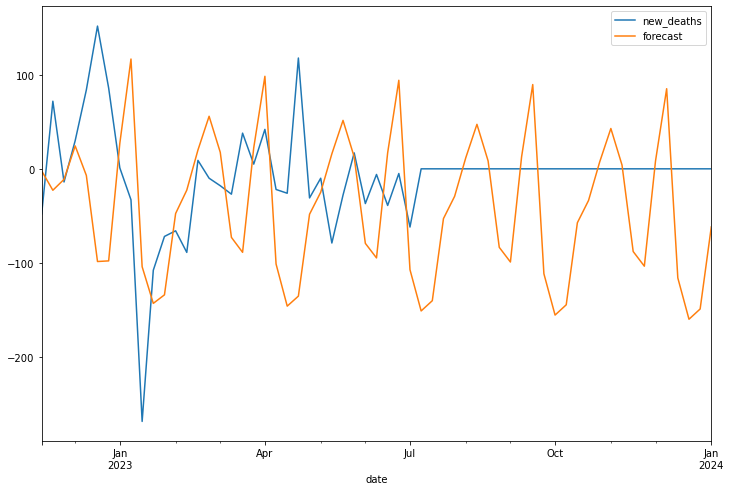

In [213]:
model=sm.tsa.statespace.SARIMAX(france_train['new_deaths'],order=(2, 1, 2),seasonal_order=(1,1,1,12))
results=model.fit()
france_test['forecast']=results.predict(start=141,end=202,dynamic=True)
france_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [214]:
mae = mean_absolute_error(france_test['new_deaths'], france_test['forecast'])
mape = mean_absolute_percentage_error(france_test['new_deaths'], france_test['forecast'])
r2 = r2_score(france_test['new_deaths'], france_test['forecast'])
new_row = {'country': 'France', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [215]:
# need un-differenced data
france = pd.read_csv('univariate_df_France.csv')
france = france.set_index('date')
france.index = pd.to_datetime(france.index)
france = france.drop('Unnamed: 0', axis=1)
france = france.drop('diff1', axis=1)
france.sort_index()
train_size = int(len(france) * 0.7)
france_train, france_test = france[0:train_size], france[train_size:]
print(france_train.shape, france_test.shape)

(141, 1) (61, 1)


In [216]:
auto_model = auto_arima(france_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(france_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -953.040
Date:                Tue, 20 Feb 2024   AIC                           1918.081
Time:                        23:15:11   BIC                           1935.773
Sample:                    03-01-2020   HQIC                          1925.270
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     93.6837     63.218      1.482      0.138     -30.222     217.589
ar.L1          1.3268      0.075     17.717      0.000       1.180       1.474
ar.L2         -0.4172      0.073     -5.715      0.0

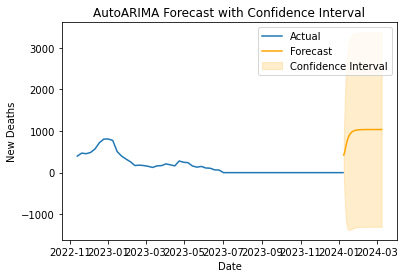

In [217]:
forecast_index = pd.date_range(france_test.index[-1], periods=n_periods + 1, freq=france_test.index.freq)[-n_periods:]

plt.plot(france_test.index, france_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [218]:
mae = mean_absolute_error(france_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(france_test['new_deaths'], forecast)
r2 = r2_score(france_test['new_deaths'], forecast)
new_row = {'country': 'France', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Malaysia

## train/test split

In [220]:
malaysia = pd.read_csv('malaysia_diff.csv')
malaysia = malaysia.set_index('date')
malaysia.index = pd.to_datetime(malaysia.index)
malaysia = malaysia.drop('Unnamed: 0', axis=1)
malaysia.sort_index()
train_size = int(len(malaysia) * 0.7)
malaysia_train, malaysia_test = malaysia[0:train_size], malaysia[train_size:]
print(malaysia_train.shape, malaysia_test.shape)

(141, 1) (61, 1)


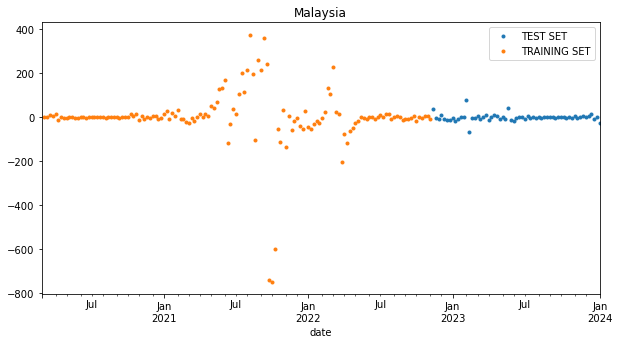

In [221]:
_ = malaysia_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(malaysia_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Malaysia', style='.')

## basic ARIMA (1,1,1)

In [223]:
model=ARIMA(malaysia_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -855.120
Date:                Tue, 20 Feb 2024   AIC                           1716.239
Time:                        23:15:54   BIC                           1725.064
Sample:                    03-01-2020   HQIC                          1719.825
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5889      0.036     16.270      0.000       0.518       0.660
ma.L1         -0.9996      1.369     -0.730      0.465      -3.683       1.684
sigma2      1.124e+04   1.57e+04      0.717      0.473   -1.95e+04     4.2e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.62   Jarque-Bera (JB):              7595.94
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):              29.91   Skew:                            -4.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

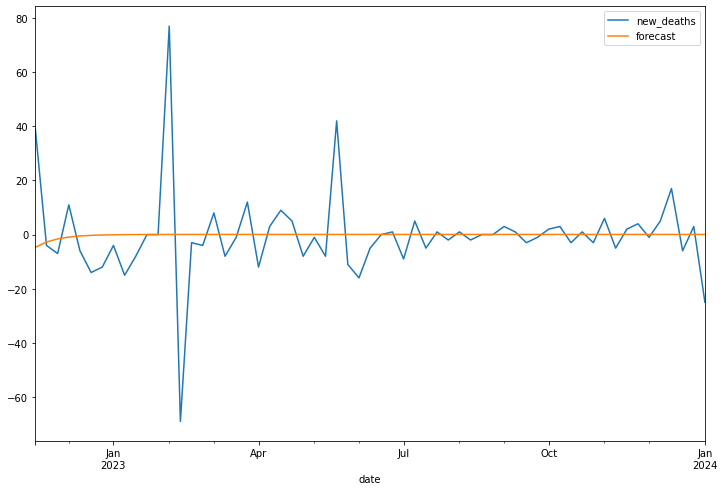

In [225]:
malaysia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
malaysia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [226]:
mae = mean_absolute_error(malaysia_test['new_deaths'], malaysia_test['forecast'])
mape = mean_absolute_percentage_error(malaysia_test['new_deaths'], malaysia_test['forecast'])
r2 = r2_score(malaysia_test['new_deaths'], malaysia_test['forecast'])
new_row = {'country': 'Malaysia', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [227]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(malaysia_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
10,3,3,1703.385076
7,2,4,1703.680978
6,2,3,1704.914766
11,3,4,1705.376485
14,4,3,1705.377969
15,4,4,1707.305976
12,4,1,1710.173060
2,1,3,1710.696474
8,3,1,1711.081404
3,1,4,1711.345762


In [228]:
model=ARIMA(malaysia_train['new_deaths'],order=(3,1,3))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -844.693
Date:                Tue, 20 Feb 2024   AIC                           1703.385
Time:                        23:16:57   BIC                           1723.977
Sample:                    03-01-2020   HQIC                          1711.753
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6903      0.127      5.429      0.000       0.441       0.940
ar.L2         -0.7441      0.154     -4.835      0.000      -1.046      -0.442
ar.L3          0.2141      0.100      2.151      0.032       0.019       0.409
ma.L1         -1.0155     33.278     -0.031      0.976     -66.239      64.208
ma.L2          0.7896      0.594      1.330      0.183      -0.374       1.953
ma.L3         -0.7740     25.794     -0.030      0.976     -51.329      49.780
sigma2      9603.0816    3.2e+05      0.030      0.976   -6.17e+05    6.36e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5401.87
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              23.43   Skew:                            -3.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

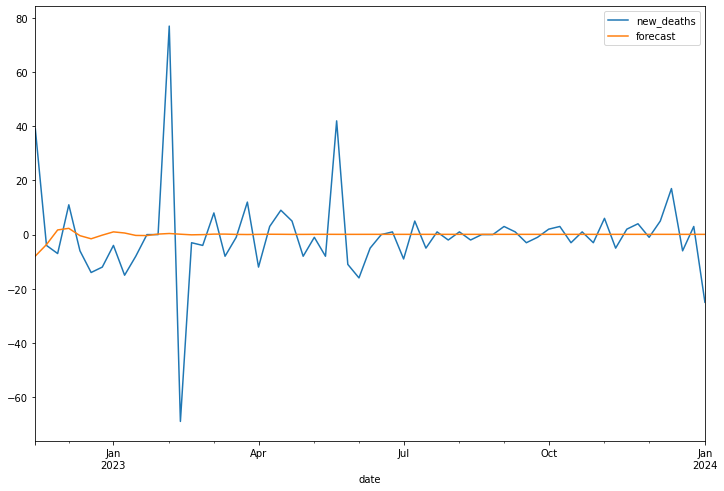

In [229]:
malaysia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
malaysia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [230]:
mae = mean_absolute_error(malaysia_test['new_deaths'], malaysia_test['forecast'])
mape = mean_absolute_percentage_error(malaysia_test['new_deaths'], malaysia_test['forecast'])
r2 = r2_score(malaysia_test['new_deaths'], malaysia_test['forecast'])
new_row = {'country': 'Malaysia', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [231]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(malaysia_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.81990D+00    |proj g|=  5.98780D-02

At iterate    5    f=  5.78342D+00    |proj g|=  8.97863D-03


 This problem is unconstrained.



At iterate   10    f=  5.77728D+00    |proj g|=  4.21749D-02

At iterate   15    f=  5.75655D+00    |proj g|=  1.54570D-02

At iterate   20    f=  5.72811D+00    |proj g|=  1.85589D-02

At iterate   25    f=  5.67727D+00    |proj g|=  1.00835D-01

At iterate   30    f=  5.65003D+00    |proj g|=  1.78008D-02

At iterate   35    f=  5.64828D+00    |proj g|=  2.43708D-03

At iterate   40    f=  5.64814D+00    |proj g|=  3.50859D-04

At iterate   45    f=  5.64813D+00    |proj g|=  3.03354D-05

At iterate   50    f=  5.64813D+00    |proj g|=  1.45409D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63   

 This problem is unconstrained.



At iterate    5    f=  5.78176D+00    |proj g|=  4.66052D-03

At iterate   10    f=  5.77259D+00    |proj g|=  8.25713D-02

At iterate   15    f=  5.74392D+00    |proj g|=  2.42800D-02

At iterate   20    f=  5.73234D+00    |proj g|=  3.53011D-03

At iterate   25    f=  5.64939D+00    |proj g|=  4.70254D-03

At iterate   30    f=  5.64935D+00    |proj g|=  1.26540D-03

At iterate   35    f=  5.64923D+00    |proj g|=  6.36113D-04

At iterate   40    f=  5.64920D+00    |proj g|=  8.09625D-05

At iterate   45    f=  5.64916D+00    |proj g|=  4.67004D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     63   

 This problem is unconstrained.



At iterate    5    f=  5.80685D+00    |proj g|=  1.30599D-01

At iterate   10    f=  5.77754D+00    |proj g|=  2.11827D-02

At iterate   15    f=  5.76040D+00    |proj g|=  1.66278D-02

At iterate   20    f=  5.75232D+00    |proj g|=  1.76042D-02

At iterate   25    f=  5.68256D+00    |proj g|=  7.27858D-02

At iterate   30    f=  5.64644D+00    |proj g|=  1.16513D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     43      1     0     0   1.081D-05   5.646D+00
  F =   5.6462974554338814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.78102D+00    |proj g|=  1.39534D-02

At iterate   10    f=  5.77494D+00    |proj g|=  1.21233D-01

At iterate   15    f=  5.73855D+00    |proj g|=  1.70261D-02

At iterate   20    f=  5.69685D+00    |proj g|=  1.82408D-01

At iterate   25    f=  5.64888D+00    |proj g|=  1.80584D-03

At iterate   30    f=  5.64864D+00    |proj g|=  6.26624D-04

At iterate   35    f=  5.64613D+00    |proj g|=  7.14482D-03

At iterate   40    f=  5.64381D+00    |proj g|=  1.49382D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     63      1     0     0   2.799D-05   5.644D+00
  F =   5.64380595830

 This problem is unconstrained.



At iterate   10    f=  5.77998D+00    |proj g|=  8.91007D-03

At iterate   15    f=  5.74203D+00    |proj g|=  1.31771D-01

At iterate   20    f=  5.64331D+00    |proj g|=  2.49845D-02

At iterate   25    f=  5.63851D+00    |proj g|=  4.14846D-03

At iterate   30    f=  5.63798D+00    |proj g|=  1.50588D-03

At iterate   35    f=  5.63790D+00    |proj g|=  7.99952D-04

At iterate   40    f=  5.63789D+00    |proj g|=  1.54906D-04

At iterate   45    f=  5.63789D+00    |proj g|=  5.55056D-05

At iterate   50    f=  5.63789D+00    |proj g|=  7.03126D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60   

 This problem is unconstrained.



At iterate    5    f=  5.78598D+00    |proj g|=  3.09388D-02

At iterate   10    f=  5.78022D+00    |proj g|=  1.10994D-02

At iterate   15    f=  5.77622D+00    |proj g|=  9.76098D-03

At iterate   20    f=  5.64153D+00    |proj g|=  2.47208D-02

At iterate   25    f=  5.63853D+00    |proj g|=  6.88996D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     32      1     0     0   6.890D-06   5.639D+00
  F =   5.6385324800399124     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  5.78764D+00    |proj g|=  3.67584D-02

At iterate   10    f=  5.77874D+00    |proj g|=  3.31802D-03

At iterate   15    f=  5.77537D+00    |proj g|=  1.29826D-02

At iterate   20    f=  5.64755D+00    |proj g|=  1.08195D-01

At iterate   25    f=  5.63558D+00    |proj g|=  1.19571D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     34      1     0     0   1.222D-05   5.636D+00
  F =   5.6355818856005762     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate    5    f=  5.78460D+00    |proj g|=  1.40547D-02

At iterate   10    f=  5.77864D+00    |proj g|=  7.40645D-03

At iterate   15    f=  5.77384D+00    |proj g|=  2.10874D-02

At iterate   20    f=  5.64873D+00    |proj g|=  6.60746D-02

At iterate   25    f=  5.64411D+00    |proj g|=  8.84289D-03

At iterate   30    f=  5.63731D+00    |proj g|=  4.00398D-03

At iterate   35    f=  5.63534D+00    |proj g|=  2.65504D-02

At iterate   40    f=  5.63393D+00    |proj g|=  3.52304D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     56      1     0     0   1.309D-05   5.634D+00
  F =   5.63393084940

 This problem is unconstrained.



At iterate   10    f=  5.72711D+00    |proj g|=  1.74793D-02

At iterate   15    f=  5.72073D+00    |proj g|=  1.32649D-02

At iterate   20    f=  5.64734D+00    |proj g|=  9.70649D-02

At iterate   25    f=  5.63277D+00    |proj g|=  3.59650D-03

At iterate   30    f=  5.63126D+00    |proj g|=  2.54037D-03

At iterate   35    f=  5.63113D+00    |proj g|=  3.60363D-04

At iterate   40    f=  5.63111D+00    |proj g|=  1.26090D-04

At iterate   45    f=  5.63111D+00    |proj g|=  6.27454D-05

At iterate   50    f=  5.63111D+00    |proj g|=  1.49089D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58   

 This problem is unconstrained.



At iterate    5    f=  5.76458D+00    |proj g|=  7.96205D-02

At iterate   10    f=  5.73265D+00    |proj g|=  1.63290D-02

At iterate   15    f=  5.72352D+00    |proj g|=  4.33318D-03

At iterate   20    f=  5.65977D+00    |proj g|=  1.43920D-01

At iterate   25    f=  5.63162D+00    |proj g|=  3.02151D-03

At iterate   30    f=  5.63161D+00    |proj g|=  4.96975D-04

At iterate   35    f=  5.63154D+00    |proj g|=  1.53248D-04

At iterate   40    f=  5.63151D+00    |proj g|=  7.44564D-05

At iterate   45    f=  5.63149D+00    |proj g|=  6.37410D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     55   

 This problem is unconstrained.



At iterate    5    f=  5.78150D+00    |proj g|=  9.85957D-02

At iterate   10    f=  5.73167D+00    |proj g|=  9.46976D-03

At iterate   15    f=  5.72614D+00    |proj g|=  6.86057D-03

At iterate   20    f=  5.71554D+00    |proj g|=  2.09033D-02

At iterate   25    f=  5.64075D+00    |proj g|=  6.90791D-02

At iterate   30    f=  5.62988D+00    |proj g|=  4.86661D-03

At iterate   35    f=  5.62875D+00    |proj g|=  1.32224D-03

At iterate   40    f=  5.62865D+00    |proj g|=  6.93474D-04

At iterate   45    f=  5.62864D+00    |proj g|=  2.34061D-04

At iterate   50    f=  5.62864D+00    |proj g|=  1.64628D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.74707D+00    |proj g|=  5.24714D-02

At iterate   10    f=  5.72810D+00    |proj g|=  1.97386D-02

At iterate   15    f=  5.72249D+00    |proj g|=  5.21849D-03

At iterate   20    f=  5.71567D+00    |proj g|=  5.79042D-02

At iterate   25    f=  5.63316D+00    |proj g|=  9.90179D-04

At iterate   30    f=  5.63040D+00    |proj g|=  7.24252D-03

At iterate   35    f=  5.62768D+00    |proj g|=  1.16937D-02

At iterate   40    f=  5.62717D+00    |proj g|=  2.54206D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     62      1     0     0   1.304D-05   5.627D+00
  F =   5.62717301813

 This problem is unconstrained.



At iterate    5    f=  5.78360D+00    |proj g|=  3.12475D-02

At iterate   10    f=  5.77772D+00    |proj g|=  9.50148D-03

At iterate   15    f=  5.77312D+00    |proj g|=  8.35514D-03

At iterate   20    f=  5.67530D+00    |proj g|=  6.35854D-02

At iterate   25    f=  5.64005D+00    |proj g|=  8.89948D-03

At iterate   30    f=  5.63767D+00    |proj g|=  6.89313D-03

At iterate   35    f=  5.62866D+00    |proj g|=  2.32607D-02

At iterate   40    f=  5.62697D+00    |proj g|=  4.72776D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     60      1     0     0   2.399D-05   5.627D+00
  F =   5.62696494343

 This problem is unconstrained.



At iterate    5    f=  5.78345D+00    |proj g|=  2.80905D-02

At iterate   10    f=  5.77768D+00    |proj g|=  1.57497D-02

At iterate   15    f=  5.77249D+00    |proj g|=  7.42675D-03

At iterate   20    f=  5.76268D+00    |proj g|=  1.92833D-02

At iterate   25    f=  5.63770D+00    |proj g|=  2.68353D-03

At iterate   30    f=  5.63370D+00    |proj g|=  4.63574D-02

At iterate   35    f=  5.62755D+00    |proj g|=  5.06184D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     57      1     0     0   2.365D-05   5.628D+00
  F =   5.6275039364219541     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.78849D+00    |proj g|=  7.88206D-02

At iterate   10    f=  5.77341D+00    |proj g|=  5.18965D-03

At iterate   15    f=  5.77192D+00    |proj g|=  1.10511D-02

At iterate   20    f=  5.75992D+00    |proj g|=  8.04647D-02

At iterate   25    f=  5.64428D+00    |proj g|=  2.27527D-02

At iterate   30    f=  5.64393D+00    |proj g|=  1.55408D-03

At iterate   35    f=  5.63937D+00    |proj g|=  2.71430D-02

At iterate   40    f=  5.63731D+00    |proj g|=  4.10501D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     59      1     0     0   1.784D-05   5.637D+00
  F =   5.63731152348

 This problem is unconstrained.



At iterate    5    f=  5.78267D+00    |proj g|=  2.07027D-02

At iterate   10    f=  5.77253D+00    |proj g|=  9.60574D-03

At iterate   15    f=  5.77085D+00    |proj g|=  6.32019D-03

At iterate   20    f=  5.73616D+00    |proj g|=  4.50448D-02
  ys=-6.861E-03  -gs= 4.692E-02 BFGS update SKIPPED
  ys=-1.595E-02  -gs= 8.150E-03 BFGS update SKIPPED

At iterate   25    f=  5.67962D+00    |proj g|=  6.67435D-03

At iterate   30    f=  5.67929D+00    |proj g|=  1.21365D-02

At iterate   35    f=  5.67909D+00    |proj g|=  6.60655D-03

At iterate   40    f=  5.67883D+00    |proj g|=  1.03799D-02

At iterate   45    f=  5.67867D+00    |proj g|=  1.53310D-02

At iterate   50    f=  5.67620D+00    |proj g|=  7.36487D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg =

In [232]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
8,2,1,1,1,1599.973656
12,2,2,1,1,1600.804114
10,2,1,2,1,1601.276326
4,1,2,1,1,1601.885098
9,2,1,1,2,1602.078805
0,1,1,1,1,1602.771650
11,2,1,2,2,1602.862791
13,2,2,1,2,1602.956110
6,1,2,2,1,1603.234092
5,1,2,1,2,1604.066159


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.81681D+00    |proj g|=  9.12679D-02

At iterate    5    f=  5.74996D+00    |proj g|=  3.25409D-02

At iterate   10    f=  5.72711D+00    |proj g|=  1.74793D-02

At iterate   15    f=  5.72073D+00    |proj g|=  1.32649D-02

At iterate   20    f=  5.64734D+00    |proj g|=  9.70649D-02

At iterate   25    f=  5.63277D+00    |proj g|=  3.59650D-03

At iterate   30    f=  5.63126D+00    |proj g|=  2.54037D-03

At iterate   35    f=  5.63113D+00    |proj g|=  3.60363D-04

At iterate   40    f=  5.63111D+00    |proj g|=  1.26090D-04

At iterate   45    f=  5.63111D+00    |proj g|=  6.27454D-05

At iterate   50    f=  5.63111D+00    |proj g|=  1.49089D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<AxesSubplot:xlabel='date'>

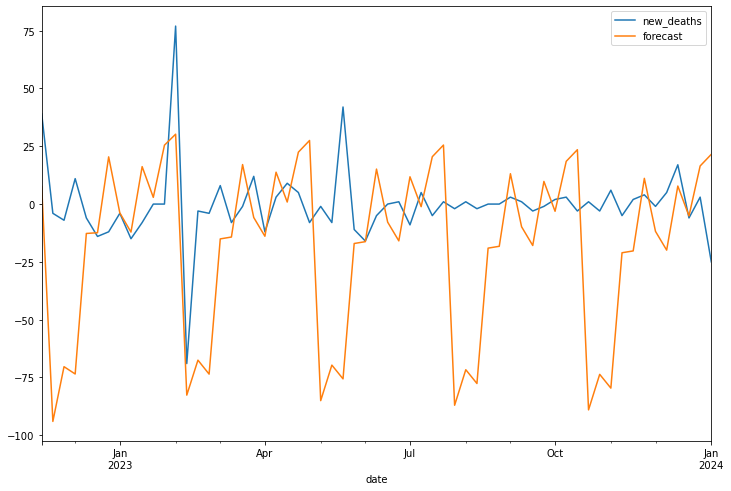

In [233]:
model=sm.tsa.statespace.SARIMAX(malaysia_train['new_deaths'],order=(2, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
malaysia_test['forecast']=results.predict(start=141,end=202,dynamic=True)
malaysia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [234]:
mae = mean_absolute_error(malaysia_test['new_deaths'], malaysia_test['forecast'])
mape = mean_absolute_percentage_error(malaysia_test['new_deaths'], malaysia_test['forecast'])
r2 = r2_score(malaysia_test['new_deaths'], malaysia_test['forecast'])
new_row = {'country': 'Malaysia', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [235]:
# need un-differenced data
malaysia = pd.read_csv('univariate_df_Malaysia.csv')
malaysia = malaysia.set_index('date')
malaysia.index = pd.to_datetime(malaysia.index)
malaysia = malaysia.drop('Unnamed: 0', axis=1)
malaysia = malaysia.drop('diff1', axis=1)
malaysia.sort_index()
train_size = int(len(malaysia) * 0.7)
malaysia_train, malaysia_test = malaysia[0:train_size], malaysia[train_size:]
print(malaysia_train.shape, malaysia_test.shape)

(141, 1) (61, 1)


In [236]:
auto_model = auto_arima(malaysia_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(malaysia_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(4, 0, 2)   Log Likelihood                -845.496
Date:                Tue, 20 Feb 2024   AIC                           1704.992
Time:                        23:19:13   BIC                           1725.633
Sample:                    03-01-2020   HQIC                          1713.380
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6429      0.121     13.604      0.000       1.406       1.880
ar.L2         -1.4184      0.246     -5.762      0.000      -1.901      -0.936
ar.L3          0.9487      0.225      4.212      0.0

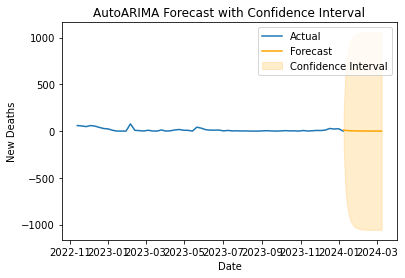

In [237]:
forecast_index = pd.date_range(malaysia_test.index[-1], periods=n_periods + 1, freq=malaysia_test.index.freq)[-n_periods:]

plt.plot(malaysia_test.index, malaysia_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [238]:
mae = mean_absolute_error(malaysia_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(malaysia_test['new_deaths'], forecast)
r2 = r2_score(malaysia_test['new_deaths'], forecast)
new_row = {'country': 'Malaysia', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Results

In [240]:
# metrics
metrics.sort_values('mape')

,country,model,mae,mape,rsq
26,Czechia,SARIMA,6.967213,0.934426,-0.009998
21,US,Grid Search ARIMA,260.526077,1.098954,0.00017
20,US,Basic ARIMA,339.882111,4.745094,-0.215846
22,US,SARIMA,504.971485,7.247923,-1.28437
36,Malaysia,Basic ARIMA,8.895615,17870350064058.890625,-0.021187
37,Malaysia,Grid Search ARIMA,8.938429,60302653141491.867188,-0.033958
28,Estonia,Basic ARIMA,2.33501,100525179085930.8125,-0.002384
29,Estonia,Grid Search ARIMA,2.333838,198250493539194.21875,0.01372
25,Czechia,Grid Search ARIMA,7.141143,456634404335245.5,-0.000464
39,Malaysia,autoARIMA,11.84937,1331607478581034.75,-0.213477
